# MCMC Analysis of Eclipse Impact Parameter

This notebook performs MCMC analysis on the eclipse impact parameter $b_{\text{occ}}$ as defined in Winn (2010):

$$b_{\text{occ}} = \frac{a \cos i}{R_\star} \left(\frac{1 - e^2}{1 - e \sin \omega}\right)$$

which can be rewritten as:

$$b_{\text{occ}} = \frac{a}{R_\star} \cos i \left(\frac{1 - e^2}{1 - e \sin \omega}\right)$$

where:
- $a/R_\star$ = scaled semi-major axis (sampled as single parameter)
- $i$ = orbital inclination
- $e$ = eccentricity
- $\omega$ = argument of periastron

**Note:** We sample on $a/R_\star$ directly rather than separately on $a$ and $R_\star$, as this parameter is often better constrained observationally from transit light curves.

This analysis uses the updated MCS and TPC data files (2025-07-18).

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import emcee
import corner
from astropy import units as u
from astropy.constants import R_sun
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Load Data

In [2]:
# Load the updated data files
mcs_file = '../../data/raw/Ariel_MCS_Known_2025-07-18.csv'
tpc_file = '../../data/raw/Ariel_MCS_TPCs_2025-07-18.csv'

mcs_df = pd.read_csv(mcs_file)
tpc_df = pd.read_csv(tpc_file)

print(f"MCS Known Planets: {len(mcs_df)}")
print(f"TPC Candidates: {len(tpc_df)}")
print(f"\nTotal systems to analyze: {len(mcs_df) + len(tpc_df)}")

MCS Known Planets: 808
TPC Candidates: 2046

Total systems to analyze: 2854


## 2. Identify Required Columns and Extract Parameters

In [3]:
# Define the columns needed for the eclipse impact parameter calculation
# Column names differ between MCS and TPC files

# For MCS (Known Planets)
mcs_columns = {
    'name': 'Planet Name',
    'a_over_rs': 'a/Rs',
    'a_over_rs_err_lower': 'a/Rs Error Lower',
    'a_over_rs_err_upper': 'a/Rs Error Upper',
    'inclination': 'Inclination',
    'inclination_err_lower': 'Inclination Error Lower',
    'inclination_err_upper': 'Inclination Error Upper',
    'impact_parameter': 'Impact Parameter',
    'impact_parameter_err_lower': 'Impact Parameter Error Lower',
    'impact_parameter_err_upper': 'Impact Parameter Error Upper',
    'eccentricity': 'Eccentricity',
    'eccentricity_err_lower': 'Eccentricity Error Lower',
    'eccentricity_err_upper': 'Eccentricity Error Upper',
    'periastron': 'Periastron',
    'periastron_err_lower': 'Periastron Error Lower',
    'periastron_err_upper': 'Periastron Error Upper',
    'rp_rs': 'Rp/Rs',
    'rp_rs_err_lower': 'Rp/Rs Error Lower',
    'rp_rs_err_upper': 'Rp/Rs Error Upper',
    'eclipse_flag': 'Eclipse Flag'
}

# For TPC (Candidates)
tpc_columns = {
    'name': 'Planet Name',
    'a_over_rs': 'a/Rs',
    'inclination': 'Inclination',
    'impact_parameter': 'Impact Parameter',
    'eccentricity': 'Eccentricity',
    'periastron': 'Periastron',
    'rp_rs': 'Rp/Rs'
}

print("MCS Columns:")
for key, col in mcs_columns.items():
    if col in mcs_df.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col} - NOT FOUND")

print("\nTPC Columns:")
for key, col in tpc_columns.items():
    if col in tpc_df.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col} - NOT FOUND")

MCS Columns:
  ✓ Planet Name
  ✓ a/Rs
  ✓ a/Rs Error Lower
  ✓ a/Rs Error Upper
  ✓ Inclination
  ✓ Inclination Error Lower
  ✓ Inclination Error Upper
  ✓ Impact Parameter
  ✓ Impact Parameter Error Lower
  ✓ Impact Parameter Error Upper
  ✓ Eccentricity
  ✓ Eccentricity Error Lower
  ✓ Eccentricity Error Upper
  ✓ Periastron
  ✓ Periastron Error Lower
  ✓ Periastron Error Upper
  ✓ Rp/Rs
  ✓ Rp/Rs Error Lower
  ✓ Rp/Rs Error Upper
  ✓ Eclipse Flag

TPC Columns:
  ✓ Planet Name
  ✓ a/Rs
  ✓ Inclination
  ✓ Impact Parameter
  ✓ Eccentricity
  ✓ Periastron
  ✓ Rp/Rs


## 3. Define the Eclipse Impact Parameter Model

In [4]:
def eclipse_impact_parameter(a_over_rs, inclination_deg, eccentricity, periastron_deg):
    """
    Calculate the eclipse impact parameter b_occ.
    
    Formula from Winn (2010):
    b_occ = (a/R*) * cos(i) * ((1 - e^2) / (1 - e * sin(omega)))
    
    Parameters:
    -----------
    a_over_rs : float
        Scaled semi-major axis (a/R*), dimensionless
    inclination_deg : float
        Orbital inclination in degrees
    eccentricity : float
        Orbital eccentricity
    periastron_deg : float
        Argument of periastron in degrees
    
    Returns:
    --------
    b_occ : float
        Eclipse impact parameter (dimensionless)
    """
    # Convert to radians
    i_rad = np.radians(inclination_deg)
    omega_rad = np.radians(periastron_deg)
    
    # Eccentricity correction factor
    ecc_factor = (1 - eccentricity**2) / (1 - eccentricity * np.sin(omega_rad))
    
    # Calculate the eclipse impact parameter
    b_occ = a_over_rs * np.cos(i_rad) * ecc_factor
    
    return b_occ

def transit_impact_to_inclination(b_tra, a_over_rs):
    """
    Convert transit impact parameter to inclination.
    
    Parameters:
    -----------
    b_tra : float
        Transit impact parameter
    a_over_rs : float
        Scaled semi-major axis (a/R*)
    
    Returns:
    --------
    i_deg : float
        Inclination in degrees
    """
    # Clip b_tra to avoid numerical issues
    b_clipped = np.clip(b_tra, -1.5, 1.5)
    cos_i = b_clipped / a_over_rs
    # Ensure cos_i is in valid range
    cos_i = np.clip(cos_i, -1.0, 1.0)
    i_rad = np.arccos(cos_i)
    i_deg = np.degrees(i_rad)
    return i_deg

# Test the function with sample values
test_b_occ = eclipse_impact_parameter(
    a_over_rs=10.0,
    inclination_deg=89.0,
    eccentricity=0.0,
    periastron_deg=90.0
)
print(f"Test b_occ calculation: {test_b_occ:.4f}")

# Test inclination conversion
test_i = transit_impact_to_inclination(b_tra=0.3, a_over_rs=10.0)
print(f"Test inclination from b_tra: {test_i:.2f} degrees")

Test b_occ calculation: 0.1745
Test inclination from b_tra: 88.28 degrees


## 4. Prepare Data for MCMC

Extract systems with complete parameter information for MCMC analysis.

In [5]:
def prepare_system_data(df, is_mcs=True):
    """
    Prepare system data for MCMC analysis.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe (MCS or TPC)
    is_mcs : bool
        Whether the dataframe is MCS (True) or TPC (False)
    
    Returns:
    --------
    systems : list of dict
        List of systems with required parameters and uncertainties
    """
    systems = []
    
    for idx, row in df.iterrows():
        # Extract parameters based on dataset type
        if is_mcs:
            name = row.get('Planet Name', f'MCS_{idx}')
            a_over_rs = row.get('a/Rs')
            a_over_rs_err_lower = abs(row.get('a/Rs Error Lower', 0))
            a_over_rs_err_upper = abs(row.get('a/Rs Error Upper', 0))
            b_tra = row.get('Impact Parameter')  # Transit impact parameter
            b_tra_err_lower = abs(row.get('Impact Parameter Error Lower', 0))
            b_tra_err_upper = abs(row.get('Impact Parameter Error Upper', 0))
            inclination = row.get('Inclination')
            inclination_err_lower = abs(row.get('Inclination Error Lower', 0))
            inclination_err_upper = abs(row.get('Inclination Error Upper', 0))
            eccentricity = row.get('Eccentricity', 0.0)
            eccentricity_err_lower = abs(row.get('Eccentricity Error Lower', 0))
            eccentricity_err_upper = abs(row.get('Eccentricity Error Upper', 0))
            periastron = row.get('Periastron', 90.0)
            periastron_err_lower = abs(row.get('Periastron Error Lower', 0))
            periastron_err_upper = abs(row.get('Periastron Error Upper', 0))
            rp_rs = row.get('Rp/Rs')
            rp_rs_err_lower = abs(row.get('Rp/Rs Error Lower', 0))
            rp_rs_err_upper = abs(row.get('Rp/Rs Error Upper', 0))
            eclipse_flag = row.get('Eclipse Flag', False)
            # Convert string 'TRUE'/'FALSE' to boolean
            if isinstance(eclipse_flag, str):
                eclipse_flag = eclipse_flag.upper() == 'TRUE'
        else:  # TPC
            name = row.get('Planet Name', f'TPC_{idx}')
            a_over_rs = row.get('a/Rs')
            a_over_rs_err_lower = 0.0  # Not available in TPC
            a_over_rs_err_upper = 0.0
            b_tra = row.get('Impact Parameter')
            b_tra_err_lower = 0.0
            b_tra_err_upper = 0.0
            inclination = row.get('Inclination')
            inclination_err_lower = 0.0  # Not available in TPC
            inclination_err_upper = 0.0
            eccentricity = row.get('Eccentricity', 0.0)
            eccentricity_err_lower = 0.0
            eccentricity_err_upper = 0.0
            periastron = row.get('Periastron', 90.0)
            periastron_err_lower = 0.0
            periastron_err_upper = 0.0
            rp_rs = row.get('Rp/Rs')
            rp_rs_err_lower = 0.0
            rp_rs_err_upper = 0.0
            eclipse_flag = None  # Not available in TPC
        
        # Check if all required parameters are available and valid
        if all([pd.notna(x) for x in [a_over_rs, inclination]]):
            # Handle NaN values with defaults
            if pd.isna(eccentricity):
                eccentricity = 0.0
            if pd.isna(periastron):
                periastron = 90.0
            if pd.isna(b_tra):
                # Derive from inclination and a/Rs if not available
                b_tra = a_over_rs * np.cos(np.radians(inclination))
            if pd.isna(rp_rs):
                rp_rs = 0.1  # Default placeholder
            
            # Average uncertainties or use defaults
            a_over_rs_err = (a_over_rs_err_lower + a_over_rs_err_upper) / 2 if (a_over_rs_err_lower + a_over_rs_err_upper) > 0 else a_over_rs * 0.05
            b_tra_err = (b_tra_err_lower + b_tra_err_upper) / 2 if (b_tra_err_lower + b_tra_err_upper) > 0 else 0.05
            inclination_err = (inclination_err_lower + inclination_err_upper) / 2 if (inclination_err_lower + inclination_err_upper) > 0 else 0.5
            eccentricity_err = (eccentricity_err_lower + eccentricity_err_upper) / 2 if (eccentricity_err_lower + eccentricity_err_upper) > 0 else 0.01
            periastron_err = (periastron_err_lower + periastron_err_upper) / 2 if (periastron_err_lower + periastron_err_upper) > 0 else 10.0
            rp_rs_err = (rp_rs_err_lower + rp_rs_err_upper) / 2 if (rp_rs_err_lower + rp_rs_err_upper) > 0 else rp_rs * 0.05
            
            # Compute cos(i) and its uncertainty for direct sampling
            cos_i = np.cos(np.radians(inclination))
            # Propagate inclination uncertainty to cos(i) using: d(cos i)/di = -sin(i)
            cos_i_err = abs(np.sin(np.radians(inclination)) * np.radians(inclination_err))
            if cos_i_err == 0:
                cos_i_err = 0.01  # Default minimum uncertainty
            
            systems.append({
                'name': name,
                'a_over_rs': a_over_rs,
                'a_over_rs_err': a_over_rs_err,
                'b_tra': b_tra,
                'b_tra_err': b_tra_err,
                'inclination': inclination,
                'inclination_err': inclination_err,
                'cos_i': cos_i,
                'cos_i_err': cos_i_err,
                'eccentricity': eccentricity,
                'eccentricity_err': eccentricity_err,
                'periastron': periastron,
                'periastron_err': periastron_err,
                'rp_rs': rp_rs,
                'eclipse_flag': eclipse_flag,
                'dataset': 'MCS' if is_mcs else 'TPC'
            })
    
    return systems

# Prepare data from both datasets
mcs_systems = prepare_system_data(mcs_df, is_mcs=True)
tpc_systems = prepare_system_data(tpc_df, is_mcs=False)

all_systems = mcs_systems + tpc_systems

print(f"Systems prepared for MCMC:")
print(f"  MCS: {len(mcs_systems)}")
print(f"  TPC: {len(tpc_systems)}")
print(f"  Total: {len(all_systems)}")

# Display first few systems
if len(all_systems) > 0:
    print(f"\nExample system: {all_systems[0]['name']}")
    for key, val in all_systems[0].items():
        if key != 'name':
            print(f"  {key}: {val}")

Systems prepared for MCMC:
  MCS: 808
  TPC: 2046
  Total: 2854

Example system: K2-232b
  a_over_rs: 17.28
  a_over_rs_err: 0.54
  b_tra: 0.108
  b_tra_err: 0.076
  inclination: 89.61
  inclination_err: 0.275
  cos_i: 0.006806731520561874
  cos_i_err: 0.004799544253852854
  eccentricity: 0.255
  eccentricity_err: 0.035
  periastron: 170.9
  periastron_err: 172.85
  rp_rs: 0.08811
  eclipse_flag: False
  dataset: MCS


## 5. MCMC Setup

Define the log-likelihood and log-prior functions for the MCMC analysis.

In [6]:
# Import required for priors
from scipy.stats import beta as beta_dist
from scipy.stats import norm

# ---------------------------------------------------------------------
# Eccentricity prior (Kipping-style Beta prior)
# ---------------------------------------------------------------------

def beta_prior_ecc(e, alpha=0.867, beta=3.03):
    """
    Kipping-style Beta prior for eccentricity (suitable for short-period planets).
    Returns log probability.
    
    Parameters
    ----------
    e : float
        Eccentricity value.
    alpha, beta : float
        Beta distribution parameters (Kipping 2013/2014 defaults).
    
    Returns
    -------
    log_prob : float
        Log probability.
    """
    if e < 0.0 or e >= 1.0:
        return -np.inf
    lp = beta_dist.logpdf(e, alpha, beta)
    if not np.isfinite(lp):
        return -np.inf
    return lp


# ---------------------------------------------------------------------
# Priors: theta = [a_over_rs, cos_i, e, omega_deg]
# system = dict with transit-based constraints
#   system['a_over_rs'], system['a_over_rs_err']
#   system['cos_i'], system['cos_i_err']
#   system['rp_rs']
# ---------------------------------------------------------------------

def log_prior(theta, system):
    """
    Log prior probability with informative priors based on transit observations.
    
    Parameters
    ----------
    theta : array-like
        [a_over_rs, cos_i, e, omega_deg]
    system : dict
        System parameters and uncertainties from transit fits.
    
    Returns
    -------
    log_prob : float
        Log prior probability.
    """
    a_over_rs, cos_i, e, omega_deg = theta
    
    # Physical bounds
    if a_over_rs <= 0.0:
        return -np.inf
    if e < 0.0 or e >= 1.0:
        return -np.inf
    if omega_deg < 0.0 or omega_deg >= 360.0:
        return -np.inf
    if cos_i < -1.0 or cos_i > 1.0:
        return -np.inf
    
    log_prob = 0.0
    
    # Gaussian prior on a/Rs (from transit + stellar modeling)
    log_prob += norm.logpdf(
        a_over_rs,
        loc=system['a_over_rs'],
        scale=system['a_over_rs_err']
    )
    
    # Gaussian prior on cos(i) (derived once from transit solution)
    log_prob += norm.logpdf(
        cos_i,
        loc=system['cos_i'],
        scale=system['cos_i_err']
    )
    
    # Kipping-style Beta prior on eccentricity (favors low e for short-period planets)
    log_prob += beta_prior_ecc(e, alpha=0.867, beta=3.03)
    
    # Uniform prior on omega in [0, 360): normalization is constant, can be skipped
    return log_prob


# ---------------------------------------------------------------------
# Geometry-only "likelihood": enforce occultation existence
# ---------------------------------------------------------------------

def log_likelihood(theta, system):
    """
    Log 'likelihood' function.
    
    For pure detectability / geometry sampling, we impose only a hard constraint
    that an occultation must exist:
    
        |b_occ| <= 1 + k   (where k = Rp/Rs)
    
    If the condition is satisfied, we return 0 (flat likelihood); otherwise -inf.
    """
    a_over_rs, cos_i, e, omega_deg = theta
    
    # Inclination in degrees from cos(i)
    cos_i_clipped = np.clip(cos_i, -1.0, 1.0)
    i_deg = np.degrees(np.arccos(cos_i_clipped))
    
    # Occultation impact parameter (Winn 2010; superior conjunction)
    # eclipse_impact_parameter(a_over_rs, i_deg, e, omega_deg) implements:
    #   b_occ = (a/Rs * cos i) * (1 - e^2) / (1 - e * sin(omega))
    b_occ = eclipse_impact_parameter(a_over_rs, i_deg, e, omega_deg)
    
    # Hard constraint: occultation must exist (grazing or deeper)
    k = system['rp_rs']  # Rp/Rs from transit
    if np.abs(b_occ) > (1.0 + k):
        return -np.inf
    
    # Geometry-only likelihood: flat if occultation exists
    return 0.0


# ---------------------------------------------------------------------
# Posterior
# ---------------------------------------------------------------------

def log_probability(theta, system):
    """
    Log posterior probability: prior + likelihood.
    """
    lp = log_prior(theta, system)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, system)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll


print("MCMC geometry / prior functions defined successfully.")

MCMC geometry / prior functions defined successfully.


## 6. Run MCMC for Selected Systems

Run MCMC to propagate uncertainties through the eclipse impact parameter calculation.

In [7]:
def run_mcmc_for_system(system, nwalkers=32, nsteps=5000, burn_in=1000):
    """
    Run MCMC for a single system with informative priors.
    
    Parameters:
    -----------
    system : dict
        System parameters
    nwalkers : int
        Number of MCMC walkers
    nsteps : int
        Number of MCMC steps
    burn_in : int
        Number of burn-in steps to discard
    
    Returns:
    --------
    results : dict
        MCMC results including samples and b_occ distribution
    """
    # Number of parameters: a/Rs, cos(i), e, omega
    ndim = 4
    
    # Initial positions for walkers
    p0 = np.array([
        system['a_over_rs'],
        system['cos_i'],
        system['eccentricity'],
        system['periastron']
    ])
    
    # Add random offsets with guaranteed minimum spread to avoid linear dependence
    perturbation_scale = np.array([
        max(system['a_over_rs_err'] * 0.1, system['a_over_rs'] * 0.01),  # At least 1% of a/Rs
        max(system['cos_i_err'] * 0.1, 0.01),  # At least 0.01 in cos(i)
        max(system['eccentricity_err'] * 0.1, 0.05),  # At least 0.05 in e
        max(system['periastron_err'] * 0.1, 10.0)  # At least 10 degrees in omega
    ])
    
    pos = p0 + np.random.randn(nwalkers, ndim) * perturbation_scale
    
    # Ensure all walkers start in valid parameter space
    # Clip a/Rs to positive values with reasonable bounds
    pos[:, 0] = np.clip(pos[:, 0], p0[0] * 0.8, p0[0] * 1.2)
    # Clip cos(i) to valid range
    pos[:, 1] = np.clip(pos[:, 1], -1.0, 1.0)
    # Clip eccentricity to [0, 1)
    pos[:, 2] = np.clip(pos[:, 2], 0.0, 0.99)
    # Wrap omega to [0, 360)
    pos[:, 3] = pos[:, 3] % 360.0
    
    # Initialize sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(system,))
    
    # Run MCMC
    print(f"Running MCMC for {system['name']}...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    # Get samples after burn-in
    samples = sampler.get_chain(discard=burn_in, flat=True)
    
    # Calculate derived quantities for each sample
    b_occ_samples = []
    i_deg_samples = []
    
    for s in samples:
        a_over_rs, cos_i, e, omega = s
        # Derive inclination from cos(i)
        cos_i_clipped = np.clip(cos_i, -1.0, 1.0)
        i_deg = np.degrees(np.arccos(cos_i_clipped))
        i_deg_samples.append(i_deg)
        
        # Calculate b_occ
        b_occ = eclipse_impact_parameter(a_over_rs, i_deg, e, omega)
        b_occ_samples.append(b_occ)
    
    b_occ_samples = np.array(b_occ_samples)
    i_deg_samples = np.array(i_deg_samples)
    
    # Calculate statistics
    b_occ_median = np.median(b_occ_samples)
    b_occ_std = np.std(b_occ_samples)
    b_occ_16, b_occ_84 = np.percentile(b_occ_samples, [16, 84])
    
    i_median = np.median(i_deg_samples)
    i_16, i_84 = np.percentile(i_deg_samples, [16, 84])
    
    # Calculate tier based on b_occ_84 and system's k = Rp/Rs
    k = system['rp_rs']
    if b_occ_84 < 1.0:
        tier = 1  # Premium: non-grazing even at +1σ
        tier_label = "Premium (non-grazing)"
    elif b_occ_84 < 1.0 + k:
        tier = 2  # Good: eclipse certain, may be grazing
        tier_label = "Good (includes grazing)"
    elif b_occ_median < 1.0 + k:
        tier = 3  # Possible: eclipse likely but uncertain
        tier_label = "Possible (uncertain)"
    else:
        tier = 4  # Risky: eclipse unlikely
        tier_label = "Risky (eclipse unlikely)"
    
    results = {
        'name': system['name'],
        'dataset': system['dataset'],
        'eclipse_flag': system['eclipse_flag'],
        'samples': samples,
        'b_occ_samples': b_occ_samples,
        'i_deg_samples': i_deg_samples,
        'b_occ_median': b_occ_median,
        'b_occ_std': b_occ_std,
        'b_occ_16': b_occ_16,
        'b_occ_84': b_occ_84,
        'b_occ_err_lower': b_occ_median - b_occ_16,
        'b_occ_err_upper': b_occ_84 - b_occ_median,
        'i_median': i_median,
        'i_err_lower': i_median - i_16,
        'i_err_upper': i_84 - i_median,
        'k': k,
        'tier': tier,
        'tier_label': tier_label,
        'acceptance_fraction': np.mean(sampler.acceptance_fraction)
    }
    print(f"  Eclipse observed: {system['eclipse_flag']}")
    print(f"  b_occ = {b_occ_median:.4f} +{b_occ_84 - b_occ_median:.4f} -{b_occ_median - b_occ_16:.4f}")
    print(f"  i = {i_median:.2f} +{i_84 - i_median:.2f} -{i_median - i_16:.2f} degrees")
    print(f"  k (Rp/Rs) = {k:.4f}, 1+k = {1+k:.4f}")
    print(f"  Tier: {tier} - {tier_label}")
    print(f"  Acceptance fraction: {results['acceptance_fraction']:.3f}")
    
    return results

print("MCMC runner function defined.")

MCMC runner function defined.


## 7. Analyze First Few Systems (Example)

Run MCMC on the first few systems to demonstrate the analysis.

In [8]:
# Find systems with observed eclipses and run MCMC on them
systems_with_eclipse = [s for s in all_systems if s['eclipse_flag'] == True]
systems_without_eclipse = [s for s in all_systems if s['eclipse_flag'] == False]

print(f"Systems with observed eclipses: {len(systems_with_eclipse)}")
print(f"Systems without observed eclipses: {len(systems_without_eclipse)}")
print(f"Systems with unknown eclipse status (TPC): {len([s for s in all_systems if s['eclipse_flag'] is None])}")

# Run MCMC on first 3 systems with observed eclipses
n_examples = min(3, len(systems_with_eclipse))
mcmc_results = []

print(f"\n{'='*60}")
print(f"Running MCMC on {n_examples} systems WITH observed eclipses")
print(f"{'='*60}\n")

for i in range(n_examples):
    system = systems_with_eclipse[i]
    try:
        result = run_mcmc_for_system(system, nwalkers=32, nsteps=3000, burn_in=500)
        mcmc_results.append(result)
    except Exception as e:
        print(f"Error processing {system['name']}: {e}")
        continue

Systems with observed eclipses: 99
Systems without observed eclipses: 709
Systems with unknown eclipse status (TPC): 2046

Running MCMC on 3 systems WITH observed eclipses

Running MCMC for KELT-20b...


100%|██████████| 3000/3000 [00:07<00:00, 415.90it/s]



  Eclipse observed: True
  b_occ = 0.4902 +0.0855 -0.1114
  i = 86.12 +0.27 -0.26 degrees
  k (Rp/Rs) = 0.1144, 1+k = 1.1144
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497
Running MCMC for WASP-46b...


100%|██████████| 3000/3000 [00:07<00:00, 416.39it/s]



  Eclipse observed: True
  b_occ = 0.7205 +0.0969 -0.1648
  i = 82.79 +0.17 -0.17 degrees
  k (Rp/Rs) = 0.1407, 1+k = 1.1407
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494
Running MCMC for WASP-17b...


100%|██████████| 3000/3000 [00:07<00:00, 418.23it/s]



  Eclipse observed: True
  b_occ = 0.3645 +0.1092 -0.1065
  i = 86.87 +0.60 -0.62 degrees
  k (Rp/Rs) = 0.1302, 1+k = 1.1302
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500


## 8. Visualize Results

Create corner plots and posterior distributions for the MCMC results.

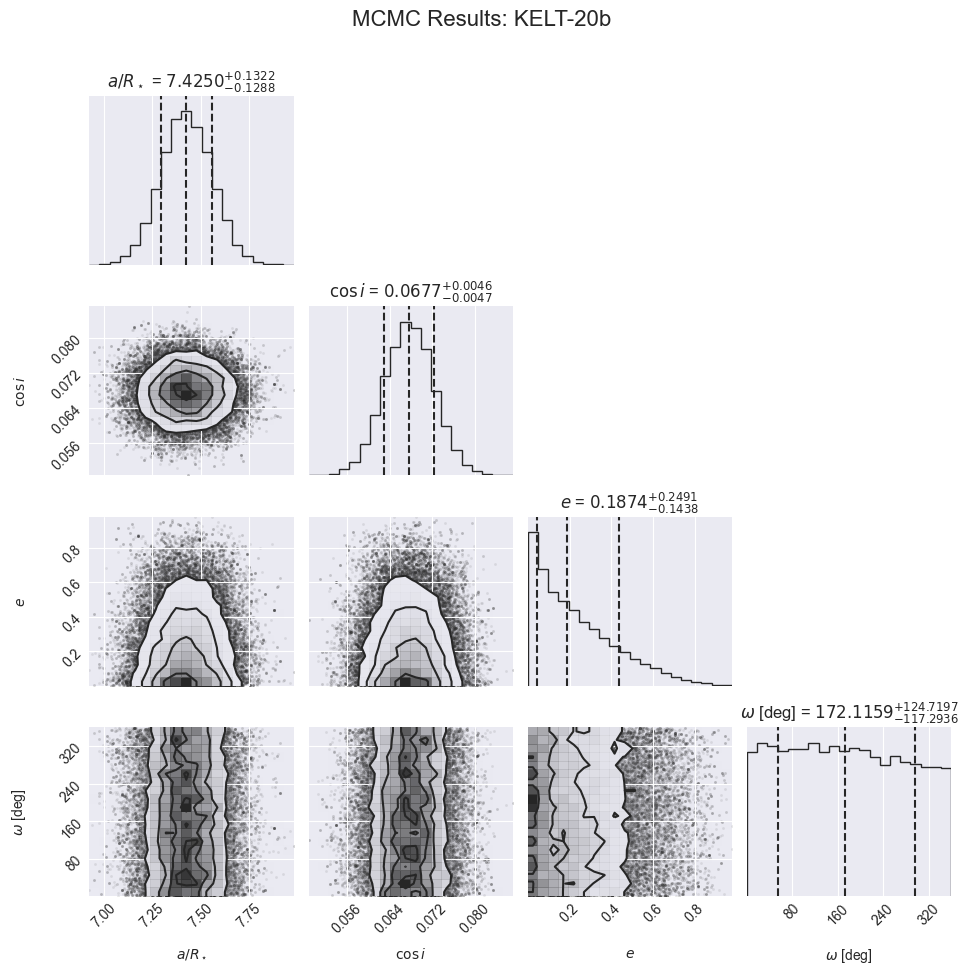

In [9]:
# Plot corner plot for the first system
if len(mcmc_results) > 0:
    result = mcmc_results[0]
    
    labels = [r'$a/R_\star$', r'$\cos i$', r'$e$', r'$\omega$ [deg]']
    
    fig = corner.corner(
        result['samples'],
        labels=labels,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_fmt='.4f',
        title_kwargs={"fontsize": 12}
    )
    
    fig.suptitle(f"MCMC Results: {result['name']}", fontsize=16, y=1.01)
    plt.tight_layout()
    plt.show()

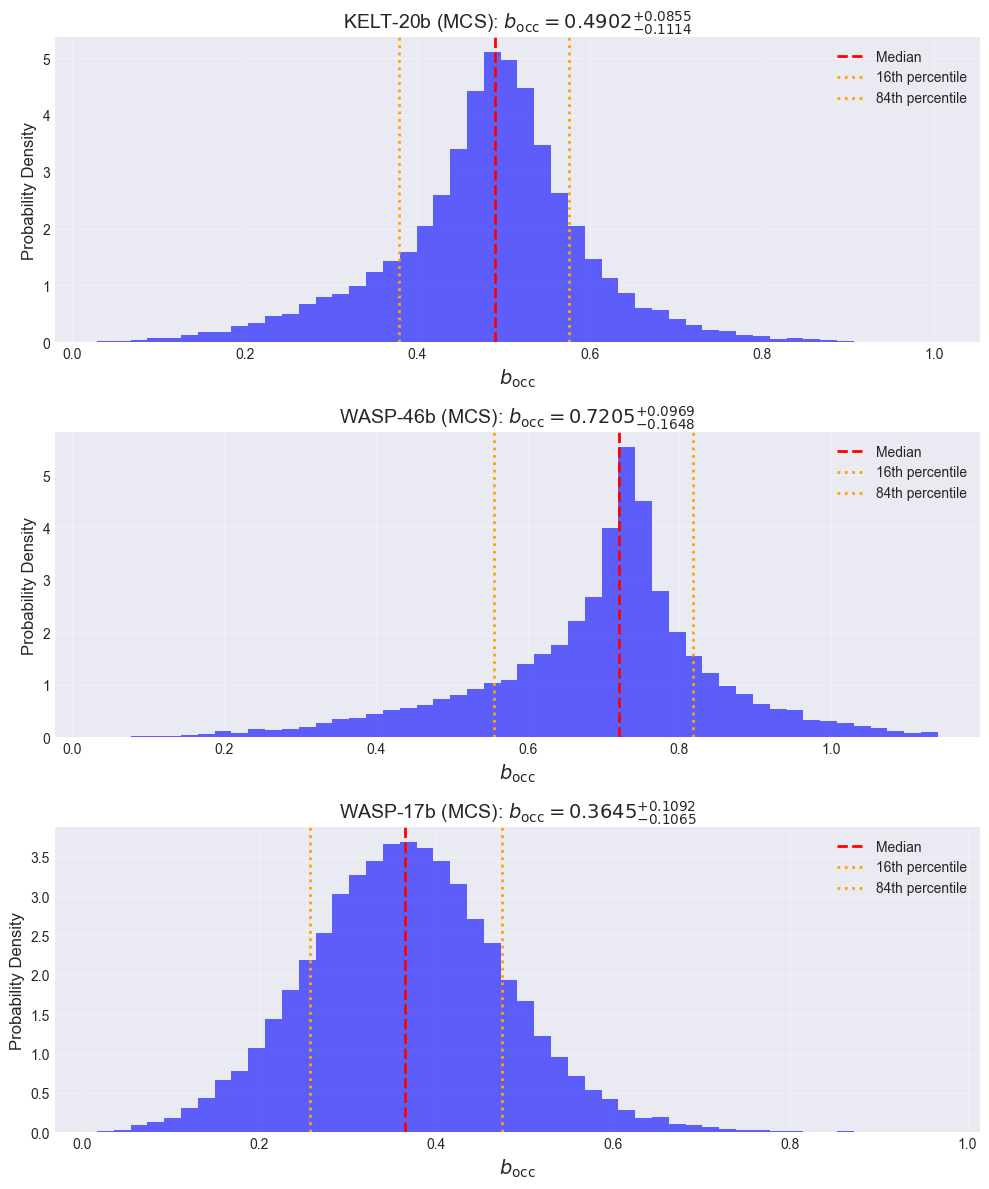

In [10]:
# Plot b_occ distributions for all analyzed systems
if len(mcmc_results) > 0:
    fig, axes = plt.subplots(len(mcmc_results), 1, figsize=(10, 4*len(mcmc_results)))
    
    if len(mcmc_results) == 1:
        axes = [axes]
    
    for i, result in enumerate(mcmc_results):
        ax = axes[i]
        
        # Histogram of b_occ
        ax.hist(result['b_occ_samples'], bins=50, density=True, alpha=0.6, color='blue')
        
        # Mark median and percentiles
        ax.axvline(result['b_occ_median'], color='red', linestyle='--', linewidth=2, label='Median')
        ax.axvline(result['b_occ_median'] - result['b_occ_err_lower'], color='orange', linestyle=':', linewidth=2, label='16th percentile')
        ax.axvline(result['b_occ_median'] + result['b_occ_err_upper'], color='orange', linestyle=':', linewidth=2, label='84th percentile')
        
        ax.set_xlabel(r'$b_{\rm occ}$', fontsize=14)
        ax.set_ylabel('Probability Density', fontsize=12)
        ax.set_title(f"{result['name']} ({result['dataset']}): $b_{{\\rm occ}} = {result['b_occ_median']:.4f}^{{+{result['b_occ_err_upper']:.4f}}}_{{-{result['b_occ_err_lower']:.4f}}}$", fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Summary Table

Create a summary table of the MCMC results.

In [11]:
# Create summary DataFrame
if len(mcmc_results) > 0:
    summary_data = []
    
    for result in mcmc_results:
        summary_data.append({
            'Planet': result['name'],
            'Dataset': result['dataset'],
            'Eclipse Observed': result['eclipse_flag'],
            'b_occ (median)': f"{result['b_occ_median']:.4f}",
            'b_occ_16': f"{result['b_occ_16']:.4f}",
            'b_occ_84': f"{result['b_occ_84']:.4f}",
            'k (Rp/Rs)': f"{result['k']:.4f}",
            '1+k': f"{1+result['k']:.4f}",
            'Tier': result['tier'],
            'Tier Label': result['tier_label'],
            'Acceptance Fraction': f"{result['acceptance_fraction']:.3f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)

,Planet,Dataset,Eclipse Observed,b_occ (median),b_occ_16,b_occ_84,k (Rp/Rs),1+k,Tier,Tier Label,Acceptance Fraction
0,KELT-20b,MCS,True,0.4902,0.3788,0.5757,0.1144,1.1144,1,Premium (non-grazing),0.497
1,WASP-46b,MCS,True,0.7205,0.5557,0.8174,0.1407,1.1407,1,Premium (non-grazing),0.494
2,WASP-17b,MCS,True,0.3645,0.2580,0.4737,0.1302,1.1302,1,Premium (non-grazing),0.500


## 10. Run Full Analysis (Optional)

Uncomment and run this cell to perform MCMC analysis on all systems. 
**Warning: This may take considerable time depending on the number of systems.**

In [ ]:
# Run MCMC on TPC systems - START FROM INDEX 700 (701st candidate)
import time
import os

print("="*70)
print("PROCESSING TPC (TIER 1 CANDIDATES) - STARTING FROM #701")
print("="*70)

# Load existing results to avoid duplicates
tpc_temp_file = '../results/tpc_eclipse_impact_parameter_mcmc_temp.csv'
processed_names = set()
tpc_results_list = []

if os.path.exists(tpc_temp_file):
    existing_df = pd.read_csv(tpc_temp_file)
    processed_names = set(existing_df['Planet'].values)
    print(f"Found {len(processed_names)} already processed TPC systems")
else:
    print("No existing temp file found - starting fresh")

start_time = time.time()
start_index = 700  # Start from 701st candidate (0-indexed: 700)

for i in range(start_index, len(tpc_systems)):
    system = tpc_systems[i]
    
    # Skip if already processed
    if system['name'] in processed_names:
        print(f"\n[TPC {i+1}/{len(tpc_systems)}] SKIPPING (already processed): {system['name']}")
        continue
    
    print(f"\n[TPC {i+1}/{len(tpc_systems)}] Processing: {system['name']}")
    try:
        result = run_mcmc_for_system(system, nwalkers=32, nsteps=3000, burn_in=500)
        tpc_results_list.append({
            'Planet': result['name'],
            'Dataset': result['dataset'],
            'eclipse_observed': result['eclipse_flag'],
            'b_occ_median': result['b_occ_median'],
            'b_occ_16': result['b_occ_16'],
            'b_occ_84': result['b_occ_84'],
            'b_occ_std': result['b_occ_std'],
            'b_occ_err_lower': result['b_occ_err_lower'],
            'b_occ_err_upper': result['b_occ_err_upper'],
            'k_rp_rs': result['k'],
            'one_plus_k': 1 + result['k'],
            'tier': result['tier'],
            'tier_label': result['tier_label'],
            'acceptance_fraction': result['acceptance_fraction']
        })
        processed_names.add(result['name'])
        
        # Save intermediate results every 10 systems (more frequent for debugging)
        if len(tpc_results_list) % 10 == 0:
            # Reload existing data and append new results
            if os.path.exists(tpc_temp_file):
                existing_df = pd.read_csv(tpc_temp_file)
                new_df = pd.DataFrame(tpc_results_list)
                # Combine and remove duplicates
                combined_df = pd.concat([existing_df, new_df], ignore_index=True)
                combined_df = combined_df.drop_duplicates(subset='Planet', keep='last')
            else:
                combined_df = pd.DataFrame(tpc_results_list)
            
            combined_df.to_csv(tpc_temp_file, index=False)
            elapsed = time.time() - start_time
            print(f"\n>>> Checkpoint: {len(tpc_results_list)} new systems completed. Total in file: {len(combined_df)}. Elapsed time: {elapsed/60:.1f} min")
    except Exception as e:
        print(f"ERROR processing {system['name']}: {e}")
        import traceback
        traceback.print_exc()
        continue

tpc_elapsed = time.time() - start_time
print(f"\n{'='*70}")
print(f"TPC COMPLETE: Processed {len(tpc_results_list)} new systems (starting from #{start_index+1})")
print(f"Time: {tpc_elapsed/60:.1f} min")
print(f"{'='*70}\n")

# Final save with all data
if os.path.exists(tpc_temp_file):
    existing_df = pd.read_csv(tpc_temp_file)
    new_df = pd.DataFrame(tpc_results_list)
    combined_df = pd.concat([existing_df, new_df], ignore_index=True)
    combined_df = combined_df.drop_duplicates(subset='Planet', keep='last')
    combined_df.to_csv(tpc_temp_file, index=False)
    print(f"Final TPC results saved: {len(combined_df)} total systems")
else:
    combined_df = pd.DataFrame(tpc_results_list)
    combined_df.to_csv(tpc_temp_file, index=False)
    print(f"Final TPC results saved: {len(combined_df)} total systems")

PROCESSING TPC (TIER 1 CANDIDATES) - STARTING FROM #701
Found 800 already processed TPC systems

[TPC 701/2046] SKIPPING (already processed): TOI-3679.01

[TPC 702/2046] SKIPPING (already processed): TOI-3682.01

[TPC 703/2046] SKIPPING (already processed): TOI-3683.01

[TPC 704/2046] SKIPPING (already processed): TOI-3686.01

[TPC 705/2046] SKIPPING (already processed): TOI-3691.01

[TPC 706/2046] SKIPPING (already processed): TOI-3696.01

[TPC 707/2046] SKIPPING (already processed): TOI-3698.01

[TPC 708/2046] SKIPPING (already processed): TOI-3699.01

[TPC 709/2046] SKIPPING (already processed): TOI-3700.01

[TPC 710/2046] SKIPPING (already processed): TOI-3701.01

[TPC 711/2046] SKIPPING (already processed): TOI-3702.01

[TPC 712/2046] SKIPPING (already processed): TOI-3703.01

[TPC 713/2046] SKIPPING (already processed): TOI-3706.01

[TPC 714/2046] SKIPPING (already processed): TOI-3707.01

[TPC 715/2046] SKIPPING (already processed): TOI-3708.01

[TPC 716/2046] SKIPPING (already 

100%|██████████| 3000/3000 [00:07<00:00, 418.95it/s]



  Eclipse observed: None
  b_occ = 0.0057 +0.0922 -0.0908
  i = 89.97 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1214, 1+k = 1.1214
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 802/2046] Processing: TOI-3947.01
Running MCMC for TOI-3947.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.18it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0493 -0.0500
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0677, 1+k = 1.0677
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 803/2046] Processing: TOI-3951.01
Running MCMC for TOI-3951.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.65it/s]



  Eclipse observed: None
  b_occ = 0.0012 +0.0459 -0.0461
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0937, 1+k = 1.0937
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 804/2046] Processing: TOI-3952.01
Running MCMC for TOI-3952.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.56it/s]



  Eclipse observed: None
  b_occ = 0.0022 +0.0516 -0.0514
  i = 89.98 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1135, 1+k = 1.1135
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 805/2046] Processing: TOI-3955.01
Running MCMC for TOI-3955.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.94it/s]



  Eclipse observed: None
  b_occ = -0.0021 +0.0563 -0.0574
  i = 90.02 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1168, 1+k = 1.1168
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 806/2046] Processing: TOI-3958.01
Running MCMC for TOI-3958.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.22it/s]



  Eclipse observed: None
  b_occ = -0.0012 +0.1343 -0.1389
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0741, 1+k = 1.0741
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 807/2046] Processing: TOI-3959.01
Running MCMC for TOI-3959.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.60it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0564 -0.0575
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0767, 1+k = 1.0767
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.492

[TPC 808/2046] Processing: TOI-3965.01
Running MCMC for TOI-3965.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.95it/s]



  Eclipse observed: None
  b_occ = -0.0020 +0.0533 -0.0517
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0884, 1+k = 1.0884
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 809/2046] Processing: TOI-3966.01
Running MCMC for TOI-3966.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.16it/s]



  Eclipse observed: None
  b_occ = 0.0039 +0.0826 -0.0844
  i = 89.97 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1098, 1+k = 1.1098
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 810/2046] Processing: TOI-3972.01
Running MCMC for TOI-3972.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.58it/s]



  Eclipse observed: None
  b_occ = 0.0028 +0.1830 -0.1829
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1270, 1+k = 1.1270
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

>>> Checkpoint: 10 new systems completed. Total in file: 810. Elapsed time: 1.2 min

[TPC 811/2046] Processing: TOI-3977.01
Running MCMC for TOI-3977.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.17it/s]



  Eclipse observed: None
  b_occ = -0.0095 +0.3244 -0.3137
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0970, 1+k = 1.0970
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 812/2046] Processing: TOI-3982.01
Running MCMC for TOI-3982.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.64it/s]



  Eclipse observed: None
  b_occ = 0.0018 +0.0553 -0.0543
  i = 89.98 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0805, 1+k = 1.0805
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 813/2046] Processing: TOI-3986.01
Running MCMC for TOI-3986.01...


100%|██████████| 3000/3000 [00:06<00:00, 436.62it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0247 -0.0241
  i = 90.00 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0332, 1+k = 1.0332
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 814/2046] Processing: TOI-3988.01
Running MCMC for TOI-3988.01...


100%|██████████| 3000/3000 [00:06<00:00, 437.88it/s]



  Eclipse observed: None
  b_occ = -0.0000 +0.0333 -0.0322
  i = 90.00 +0.47 -0.48 degrees
  k (Rp/Rs) = 0.0707, 1+k = 1.0707
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 815/2046] Processing: TOI-3991.01
Running MCMC for TOI-3991.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.40it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0261 -0.0261
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0390, 1+k = 1.0390
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 816/2046] Processing: TOI-3998.01
Running MCMC for TOI-3998.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.15it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0438 -0.0424
  i = 90.02 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1134, 1+k = 1.1134
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 817/2046] Processing: TOI-4000.01
Running MCMC for TOI-4000.01...


100%|██████████| 3000/3000 [00:06<00:00, 436.88it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0521 -0.0516
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1132, 1+k = 1.1132
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 818/2046] Processing: TOI-4001.01
Running MCMC for TOI-4001.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.21it/s]



  Eclipse observed: None
  b_occ = -0.0043 +0.0898 -0.0895
  i = 90.02 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0453, 1+k = 1.0453
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 819/2046] Processing: TOI-4003.01
Running MCMC for TOI-4003.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.08it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0713 -0.0708
  i = 90.00 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0762, 1+k = 1.0762
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 820/2046] Processing: TOI-4007.01
Running MCMC for TOI-4007.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.50it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.1017 -0.1018
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1106, 1+k = 1.1106
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

>>> Checkpoint: 20 new systems completed. Total in file: 820. Elapsed time: 2.4 min

[TPC 821/2046] Processing: TOI-4009.01
Running MCMC for TOI-4009.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.09it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0498 -0.0507
  i = 89.99 +0.52 -0.50 degrees
  k (Rp/Rs) = 0.0731, 1+k = 1.0731
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 822/2046] Processing: TOI-4011.01
Running MCMC for TOI-4011.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.91it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0595 -0.0613
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0924, 1+k = 1.0924
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 823/2046] Processing: TOI-4013.01
Running MCMC for TOI-4013.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.61it/s]



  Eclipse observed: None
  b_occ = 0.0002 +0.0266 -0.0265
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0650, 1+k = 1.0650
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 824/2046] Processing: TOI-4015.01
Running MCMC for TOI-4015.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.41it/s]



  Eclipse observed: None
  b_occ = -0.0008 +0.0654 -0.0649
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1164, 1+k = 1.1164
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 825/2046] Processing: TOI-4016.01
Running MCMC for TOI-4016.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.74it/s]



  Eclipse observed: None
  b_occ = 0.0030 +0.0632 -0.0640
  i = 89.97 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0602, 1+k = 1.0602
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 826/2046] Processing: TOI-4017.01
Running MCMC for TOI-4017.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.52it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0838 -0.0832
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0767, 1+k = 1.0767
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 827/2046] Processing: TOI-4021.01
Running MCMC for TOI-4021.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.07it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0543 -0.0530
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0556, 1+k = 1.0556
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 828/2046] Processing: TOI-4024.01
Running MCMC for TOI-4024.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.91it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0609 -0.0625
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0702, 1+k = 1.0702
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 829/2046] Processing: TOI-4028.01
Running MCMC for TOI-4028.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.56it/s]



  Eclipse observed: None
  b_occ = 0.0011 +0.0709 -0.0724
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1271, 1+k = 1.1271
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 830/2046] Processing: TOI-4029.01
Running MCMC for TOI-4029.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.57it/s]



  Eclipse observed: None
  b_occ = -0.0014 +0.0945 -0.0963
  i = 90.01 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0550, 1+k = 1.0550
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 30 new systems completed. Total in file: 830. Elapsed time: 3.7 min

[TPC 831/2046] Processing: TOI-4034.01
Running MCMC for TOI-4034.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.65it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0277 -0.0282
  i = 90.01 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0926, 1+k = 1.0926
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 832/2046] Processing: TOI-4038.01
Running MCMC for TOI-4038.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.69it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0607 -0.0606
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0677, 1+k = 1.0677
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 833/2046] Processing: TOI-4041.01
Running MCMC for TOI-4041.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.44it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0956 -0.0956
  i = 90.00 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0716, 1+k = 1.0716
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 834/2046] Processing: TOI-4043.01
Running MCMC for TOI-4043.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.52it/s]



  Eclipse observed: None
  b_occ = 0.0031 +0.0604 -0.0607
  i = 89.97 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0795, 1+k = 1.0795
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 835/2046] Processing: TOI-4047.01
Running MCMC for TOI-4047.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.15it/s]



  Eclipse observed: None
  b_occ = 0.0040 +0.0663 -0.0672
  i = 89.97 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0538, 1+k = 1.0538
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 836/2046] Processing: TOI-4056.01
Running MCMC for TOI-4056.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.71it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0711 -0.0704
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0575, 1+k = 1.0575
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 837/2046] Processing: TOI-4065.01
Running MCMC for TOI-4065.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.01it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0685 -0.0695
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0818, 1+k = 1.0818
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 838/2046] Processing: TOI-407.01
Running MCMC for TOI-407.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.94it/s]



  Eclipse observed: None
  b_occ = -0.0021 +0.0329 -0.0318
  i = 90.03 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0706, 1+k = 1.0706
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 839/2046] Processing: TOI-4074.01
Running MCMC for TOI-4074.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.76it/s]



  Eclipse observed: None
  b_occ = -0.0000 +0.0555 -0.0552
  i = 90.00 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.1090, 1+k = 1.1090
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 840/2046] Processing: TOI-4079.01
Running MCMC for TOI-4079.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.82it/s]



  Eclipse observed: None
  b_occ = -0.0026 +0.0505 -0.0501
  i = 90.03 +0.47 -0.48 degrees
  k (Rp/Rs) = 0.1395, 1+k = 1.1395
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

>>> Checkpoint: 40 new systems completed. Total in file: 840. Elapsed time: 4.9 min

[TPC 841/2046] Processing: TOI-4081.01
Running MCMC for TOI-4081.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.04it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0571 -0.0583
  i = 89.99 +0.49 -0.47 degrees
  k (Rp/Rs) = 0.0452, 1+k = 1.0452
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 842/2046] Processing: TOI-4082.01
Running MCMC for TOI-4082.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.88it/s]



  Eclipse observed: None
  b_occ = -0.0032 +0.0729 -0.0742
  i = 90.02 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0990, 1+k = 1.0990
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 843/2046] Processing: TOI-4085.01
Running MCMC for TOI-4085.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.85it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0648 -0.0635
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0985, 1+k = 1.0985
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 844/2046] Processing: TOI-4086.01
Running MCMC for TOI-4086.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.66it/s]



  Eclipse observed: None
  b_occ = 0.0015 +0.0646 -0.0654
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0733, 1+k = 1.0733
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 845/2046] Processing: TOI-4088.01
Running MCMC for TOI-4088.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.56it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0542 -0.0559
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.1023, 1+k = 1.1023
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 846/2046] Processing: TOI-4090.01
Running MCMC for TOI-4090.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.95it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0817 -0.0800
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0603, 1+k = 1.0603
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 847/2046] Processing: TOI-4092.01
Running MCMC for TOI-4092.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.31it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0912 -0.0921
  i = 89.99 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0883, 1+k = 1.0883
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 848/2046] Processing: TOI-4103.01
Running MCMC for TOI-4103.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.80it/s]



  Eclipse observed: None
  b_occ = 0.0016 +0.1708 -0.1742
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.1202, 1+k = 1.1202
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 849/2046] Processing: TOI-4104.01
Running MCMC for TOI-4104.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.05it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0307 -0.0308
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0866, 1+k = 1.0866
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 850/2046] Processing: TOI-4109.01
Running MCMC for TOI-4109.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.69it/s]



  Eclipse observed: None
  b_occ = -0.0009 +0.2452 -0.2398
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0761, 1+k = 1.0761
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 50 new systems completed. Total in file: 850. Elapsed time: 6.1 min

[TPC 851/2046] Processing: TOI-4114.01
Running MCMC for TOI-4114.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.94it/s]



  Eclipse observed: None
  b_occ = -0.0024 +0.1201 -0.1208
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0488, 1+k = 1.0488
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 852/2046] Processing: TOI-4118.01
Running MCMC for TOI-4118.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.24it/s]



  Eclipse observed: None
  b_occ = -0.0036 +0.0515 -0.0534
  i = 90.04 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1078, 1+k = 1.1078
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 853/2046] Processing: TOI-4120.01
Running MCMC for TOI-4120.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.14it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0576 -0.0548
  i = 90.00 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0688, 1+k = 1.0688
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 854/2046] Processing: TOI-4121.01
Running MCMC for TOI-4121.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.03it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.0553 -0.0530
  i = 90.01 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.1202, 1+k = 1.1202
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 855/2046] Processing: TOI-4124.01
Running MCMC for TOI-4124.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.85it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0450 -0.0451
  i = 90.00 +0.47 -0.47 degrees
  k (Rp/Rs) = 0.0992, 1+k = 1.0992
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 856/2046] Processing: TOI-4125.01
Running MCMC for TOI-4125.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.16it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0616 -0.0660
  i = 90.00 +0.52 -0.49 degrees
  k (Rp/Rs) = 0.1060, 1+k = 1.1060
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 857/2046] Processing: TOI-4128.01
Running MCMC for TOI-4128.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.67it/s]



  Eclipse observed: None
  b_occ = -0.0017 +0.0572 -0.0560
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0514, 1+k = 1.0514
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 858/2046] Processing: TOI-4129.01
Running MCMC for TOI-4129.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.99it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0898 -0.0824
  i = 90.00 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0729, 1+k = 1.0729
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 859/2046] Processing: TOI-4131.01
Running MCMC for TOI-4131.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.84it/s]



  Eclipse observed: None
  b_occ = -0.0010 +0.0594 -0.0614
  i = 90.01 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.1144, 1+k = 1.1144
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 860/2046] Processing: TOI-4136.01
Running MCMC for TOI-4136.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.24it/s]



  Eclipse observed: None
  b_occ = 0.0021 +0.0609 -0.0610
  i = 89.98 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0397, 1+k = 1.0397
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 60 new systems completed. Total in file: 860. Elapsed time: 7.4 min

[TPC 861/2046] Processing: TOI-4140.01
Running MCMC for TOI-4140.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.16it/s]



  Eclipse observed: None
  b_occ = -0.0072 +0.0963 -0.0909
  i = 90.04 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.1176, 1+k = 1.1176
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 862/2046] Processing: TOI-4141.01
Running MCMC for TOI-4141.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.97it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0605 -0.0581
  i = 90.00 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0985, 1+k = 1.0985
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 863/2046] Processing: TOI-4142.01
Running MCMC for TOI-4142.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.30it/s]



  Eclipse observed: None
  b_occ = 0.0009 +0.0464 -0.0463
  i = 89.99 +0.52 -0.51 degrees
  k (Rp/Rs) = 0.0650, 1+k = 1.0650
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.502

[TPC 864/2046] Processing: TOI-4147.01
Running MCMC for TOI-4147.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.88it/s]



  Eclipse observed: None
  b_occ = -0.0023 +0.0490 -0.0487
  i = 90.02 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.1029, 1+k = 1.1029
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 865/2046] Processing: TOI-4149.01
Running MCMC for TOI-4149.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.42it/s]



  Eclipse observed: None
  b_occ = -0.0022 +0.0802 -0.0798
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1283, 1+k = 1.1283
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 866/2046] Processing: TOI-4154.01
Running MCMC for TOI-4154.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.97it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0728 -0.0680
  i = 90.00 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0649, 1+k = 1.0649
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 867/2046] Processing: TOI-4160.01
Running MCMC for TOI-4160.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.13it/s]



  Eclipse observed: None
  b_occ = -0.0024 +0.0870 -0.0873
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1105, 1+k = 1.1105
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 868/2046] Processing: TOI-4161.01
Running MCMC for TOI-4161.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.19it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0492 -0.0521
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0621, 1+k = 1.0621
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 869/2046] Processing: TOI-4162.01
Running MCMC for TOI-4162.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.02it/s]



  Eclipse observed: None
  b_occ = 0.0012 +0.0467 -0.0469
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0926, 1+k = 1.0926
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 870/2046] Processing: TOI-4169.01
Running MCMC for TOI-4169.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.51it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0348 -0.0351
  i = 89.99 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0539, 1+k = 1.0539
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

>>> Checkpoint: 70 new systems completed. Total in file: 870. Elapsed time: 8.6 min

[TPC 871/2046] Processing: TOI-4170.01
Running MCMC for TOI-4170.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.07it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0370 -0.0374
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0935, 1+k = 1.0935
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 872/2046] Processing: TOI-4173.01
Running MCMC for TOI-4173.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.72it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.1397 -0.1489
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.1440, 1+k = 1.1440
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 873/2046] Processing: TOI-4176.01
Running MCMC for TOI-4176.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.38it/s]



  Eclipse observed: None
  b_occ = -0.0013 +0.0355 -0.0363
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0794, 1+k = 1.0794
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 874/2046] Processing: TOI-4177.01
Running MCMC for TOI-4177.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.15it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.0461 -0.0463
  i = 89.99 +0.52 -0.51 degrees
  k (Rp/Rs) = 0.0723, 1+k = 1.0723
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 875/2046] Processing: TOI-4179.01
Running MCMC for TOI-4179.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.18it/s]



  Eclipse observed: None
  b_occ = -0.0020 +0.0747 -0.0707
  i = 90.01 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0356, 1+k = 1.0356
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 876/2046] Processing: TOI-4180.01
Running MCMC for TOI-4180.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.82it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0291 -0.0285
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0218, 1+k = 1.0218
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 877/2046] Processing: TOI-4193.01
Running MCMC for TOI-4193.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.55it/s]



  Eclipse observed: None
  b_occ = -0.0049 +0.0915 -0.0920
  i = 90.03 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0909, 1+k = 1.0909
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 878/2046] Processing: TOI-4194.01
Running MCMC for TOI-4194.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.90it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0339 -0.0333
  i = 89.99 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0571, 1+k = 1.0571
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 879/2046] Processing: TOI-4196.01
Running MCMC for TOI-4196.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.69it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0593 -0.0610
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1367, 1+k = 1.1367
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 880/2046] Processing: TOI-4197.01
Running MCMC for TOI-4197.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.41it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.1051 -0.1087
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1656, 1+k = 1.1656
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 80 new systems completed. Total in file: 900. Elapsed time: 9.8 min

[TPC 881/2046] Processing: TOI-4199.01
Running MCMC for TOI-4199.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.36it/s]



  Eclipse observed: None
  b_occ = -0.0010 +0.0553 -0.0546
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0891, 1+k = 1.0891
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 882/2046] Processing: TOI-4204.01
Running MCMC for TOI-4204.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.04it/s]



  Eclipse observed: None
  b_occ = 0.0022 +0.0705 -0.0752
  i = 89.98 +0.52 -0.49 degrees
  k (Rp/Rs) = 0.0562, 1+k = 1.0562
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 883/2046] Processing: TOI-4205.01
Running MCMC for TOI-4205.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.13it/s]



  Eclipse observed: None
  b_occ = 0.0021 +0.1123 -0.1096
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1035, 1+k = 1.1035
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 884/2046] Processing: TOI-4209.01
Running MCMC for TOI-4209.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.24it/s]



  Eclipse observed: None
  b_occ = -0.0019 +0.0226 -0.0217
  i = 90.04 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0796, 1+k = 1.0796
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 885/2046] Processing: TOI-4214.01
Running MCMC for TOI-4214.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.87it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0502 -0.0509
  i = 89.99 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0682, 1+k = 1.0682
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 886/2046] Processing: TOI-4218.01
Running MCMC for TOI-4218.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.43it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0474 -0.0471
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1096, 1+k = 1.1096
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 887/2046] Processing: TOI-422.01
Running MCMC for TOI-422.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.42it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0198 -0.0193
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0326, 1+k = 1.0326
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 888/2046] Processing: TOI-4223.01
Running MCMC for TOI-4223.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.88it/s]



  Eclipse observed: None
  b_occ = 0.0027 +0.1248 -0.1258
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1180, 1+k = 1.1180
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 889/2046] Processing: TOI-4227.01
Running MCMC for TOI-4227.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.68it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0542 -0.0520
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0829, 1+k = 1.0829
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 890/2046] Processing: TOI-4231.01
Running MCMC for TOI-4231.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.17it/s]



  Eclipse observed: None
  b_occ = -0.0010 +0.0572 -0.0545
  i = 90.01 +0.46 -0.47 degrees
  k (Rp/Rs) = 0.0809, 1+k = 1.0809
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 90 new systems completed. Total in file: 900. Elapsed time: 11.1 min

[TPC 891/2046] Processing: TOI-4239.01
Running MCMC for TOI-4239.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.56it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0392 -0.0393
  i = 89.99 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0849, 1+k = 1.0849
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 892/2046] Processing: TOI-4242.01
Running MCMC for TOI-4242.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.50it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0458 -0.0452
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0881, 1+k = 1.0881
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 893/2046] Processing: TOI-4243.01
Running MCMC for TOI-4243.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.71it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0090 -0.0088
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0203, 1+k = 1.0203
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 894/2046] Processing: TOI-4244.01
Running MCMC for TOI-4244.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.97it/s]



  Eclipse observed: None
  b_occ = -0.0016 +0.0374 -0.0378
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0600, 1+k = 1.0600
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 895/2046] Processing: TOI-4245.01
Running MCMC for TOI-4245.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.73it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0919 -0.0934
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0641, 1+k = 1.0641
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 896/2046] Processing: TOI-4248.01
Running MCMC for TOI-4248.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.94it/s]



  Eclipse observed: None
  b_occ = -0.0018 +0.0537 -0.0546
  i = 90.02 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0657, 1+k = 1.0657
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 897/2046] Processing: TOI-4252.01
Running MCMC for TOI-4252.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.30it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.0628 -0.0639
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.1021, 1+k = 1.1021
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 898/2046] Processing: TOI-4254.01
Running MCMC for TOI-4254.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.87it/s]



  Eclipse observed: None
  b_occ = -0.0012 +0.0190 -0.0196
  i = 90.03 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0637, 1+k = 1.0637
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 899/2046] Processing: TOI-426.01
Running MCMC for TOI-426.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.01it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0403 -0.0423
  i = 89.99 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0217, 1+k = 1.0217
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 900/2046] Processing: TOI-4262.01
Running MCMC for TOI-4262.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.78it/s]



  Eclipse observed: None
  b_occ = -0.0021 +0.0967 -0.0945
  i = 90.01 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0857, 1+k = 1.0857
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 100 new systems completed. Total in file: 900. Elapsed time: 12.3 min

[TPC 901/2046] Processing: TOI-4264.01
Running MCMC for TOI-4264.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.45it/s]



  Eclipse observed: None
  b_occ = 0.0009 +0.0742 -0.0695
  i = 89.99 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0882, 1+k = 1.0882
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 902/2046] Processing: TOI-4266.01
Running MCMC for TOI-4266.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.36it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0187 -0.0189
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0803, 1+k = 1.0803
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 903/2046] Processing: TOI-4272.01
Running MCMC for TOI-4272.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.88it/s]



  Eclipse observed: None
  b_occ = 0.0009 +0.0516 -0.0515
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0970, 1+k = 1.0970
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 904/2046] Processing: TOI-4273.01
Running MCMC for TOI-4273.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.31it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.0349 -0.0352
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1056, 1+k = 1.1056
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 905/2046] Processing: TOI-4274.01
Running MCMC for TOI-4274.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.14it/s]



  Eclipse observed: None
  b_occ = 0.0000 +0.0153 -0.0152
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1210, 1+k = 1.1210
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 906/2046] Processing: TOI-4276.01
Running MCMC for TOI-4276.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.53it/s]



  Eclipse observed: None
  b_occ = 0.0009 +0.1924 -0.1948
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0712, 1+k = 1.0712
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 907/2046] Processing: TOI-4283.01
Running MCMC for TOI-4283.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.46it/s]



  Eclipse observed: None
  b_occ = 0.0002 +0.0565 -0.0589
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.1169, 1+k = 1.1169
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 908/2046] Processing: TOI-4287.01
Running MCMC for TOI-4287.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.22it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0532 -0.0515
  i = 90.00 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0758, 1+k = 1.0758
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 909/2046] Processing: TOI-4289.01
Running MCMC for TOI-4289.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.33it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0333 -0.0346
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0826, 1+k = 1.0826
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 910/2046] Processing: TOI-4293.01
Running MCMC for TOI-4293.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.47it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.0438 -0.0452
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.1332, 1+k = 1.1332
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 110 new systems completed. Total in file: 910. Elapsed time: 13.5 min

[TPC 911/2046] Processing: TOI-4324.01
Running MCMC for TOI-4324.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.08it/s]



  Eclipse observed: None
  b_occ = -0.0050 +0.2181 -0.2136
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0278, 1+k = 1.0278
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 912/2046] Processing: TOI-4331.01
Running MCMC for TOI-4331.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.17it/s]



  Eclipse observed: None
  b_occ = -0.0009 +0.0322 -0.0322
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0293, 1+k = 1.0293
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 913/2046] Processing: TOI-4340.01
Running MCMC for TOI-4340.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.64it/s]



  Eclipse observed: None
  b_occ = -0.0026 +0.0494 -0.0499
  i = 90.03 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0241, 1+k = 1.0241
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 914/2046] Processing: TOI-435.01
Running MCMC for TOI-435.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.38it/s]



  Eclipse observed: None
  b_occ = 0.0036 +0.0921 -0.0986
  i = 89.98 +0.49 -0.47 degrees
  k (Rp/Rs) = 0.0648, 1+k = 1.0648
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 915/2046] Processing: TOI-4365.01
Running MCMC for TOI-4365.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.84it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0593 -0.0568
  i = 89.99 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0316, 1+k = 1.0316
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 916/2046] Processing: TOI-4367.01
Running MCMC for TOI-4367.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.97it/s]



  Eclipse observed: None
  b_occ = 0.0032 +0.0656 -0.0660
  i = 89.98 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0284, 1+k = 1.0284
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 917/2046] Processing: TOI-4372.01
Running MCMC for TOI-4372.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.77it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0765 -0.0736
  i = 90.01 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0288, 1+k = 1.0288
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 918/2046] Processing: TOI-4373.01
Running MCMC for TOI-4373.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.41it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0835 -0.0860
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0345, 1+k = 1.0345
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 919/2046] Processing: TOI-438.01
Running MCMC for TOI-438.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.75it/s]



  Eclipse observed: None
  b_occ = -0.0066 +0.1335 -0.1280
  i = 90.03 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0309, 1+k = 1.0309
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 920/2046] Processing: TOI-4380.01
Running MCMC for TOI-4380.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.60it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0389 -0.0405
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0457, 1+k = 1.0457
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

>>> Checkpoint: 120 new systems completed. Total in file: 920. Elapsed time: 14.7 min

[TPC 921/2046] Processing: TOI-4381.01
Running MCMC for TOI-4381.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.69it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0505 -0.0525
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1983, 1+k = 1.1983
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 922/2046] Processing: TOI-4382.01
Running MCMC for TOI-4382.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.09it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.1238 -0.1230
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0254, 1+k = 1.0254
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 923/2046] Processing: TOI-4384.01
Running MCMC for TOI-4384.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.08it/s]



  Eclipse observed: None
  b_occ = -0.0045 +0.1525 -0.1528
  i = 90.02 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0406, 1+k = 1.0406
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 924/2046] Processing: TOI-4385.01
Running MCMC for TOI-4385.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.47it/s]



  Eclipse observed: None
  b_occ = 0.0027 +0.0620 -0.0604
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0497, 1+k = 1.0497
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 925/2046] Processing: TOI-4386.01
Running MCMC for TOI-4386.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.84it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0392 -0.0389
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0287, 1+k = 1.0287
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 926/2046] Processing: TOI-4387.01
Running MCMC for TOI-4387.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.36it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0367 -0.0382
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0670, 1+k = 1.0670
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 927/2046] Processing: TOI-4388.01
Running MCMC for TOI-4388.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.33it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0820 -0.0841
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0553, 1+k = 1.0553
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 928/2046] Processing: TOI-4392.01
Running MCMC for TOI-4392.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.55it/s]



  Eclipse observed: None
  b_occ = 0.0011 +0.0412 -0.0416
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0239, 1+k = 1.0239
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 929/2046] Processing: TOI-4393.01
Running MCMC for TOI-4393.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.66it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0305 -0.0305
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0297, 1+k = 1.0297
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 930/2046] Processing: TOI-4395.01
Running MCMC for TOI-4395.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.72it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0348 -0.0364
  i = 90.01 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0295, 1+k = 1.0295
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 130 new systems completed. Total in file: 930. Elapsed time: 16.0 min

[TPC 931/2046] Processing: TOI-4400.01
Running MCMC for TOI-4400.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.97it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0792 -0.0757
  i = 90.00 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1071, 1+k = 1.1071
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 932/2046] Processing: TOI-4409.01
Running MCMC for TOI-4409.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.24it/s]



  Eclipse observed: None
  b_occ = -0.0157 +0.6451 -0.6230
  i = 90.01 +0.36 -0.37 degrees
  k (Rp/Rs) = 0.1072, 1+k = 1.1072
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.464

[TPC 933/2046] Processing: TOI-4412.01
Running MCMC for TOI-4412.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.98it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0304 -0.0311
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0358, 1+k = 1.0358
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 934/2046] Processing: TOI-4416.01
Running MCMC for TOI-4416.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.77it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0819 -0.0808
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0749, 1+k = 1.0749
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 935/2046] Processing: TOI-4417.01
Running MCMC for TOI-4417.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.59it/s]



  Eclipse observed: None
  b_occ = 0.0039 +0.1235 -0.1204
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0354, 1+k = 1.0354
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 936/2046] Processing: TOI-4418.02
Running MCMC for TOI-4418.02...


100%|██████████| 3000/3000 [00:06<00:00, 430.47it/s]



  Eclipse observed: None
  b_occ = -0.0077 +0.3524 -0.3445
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0378, 1+k = 1.0378
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 937/2046] Processing: TOI-4422.01
Running MCMC for TOI-4422.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.47it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0668 -0.0678
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0942, 1+k = 1.0942
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 938/2046] Processing: TOI-4425.01
Running MCMC for TOI-4425.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.20it/s]



  Eclipse observed: None
  b_occ = -0.0033 +0.0798 -0.0809
  i = 90.02 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0727, 1+k = 1.0727
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 939/2046] Processing: TOI-4427.01
Running MCMC for TOI-4427.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.47it/s]



  Eclipse observed: None
  b_occ = -0.0034 +0.1041 -0.1035
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1424, 1+k = 1.1424
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 940/2046] Processing: TOI-4429.01
Running MCMC for TOI-4429.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.64it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0719 -0.0743
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.1227, 1+k = 1.1227
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 140 new systems completed. Total in file: 940. Elapsed time: 17.2 min

[TPC 941/2046] Processing: TOI-4430.01
Running MCMC for TOI-4430.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.09it/s]



  Eclipse observed: None
  b_occ = 0.0020 +0.0830 -0.0822
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0864, 1+k = 1.0864
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 942/2046] Processing: TOI-4436.01
Running MCMC for TOI-4436.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.34it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0260 -0.0263
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1025, 1+k = 1.1025
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 943/2046] Processing: TOI-4441.01
Running MCMC for TOI-4441.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.87it/s]



  Eclipse observed: None
  b_occ = 0.0018 +0.0545 -0.0573
  i = 89.98 +0.52 -0.49 degrees
  k (Rp/Rs) = 0.0891, 1+k = 1.0891
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 944/2046] Processing: TOI-445.01
Running MCMC for TOI-445.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.99it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0189 -0.0184
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0436, 1+k = 1.0436
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 945/2046] Processing: TOI-4450.01
Running MCMC for TOI-4450.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.34it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.1494 -0.1445
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0346, 1+k = 1.0346
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 946/2046] Processing: TOI-4451.01
Running MCMC for TOI-4451.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.47it/s]



  Eclipse observed: None
  b_occ = 0.0016 +0.1452 -0.1389
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0322, 1+k = 1.0322
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 947/2046] Processing: TOI-4458.01
Running MCMC for TOI-4458.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.03it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0431 -0.0428
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0637, 1+k = 1.0637
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.503

[TPC 948/2046] Processing: TOI-4461.01
Running MCMC for TOI-4461.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.21it/s]



  Eclipse observed: None
  b_occ = 0.0038 +0.0962 -0.0941
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0290, 1+k = 1.0290
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 949/2046] Processing: TOI-4478.01
Running MCMC for TOI-4478.01...


100%|██████████| 3000/3000 [00:06<00:00, 433.68it/s]



  Eclipse observed: None
  b_occ = -0.0000 +0.0565 -0.0575
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0651, 1+k = 1.0651
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 950/2046] Processing: TOI-4487.01
Running MCMC for TOI-4487.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.94it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0522 -0.0525
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0763, 1+k = 1.0763
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

>>> Checkpoint: 150 new systems completed. Total in file: 950. Elapsed time: 18.4 min

[TPC 951/2046] Processing: TOI-4491.01
Running MCMC for TOI-4491.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.75it/s]



  Eclipse observed: None
  b_occ = -0.0038 +0.1418 -0.1386
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0359, 1+k = 1.0359
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 952/2046] Processing: TOI-4492.01
Running MCMC for TOI-4492.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.11it/s]



  Eclipse observed: None
  b_occ = 0.0002 +0.0703 -0.0752
  i = 90.00 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0957, 1+k = 1.0957
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 953/2046] Processing: TOI-4494.01
Running MCMC for TOI-4494.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.04it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.2849 -0.2818
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0618, 1+k = 1.0618
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 954/2046] Processing: TOI-450.01
Running MCMC for TOI-450.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.49it/s]



  Eclipse observed: None
  b_occ = 0.0101 +0.2907 -0.2873
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.2373, 1+k = 1.2373
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 955/2046] Processing: TOI-4505.01
Running MCMC for TOI-4505.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.75it/s]



  Eclipse observed: None
  b_occ = -0.0018 +0.1429 -0.1402
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0840, 1+k = 1.0840
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 956/2046] Processing: TOI-4507.01
Running MCMC for TOI-4507.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.93it/s]



  Eclipse observed: None
  b_occ = -0.0027 +0.3881 -0.3960
  i = 90.00 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0782, 1+k = 1.0782
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 957/2046] Processing: TOI-4511.01
Running MCMC for TOI-4511.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.54it/s]



  Eclipse observed: None
  b_occ = 0.0072 +0.2506 -0.2646
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0305, 1+k = 1.0305
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 958/2046] Processing: TOI-4511.02
Running MCMC for TOI-4511.02...


100%|██████████| 3000/3000 [00:07<00:00, 425.09it/s]



  Eclipse observed: None
  b_occ = 0.0030 +0.1724 -0.1727
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0293, 1+k = 1.0293
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 959/2046] Processing: TOI-4529.01
Running MCMC for TOI-4529.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.15it/s]



  Eclipse observed: None
  b_occ = -0.0037 +0.1740 -0.1760
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0368, 1+k = 1.0368
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 960/2046] Processing: TOI-4537.01
Running MCMC for TOI-4537.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.49it/s]



  Eclipse observed: None
  b_occ = -0.0041 +0.1171 -0.1167
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0308, 1+k = 1.0308
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 160 new systems completed. Total in file: 960. Elapsed time: 19.6 min

[TPC 961/2046] Processing: TOI-4543.01
Running MCMC for TOI-4543.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.23it/s]



  Eclipse observed: None
  b_occ = 0.0024 +0.0573 -0.0577
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0694, 1+k = 1.0694
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 962/2046] Processing: TOI-4546.01
Running MCMC for TOI-4546.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.92it/s]



  Eclipse observed: None
  b_occ = 0.0000 +0.0163 -0.0162
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0305, 1+k = 1.0305
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 963/2046] Processing: TOI-4552.01
Running MCMC for TOI-4552.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.16it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0342 -0.0328
  i = 90.00 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0382, 1+k = 1.0382
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 964/2046] Processing: TOI-4553.01
Running MCMC for TOI-4553.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.20it/s]



  Eclipse observed: None
  b_occ = -0.0064 +0.1908 -0.1927
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0721, 1+k = 1.0721
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 965/2046] Processing: TOI-4556.01
Running MCMC for TOI-4556.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.28it/s]



  Eclipse observed: None
  b_occ = -0.0010 +0.2104 -0.2219
  i = 90.00 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0609, 1+k = 1.0609
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 966/2046] Processing: TOI-4557.01
Running MCMC for TOI-4557.01...


100%|██████████| 3000/3000 [00:06<00:00, 433.18it/s]



  Eclipse observed: None
  b_occ = -0.0238 +0.3108 -0.2987
  i = 90.04 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.0392, 1+k = 1.0392
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 967/2046] Processing: TOI-4576.01
Running MCMC for TOI-4576.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.53it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.2171 -0.2207
  i = 90.00 +0.52 -0.51 degrees
  k (Rp/Rs) = 0.0420, 1+k = 1.0420
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 968/2046] Processing: TOI-4596.01
Running MCMC for TOI-4596.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.80it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0868 -0.0874
  i = 89.99 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0269, 1+k = 1.0269
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.492

[TPC 969/2046] Processing: TOI-4597.01
Running MCMC for TOI-4597.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.54it/s]



  Eclipse observed: None
  b_occ = 0.0019 +0.0741 -0.0722
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0831, 1+k = 1.0831
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 970/2046] Processing: TOI-4598.01
Running MCMC for TOI-4598.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.61it/s]



  Eclipse observed: None
  b_occ = -0.0017 +0.0810 -0.0809
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0390, 1+k = 1.0390
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 170 new systems completed. Total in file: 970. Elapsed time: 20.9 min

[TPC 971/2046] Processing: TOI-4609.01
Running MCMC for TOI-4609.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.52it/s]



  Eclipse observed: None
  b_occ = -0.0033 +0.0468 -0.0478
  i = 90.04 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0959, 1+k = 1.0959
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 972/2046] Processing: TOI-4615.01
Running MCMC for TOI-4615.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.56it/s]



  Eclipse observed: None
  b_occ = -0.0023 +0.0476 -0.0471
  i = 90.03 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0809, 1+k = 1.0809
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 973/2046] Processing: TOI-4617.01
Running MCMC for TOI-4617.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.53it/s]



  Eclipse observed: None
  b_occ = 0.0024 +0.0639 -0.0651
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1345, 1+k = 1.1345
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 974/2046] Processing: TOI-462.01
Running MCMC for TOI-462.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.74it/s]



  Eclipse observed: None
  b_occ = 0.0000 +0.0731 -0.0722
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0300, 1+k = 1.0300
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 975/2046] Processing: TOI-4625.01
Running MCMC for TOI-4625.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.54it/s]



  Eclipse observed: None
  b_occ = 0.0049 +0.0677 -0.0714
  i = 89.96 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0326, 1+k = 1.0326
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 976/2046] Processing: TOI-4626.01
Running MCMC for TOI-4626.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.13it/s]



  Eclipse observed: None
  b_occ = 0.0052 +0.2569 -0.2637
  i = 89.99 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0281, 1+k = 1.0281
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 977/2046] Processing: TOI-4642.01
Running MCMC for TOI-4642.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.56it/s]



  Eclipse observed: None
  b_occ = -0.0064 +0.2032 -0.1974
  i = 90.02 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.0472, 1+k = 1.0472
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 978/2046] Processing: TOI-4645.01
Running MCMC for TOI-4645.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.17it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0444 -0.0429
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0693, 1+k = 1.0693
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 979/2046] Processing: TOI-4646.01
Running MCMC for TOI-4646.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.48it/s]



  Eclipse observed: None
  b_occ = -0.0039 +0.1704 -0.1691
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1628, 1+k = 1.1628
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 980/2046] Processing: TOI-4660.01
Running MCMC for TOI-4660.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.41it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.0499 -0.0482
  i = 89.99 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1614, 1+k = 1.1614
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 180 new systems completed. Total in file: 1000. Elapsed time: 22.1 min

[TPC 981/2046] Processing: TOI-4663.01
Running MCMC for TOI-4663.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.35it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.1176 -0.1201
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.1337, 1+k = 1.1337
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 982/2046] Processing: TOI-4664.01
Running MCMC for TOI-4664.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.02it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0574 -0.0589
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0921, 1+k = 1.0921
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 983/2046] Processing: TOI-4671.01
Running MCMC for TOI-4671.01...


100%|██████████| 3000/3000 [00:06<00:00, 438.40it/s]



  Eclipse observed: None
  b_occ = -0.0049 +0.1987 -0.1925
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0481, 1+k = 1.0481
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 984/2046] Processing: TOI-4672.01
Running MCMC for TOI-4672.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.65it/s]



  Eclipse observed: None
  b_occ = 0.0036 +0.0772 -0.0783
  i = 89.98 +0.49 -0.47 degrees
  k (Rp/Rs) = 0.1000, 1+k = 1.1000
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 985/2046] Processing: TOI-4679.01
Running MCMC for TOI-4679.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.06it/s]



  Eclipse observed: None
  b_occ = -0.0010 +0.1006 -0.0949
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0546, 1+k = 1.0546
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 986/2046] Processing: TOI-4687.01
Running MCMC for TOI-4687.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.44it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0434 -0.0431
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0789, 1+k = 1.0789
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 987/2046] Processing: TOI-4702.01
Running MCMC for TOI-4702.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.46it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0579 -0.0583
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1125, 1+k = 1.1125
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 988/2046] Processing: TOI-4703.01
Running MCMC for TOI-4703.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.40it/s]



  Eclipse observed: None
  b_occ = 0.0036 +0.0613 -0.0613
  i = 89.97 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0791, 1+k = 1.0791
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 989/2046] Processing: TOI-4705.01
Running MCMC for TOI-4705.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.75it/s]



  Eclipse observed: None
  b_occ = -0.0012 +0.1061 -0.0991
  i = 90.01 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.0552, 1+k = 1.0552
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 990/2046] Processing: TOI-4709.01
Running MCMC for TOI-4709.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.46it/s]



  Eclipse observed: None
  b_occ = -0.0072 +0.1839 -0.1748
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1072, 1+k = 1.1072
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 190 new systems completed. Total in file: 1000. Elapsed time: 23.3 min

[TPC 991/2046] Processing: TOI-4710.01
Running MCMC for TOI-4710.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.31it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0288 -0.0298
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0556, 1+k = 1.0556
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 992/2046] Processing: TOI-4711.01
Running MCMC for TOI-4711.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.35it/s]



  Eclipse observed: None
  b_occ = 0.0009 +0.0403 -0.0404
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0386, 1+k = 1.0386
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 993/2046] Processing: TOI-4713.01
Running MCMC for TOI-4713.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.94it/s]



  Eclipse observed: None
  b_occ = -0.0025 +0.0490 -0.0488
  i = 90.02 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0788, 1+k = 1.0788
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 994/2046] Processing: TOI-472.01
Running MCMC for TOI-472.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.12it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0376 -0.0368
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.2063, 1+k = 1.2063
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 995/2046] Processing: TOI-4721.01
Running MCMC for TOI-4721.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.93it/s]



  Eclipse observed: None
  b_occ = 0.0039 +0.1000 -0.1017
  i = 89.98 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0960, 1+k = 1.0960
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 996/2046] Processing: TOI-4723.01
Running MCMC for TOI-4723.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.82it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0563 -0.0589
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0929, 1+k = 1.0929
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 997/2046] Processing: TOI-4724.01
Running MCMC for TOI-4724.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.17it/s]



  Eclipse observed: None
  b_occ = 0.0002 +0.0872 -0.0861
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0361, 1+k = 1.0361
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 998/2046] Processing: TOI-4726.01
Running MCMC for TOI-4726.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.90it/s]



  Eclipse observed: None
  b_occ = 0.0017 +0.1021 -0.1037
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1613, 1+k = 1.1613
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 999/2046] Processing: TOI-4730.01
Running MCMC for TOI-4730.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.67it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.0582 -0.0557
  i = 89.99 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0464, 1+k = 1.0464
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1000/2046] Processing: TOI-4734.01
Running MCMC for TOI-4734.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.54it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0651 -0.0692
  i = 89.99 +0.52 -0.48 degrees
  k (Rp/Rs) = 0.0497, 1+k = 1.0497
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 200 new systems completed. Total in file: 1000. Elapsed time: 24.5 min

[TPC 1001/2046] Processing: TOI-4739.01
Running MCMC for TOI-4739.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.19it/s]



  Eclipse observed: None
  b_occ = -0.0035 +0.0906 -0.0877
  i = 90.02 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.0970, 1+k = 1.0970
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1002/2046] Processing: TOI-4741.01
Running MCMC for TOI-4741.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.60it/s]



  Eclipse observed: None
  b_occ = -0.0020 +0.0411 -0.0402
  i = 90.03 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0826, 1+k = 1.0826
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1003/2046] Processing: TOI-4744.01
Running MCMC for TOI-4744.01...


100%|██████████| 3000/3000 [00:06<00:00, 435.11it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0498 -0.0493
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0685, 1+k = 1.0685
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1004/2046] Processing: TOI-4746.01
Running MCMC for TOI-4746.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.93it/s]



  Eclipse observed: None
  b_occ = -0.0100 +0.1642 -0.1606
  i = 90.03 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0540, 1+k = 1.0540
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1005/2046] Processing: TOI-475.01
Running MCMC for TOI-475.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.64it/s]



  Eclipse observed: None
  b_occ = 0.0066 +0.1913 -0.1918
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0377, 1+k = 1.0377
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1006/2046] Processing: TOI-4750.01
Running MCMC for TOI-4750.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.33it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0501 -0.0502
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0581, 1+k = 1.0581
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1007/2046] Processing: TOI-4753.01
Running MCMC for TOI-4753.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.01it/s]



  Eclipse observed: None
  b_occ = -0.0014 +0.0491 -0.0487
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0529, 1+k = 1.0529
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1008/2046] Processing: TOI-4754.01
Running MCMC for TOI-4754.01...


100%|██████████| 3000/3000 [00:06<00:00, 433.14it/s]



  Eclipse observed: None
  b_occ = -0.0018 +0.0699 -0.0683
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1027, 1+k = 1.1027
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1009/2046] Processing: TOI-4758.01
Running MCMC for TOI-4758.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.80it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.0814 -0.0814
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0983, 1+k = 1.0983
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1010/2046] Processing: TOI-476.01
Running MCMC for TOI-476.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.37it/s]



  Eclipse observed: None
  b_occ = -0.0027 +0.0416 -0.0419
  i = 90.03 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0785, 1+k = 1.0785
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 210 new systems completed. Total in file: 1010. Elapsed time: 25.7 min

[TPC 1011/2046] Processing: TOI-4761.01
Running MCMC for TOI-4761.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.05it/s]



  Eclipse observed: None
  b_occ = -0.0009 +0.0453 -0.0425
  i = 90.01 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.0468, 1+k = 1.0468
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1012/2046] Processing: TOI-4763.01
Running MCMC for TOI-4763.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.90it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0599 -0.0602
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0675, 1+k = 1.0675
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1013/2046] Processing: TOI-4766.01
Running MCMC for TOI-4766.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.23it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0564 -0.0541
  i = 90.01 +0.47 -0.50 degrees
  k (Rp/Rs) = 0.1185, 1+k = 1.1185
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1014/2046] Processing: TOI-4767.01
Running MCMC for TOI-4767.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.50it/s]



  Eclipse observed: None
  b_occ = 0.0018 +0.0308 -0.0313
  i = 89.97 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0623, 1+k = 1.0623
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1015/2046] Processing: TOI-4768.01
Running MCMC for TOI-4768.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.55it/s]



  Eclipse observed: None
  b_occ = -0.0016 +0.0844 -0.0883
  i = 90.01 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0894, 1+k = 1.0894
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1016/2046] Processing: TOI-4770.01
Running MCMC for TOI-4770.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.75it/s]



  Eclipse observed: None
  b_occ = 0.0011 +0.0441 -0.0425
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1080, 1+k = 1.1080
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1017/2046] Processing: TOI-4771.01
Running MCMC for TOI-4771.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.77it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0938 -0.0914
  i = 90.00 +0.47 -0.48 degrees
  k (Rp/Rs) = 0.0945, 1+k = 1.0945
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1018/2046] Processing: TOI-4773.01
Running MCMC for TOI-4773.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.26it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0366 -0.0369
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0832, 1+k = 1.0832
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1019/2046] Processing: TOI-4775.01
Running MCMC for TOI-4775.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.98it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0373 -0.0363
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0523, 1+k = 1.0523
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1020/2046] Processing: TOI-4778.01
Running MCMC for TOI-4778.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.62it/s]



  Eclipse observed: None
  b_occ = -0.0009 +0.0519 -0.0503
  i = 90.01 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0930, 1+k = 1.0930
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 220 new systems completed. Total in file: 1020. Elapsed time: 26.9 min

[TPC 1021/2046] Processing: TOI-4780.01
Running MCMC for TOI-4780.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.37it/s]



  Eclipse observed: None
  b_occ = 0.0031 +0.0511 -0.0495
  i = 89.97 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0729, 1+k = 1.0729
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1022/2046] Processing: TOI-4781.01
Running MCMC for TOI-4781.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.68it/s]



  Eclipse observed: None
  b_occ = 0.0002 +0.0461 -0.0485
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0764, 1+k = 1.0764
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1023/2046] Processing: TOI-4782.01
Running MCMC for TOI-4782.01...


100%|██████████| 3000/3000 [00:06<00:00, 433.01it/s]



  Eclipse observed: None
  b_occ = -0.0014 +0.0556 -0.0546
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0812, 1+k = 1.0812
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1024/2046] Processing: TOI-4786.01
Running MCMC for TOI-4786.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.69it/s]



  Eclipse observed: None
  b_occ = -0.0026 +0.0768 -0.0734
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0635, 1+k = 1.0635
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1025/2046] Processing: TOI-4787.01
Running MCMC for TOI-4787.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.89it/s]



  Eclipse observed: None
  b_occ = -0.0019 +0.0579 -0.0573
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0784, 1+k = 1.0784
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1026/2046] Processing: TOI-4788.01
Running MCMC for TOI-4788.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.08it/s]



  Eclipse observed: None
  b_occ = 0.0015 +0.0761 -0.0774
  i = 89.99 +0.52 -0.50 degrees
  k (Rp/Rs) = 0.1054, 1+k = 1.1054
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1027/2046] Processing: TOI-4794.01
Running MCMC for TOI-4794.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.24it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.0586 -0.0613
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.1001, 1+k = 1.1001
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1028/2046] Processing: TOI-4798.01
Running MCMC for TOI-4798.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.82it/s]



  Eclipse observed: None
  b_occ = 0.0046 +0.1120 -0.1110
  i = 89.98 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.0856, 1+k = 1.0856
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1029/2046] Processing: TOI-4800.01
Running MCMC for TOI-4800.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.93it/s]



  Eclipse observed: None
  b_occ = 0.0018 +0.0702 -0.0709
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0445, 1+k = 1.0445
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1030/2046] Processing: TOI-4801.01
Running MCMC for TOI-4801.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.85it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0868 -0.0845
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0888, 1+k = 1.0888
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

>>> Checkpoint: 230 new systems completed. Total in file: 1030. Elapsed time: 28.1 min

[TPC 1031/2046] Processing: TOI-4804.01
Running MCMC for TOI-4804.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.80it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.0431 -0.0430
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0302, 1+k = 1.0302
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1032/2046] Processing: TOI-4806.01
Running MCMC for TOI-4806.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.43it/s]



  Eclipse observed: None
  b_occ = 0.0015 +0.1276 -0.1269
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0447, 1+k = 1.0447
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1033/2046] Processing: TOI-4810.01
Running MCMC for TOI-4810.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.82it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0336 -0.0333
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0545, 1+k = 1.0545
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1034/2046] Processing: TOI-4822.01
Running MCMC for TOI-4822.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.07it/s]



  Eclipse observed: None
  b_occ = -0.0013 +0.0658 -0.0657
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0717, 1+k = 1.0717
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1035/2046] Processing: TOI-4823.01
Running MCMC for TOI-4823.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.87it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0822 -0.0817
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1350, 1+k = 1.1350
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1036/2046] Processing: TOI-4824.01
Running MCMC for TOI-4824.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.21it/s]



  Eclipse observed: None
  b_occ = -0.0038 +0.0626 -0.0606
  i = 90.03 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0814, 1+k = 1.0814
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1037/2046] Processing: TOI-4826.01
Running MCMC for TOI-4826.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.04it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0837 -0.0853
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0907, 1+k = 1.0907
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1038/2046] Processing: TOI-4831.01
Running MCMC for TOI-4831.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.66it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.0237 -0.0238
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0601, 1+k = 1.0601
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1039/2046] Processing: TOI-4833.01
Running MCMC for TOI-4833.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.59it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0558 -0.0564
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0677, 1+k = 1.0677
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1040/2046] Processing: TOI-4836.01
Running MCMC for TOI-4836.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.85it/s]



  Eclipse observed: None
  b_occ = 0.0037 +0.0634 -0.0664
  i = 89.97 +0.52 -0.49 degrees
  k (Rp/Rs) = 0.0610, 1+k = 1.0610
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 240 new systems completed. Total in file: 1040. Elapsed time: 29.4 min

[TPC 1041/2046] Processing: TOI-4837.01
Running MCMC for TOI-4837.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.80it/s]



  Eclipse observed: None
  b_occ = -0.0032 +0.0675 -0.0642
  i = 90.03 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.0411, 1+k = 1.0411
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1042/2046] Processing: TOI-4839.01
Running MCMC for TOI-4839.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.72it/s]



  Eclipse observed: None
  b_occ = 0.0086 +0.2268 -0.2235
  i = 89.98 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0571, 1+k = 1.0571
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1043/2046] Processing: TOI-4842.01
Running MCMC for TOI-4842.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.50it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0555 -0.0561
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0527, 1+k = 1.0527
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1044/2046] Processing: TOI-4844.01
Running MCMC for TOI-4844.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.02it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0875 -0.0867
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0931, 1+k = 1.0931
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1045/2046] Processing: TOI-4845.01
Running MCMC for TOI-4845.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.78it/s]



  Eclipse observed: None
  b_occ = -0.0016 +0.0427 -0.0435
  i = 90.02 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0583, 1+k = 1.0583
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1046/2046] Processing: TOI-4847.01
Running MCMC for TOI-4847.01...


100%|██████████| 3000/3000 [00:06<00:00, 436.21it/s]



  Eclipse observed: None
  b_occ = 0.0053 +0.1456 -0.1549
  i = 89.98 +0.51 -0.47 degrees
  k (Rp/Rs) = 0.0690, 1+k = 1.0690
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1047/2046] Processing: TOI-4848.01
Running MCMC for TOI-4848.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.30it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0627 -0.0647
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0899, 1+k = 1.0899
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1048/2046] Processing: TOI-4852.01
Running MCMC for TOI-4852.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.44it/s]



  Eclipse observed: None
  b_occ = -0.0035 +0.1135 -0.1060
  i = 90.02 +0.47 -0.52 degrees
  k (Rp/Rs) = 0.0891, 1+k = 1.0891
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1049/2046] Processing: TOI-4861.01
Running MCMC for TOI-4861.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.66it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0363 -0.0368
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0442, 1+k = 1.0442
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1050/2046] Processing: TOI-4867.01
Running MCMC for TOI-4867.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.76it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.0441 -0.0444
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0581, 1+k = 1.0581
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 250 new systems completed. Total in file: 1050. Elapsed time: 30.6 min

[TPC 1051/2046] Processing: TOI-4868.01
Running MCMC for TOI-4868.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.57it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.0443 -0.0472
  i = 89.99 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0815, 1+k = 1.0815
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1052/2046] Processing: TOI-4872.01
Running MCMC for TOI-4872.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.05it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0240 -0.0237
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0425, 1+k = 1.0425
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1053/2046] Processing: TOI-4874.01
Running MCMC for TOI-4874.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.01it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0317 -0.0323
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0610, 1+k = 1.0610
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1054/2046] Processing: TOI-4877.01
Running MCMC for TOI-4877.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.13it/s]



  Eclipse observed: None
  b_occ = 0.0017 +0.0733 -0.0696
  i = 89.99 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0696, 1+k = 1.0696
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1055/2046] Processing: TOI-4880.01
Running MCMC for TOI-4880.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.48it/s]



  Eclipse observed: None
  b_occ = 0.0028 +0.0615 -0.0610
  i = 89.98 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1071, 1+k = 1.1071
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1056/2046] Processing: TOI-4882.01
Running MCMC for TOI-4882.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.64it/s]



  Eclipse observed: None
  b_occ = 0.0016 +0.0716 -0.0769
  i = 89.99 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0839, 1+k = 1.0839
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1057/2046] Processing: TOI-4883.01
Running MCMC for TOI-4883.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.58it/s]



  Eclipse observed: None
  b_occ = -0.0013 +0.0686 -0.0676
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0793, 1+k = 1.0793
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1058/2046] Processing: TOI-4887.01
Running MCMC for TOI-4887.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.73it/s]



  Eclipse observed: None
  b_occ = 0.0021 +0.0630 -0.0674
  i = 89.98 +0.52 -0.47 degrees
  k (Rp/Rs) = 0.0620, 1+k = 1.0620
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1059/2046] Processing: TOI-4890.01
Running MCMC for TOI-4890.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.20it/s]



  Eclipse observed: None
  b_occ = -0.0009 +0.0515 -0.0488
  i = 90.01 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0912, 1+k = 1.0912
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1060/2046] Processing: TOI-4893.01
Running MCMC for TOI-4893.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.65it/s]



  Eclipse observed: None
  b_occ = 0.0064 +0.1479 -0.1416
  i = 89.98 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1102, 1+k = 1.1102
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 260 new systems completed. Total in file: 1060. Elapsed time: 31.8 min

[TPC 1061/2046] Processing: TOI-4896.01
Running MCMC for TOI-4896.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.45it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0745 -0.0757
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0678, 1+k = 1.0678
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1062/2046] Processing: TOI-4898.01
Running MCMC for TOI-4898.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.38it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0876 -0.0877
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0489, 1+k = 1.0489
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1063/2046] Processing: TOI-4899.01
Running MCMC for TOI-4899.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.49it/s]



  Eclipse observed: None
  b_occ = -0.0014 +0.0415 -0.0413
  i = 90.02 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0775, 1+k = 1.0775
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1064/2046] Processing: TOI-4903.01
Running MCMC for TOI-4903.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.81it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0729 -0.0717
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0726, 1+k = 1.0726
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1065/2046] Processing: TOI-4904.01
Running MCMC for TOI-4904.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.16it/s]



  Eclipse observed: None
  b_occ = -0.0010 +0.0424 -0.0414
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0962, 1+k = 1.0962
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1066/2046] Processing: TOI-4909.01
Running MCMC for TOI-4909.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.21it/s]



  Eclipse observed: None
  b_occ = -0.0025 +0.1081 -0.1086
  i = 90.01 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0786, 1+k = 1.0786
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1067/2046] Processing: TOI-4911.01
Running MCMC for TOI-4911.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.81it/s]



  Eclipse observed: None
  b_occ = 0.0016 +0.0730 -0.0702
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0863, 1+k = 1.0863
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1068/2046] Processing: TOI-4913.01
Running MCMC for TOI-4913.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.47it/s]



  Eclipse observed: None
  b_occ = 0.0059 +0.1407 -0.1423
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0618, 1+k = 1.0618
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1069/2046] Processing: TOI-4917.01
Running MCMC for TOI-4917.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.72it/s]



  Eclipse observed: None
  b_occ = -0.0045 +0.0772 -0.0807
  i = 90.03 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0958, 1+k = 1.0958
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1070/2046] Processing: TOI-4919.01
Running MCMC for TOI-4919.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.91it/s]



  Eclipse observed: None
  b_occ = 0.0009 +0.0530 -0.0553
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0971, 1+k = 1.0971
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 270 new systems completed. Total in file: 1070. Elapsed time: 33.0 min

[TPC 1071/2046] Processing: TOI-4920.01
Running MCMC for TOI-4920.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.23it/s]



  Eclipse observed: None
  b_occ = 0.0009 +0.0418 -0.0430
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0694, 1+k = 1.0694
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1072/2046] Processing: TOI-4921.01
Running MCMC for TOI-4921.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.82it/s]



  Eclipse observed: None
  b_occ = -0.0018 +0.0543 -0.0554
  i = 90.02 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0671, 1+k = 1.0671
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1073/2046] Processing: TOI-4924.01
Running MCMC for TOI-4924.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.37it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0469 -0.0469
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0750, 1+k = 1.0750
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1074/2046] Processing: TOI-4928.01
Running MCMC for TOI-4928.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.21it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0399 -0.0393
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0601, 1+k = 1.0601
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1075/2046] Processing: TOI-493.01
Running MCMC for TOI-493.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.23it/s]



  Eclipse observed: None
  b_occ = 0.0000 +0.1196 -0.1152
  i = 90.00 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0528, 1+k = 1.0528
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1076/2046] Processing: TOI-4930.01
Running MCMC for TOI-4930.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.96it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.1092 -0.1062
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0514, 1+k = 1.0514
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1077/2046] Processing: TOI-4932.01
Running MCMC for TOI-4932.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.45it/s]



  Eclipse observed: None
  b_occ = -0.0019 +0.0352 -0.0362
  i = 90.03 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0526, 1+k = 1.0526
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1078/2046] Processing: TOI-4936.01
Running MCMC for TOI-4936.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.19it/s]



  Eclipse observed: None
  b_occ = -0.0023 +0.0746 -0.0729
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0973, 1+k = 1.0973
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1079/2046] Processing: TOI-4937.01
Running MCMC for TOI-4937.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.76it/s]



  Eclipse observed: None
  b_occ = -0.0008 +0.0398 -0.0390
  i = 90.01 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.0484, 1+k = 1.0484
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1080/2046] Processing: TOI-4938.01
Running MCMC for TOI-4938.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.06it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0710 -0.0771
  i = 90.00 +0.52 -0.49 degrees
  k (Rp/Rs) = 0.1419, 1+k = 1.1419
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 280 new systems completed. Total in file: 1100. Elapsed time: 34.2 min

[TPC 1081/2046] Processing: TOI-4942.01
Running MCMC for TOI-4942.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.04it/s]



  Eclipse observed: None
  b_occ = 0.0022 +0.1211 -0.1174
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0577, 1+k = 1.0577
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1082/2046] Processing: TOI-4943.01
Running MCMC for TOI-4943.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.48it/s]



  Eclipse observed: None
  b_occ = -0.0071 +0.1521 -0.1561
  i = 90.02 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.1109, 1+k = 1.1109
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1083/2046] Processing: TOI-4947.01
Running MCMC for TOI-4947.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.11it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0525 -0.0521
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0672, 1+k = 1.0672
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1084/2046] Processing: TOI-4949.01
Running MCMC for TOI-4949.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.16it/s]



  Eclipse observed: None
  b_occ = 0.0023 +0.0357 -0.0369
  i = 89.97 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.1096, 1+k = 1.1096
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1085/2046] Processing: TOI-4950.01
Running MCMC for TOI-4950.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.91it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0558 -0.0553
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0672, 1+k = 1.0672
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1086/2046] Processing: TOI-4951.01
Running MCMC for TOI-4951.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.18it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.0449 -0.0465
  i = 90.01 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0528, 1+k = 1.0528
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1087/2046] Processing: TOI-4954.01
Running MCMC for TOI-4954.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.35it/s]



  Eclipse observed: None
  b_occ = -0.0019 +0.1110 -0.1120
  i = 90.01 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0954, 1+k = 1.0954
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1088/2046] Processing: TOI-4957.01
Running MCMC for TOI-4957.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.43it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0454 -0.0439
  i = 90.00 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0617, 1+k = 1.0617
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1089/2046] Processing: TOI-4960.01
Running MCMC for TOI-4960.01...


100%|██████████| 3000/3000 [00:06<00:00, 435.48it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0504 -0.0480
  i = 90.01 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0651, 1+k = 1.0651
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1090/2046] Processing: TOI-4961.01
Running MCMC for TOI-4961.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.73it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.1239 -0.1303
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.1126, 1+k = 1.1126
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 290 new systems completed. Total in file: 1100. Elapsed time: 35.4 min

[TPC 1091/2046] Processing: TOI-4963.01
Running MCMC for TOI-4963.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.22it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0761 -0.0771
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0758, 1+k = 1.0758
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1092/2046] Processing: TOI-4965.01
Running MCMC for TOI-4965.01...


100%|██████████| 3000/3000 [00:06<00:00, 435.83it/s]



  Eclipse observed: None
  b_occ = 0.0018 +0.0642 -0.0643
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0472, 1+k = 1.0472
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1093/2046] Processing: TOI-4966.01
Running MCMC for TOI-4966.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.31it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0486 -0.0491
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0385, 1+k = 1.0385
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1094/2046] Processing: TOI-4968.01
Running MCMC for TOI-4968.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.65it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0377 -0.0379
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1071, 1+k = 1.1071
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1095/2046] Processing: TOI-4969.01
Running MCMC for TOI-4969.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.64it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0488 -0.0500
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0717, 1+k = 1.0717
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1096/2046] Processing: TOI-4970.01
Running MCMC for TOI-4970.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.17it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0897 -0.0880
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0942, 1+k = 1.0942
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1097/2046] Processing: TOI-4971.01
Running MCMC for TOI-4971.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.31it/s]



  Eclipse observed: None
  b_occ = 0.0061 +0.1510 -0.1543
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0540, 1+k = 1.0540
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1098/2046] Processing: TOI-4976.01
Running MCMC for TOI-4976.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.37it/s]



  Eclipse observed: None
  b_occ = -0.0018 +0.0543 -0.0566
  i = 90.02 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0791, 1+k = 1.0791
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1099/2046] Processing: TOI-4977.01
Running MCMC for TOI-4977.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.63it/s]



  Eclipse observed: None
  b_occ = -0.0050 +0.1528 -0.1560
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1653, 1+k = 1.1653
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1100/2046] Processing: TOI-4978.01
Running MCMC for TOI-4978.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.96it/s]



  Eclipse observed: None
  b_occ = -0.0009 +0.0602 -0.0589
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0825, 1+k = 1.0825
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 300 new systems completed. Total in file: 1100. Elapsed time: 36.6 min

[TPC 1101/2046] Processing: TOI-4989.01
Running MCMC for TOI-4989.01...


100%|██████████| 3000/3000 [00:06<00:00, 435.09it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0420 -0.0412
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1173, 1+k = 1.1173
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1102/2046] Processing: TOI-4993.01
Running MCMC for TOI-4993.01...


100%|██████████| 3000/3000 [00:06<00:00, 435.31it/s]



  Eclipse observed: None
  b_occ = -0.0013 +0.0334 -0.0330
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0607, 1+k = 1.0607
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1103/2046] Processing: TOI-4996.01
Running MCMC for TOI-4996.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.21it/s]



  Eclipse observed: None
  b_occ = -0.0009 +0.0497 -0.0492
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0709, 1+k = 1.0709
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1104/2046] Processing: TOI-4998.01
Running MCMC for TOI-4998.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.96it/s]



  Eclipse observed: None
  b_occ = 0.0041 +0.1242 -0.1240
  i = 89.98 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0659, 1+k = 1.0659
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1105/2046] Processing: TOI-4999.01
Running MCMC for TOI-4999.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.14it/s]



  Eclipse observed: None
  b_occ = -0.0026 +0.0552 -0.0555
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0471, 1+k = 1.0471
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1106/2046] Processing: TOI-5000.01
Running MCMC for TOI-5000.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.80it/s]



  Eclipse observed: None
  b_occ = -0.0026 +0.1055 -0.1035
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1221, 1+k = 1.1221
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1107/2046] Processing: TOI-5001.01
Running MCMC for TOI-5001.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.62it/s]



  Eclipse observed: None
  b_occ = 0.0023 +0.0777 -0.0766
  i = 89.98 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0904, 1+k = 1.0904
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1108/2046] Processing: TOI-5003.01
Running MCMC for TOI-5003.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.57it/s]



  Eclipse observed: None
  b_occ = -0.0014 +0.0924 -0.0875
  i = 90.01 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.0989, 1+k = 1.0989
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1109/2046] Processing: TOI-5006.01
Running MCMC for TOI-5006.01...


100%|██████████| 3000/3000 [00:06<00:00, 433.48it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0400 -0.0401
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0487, 1+k = 1.0487
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1110/2046] Processing: TOI-5008.01
Running MCMC for TOI-5008.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.58it/s]



  Eclipse observed: None
  b_occ = 0.0012 +0.0684 -0.0688
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1039, 1+k = 1.1039
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 310 new systems completed. Total in file: 1110. Elapsed time: 37.9 min

[TPC 1111/2046] Processing: TOI-5009.01
Running MCMC for TOI-5009.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.39it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0534 -0.0544
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0536, 1+k = 1.0536
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1112/2046] Processing: TOI-5012.01
Running MCMC for TOI-5012.01...


100%|██████████| 3000/3000 [00:06<00:00, 436.62it/s]



  Eclipse observed: None
  b_occ = 0.0020 +0.0704 -0.0691
  i = 89.98 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0612, 1+k = 1.0612
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1113/2046] Processing: TOI-5015.01
Running MCMC for TOI-5015.01...


100%|██████████| 3000/3000 [00:06<00:00, 440.62it/s]



  Eclipse observed: None
  b_occ = 0.0030 +0.0387 -0.0398
  i = 89.96 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0938, 1+k = 1.0938
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1114/2046] Processing: TOI-5017.01
Running MCMC for TOI-5017.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.46it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0330 -0.0341
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0554, 1+k = 1.0554
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1115/2046] Processing: TOI-5019.01
Running MCMC for TOI-5019.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.83it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.0308 -0.0317
  i = 89.98 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0724, 1+k = 1.0724
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1116/2046] Processing: TOI-5022.01
Running MCMC for TOI-5022.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.53it/s]



  Eclipse observed: None
  b_occ = -0.0016 +0.0567 -0.0571
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1310, 1+k = 1.1310
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1117/2046] Processing: TOI-5025.01
Running MCMC for TOI-5025.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.95it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0613 -0.0633
  i = 90.01 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.1135, 1+k = 1.1135
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1118/2046] Processing: TOI-5026.01
Running MCMC for TOI-5026.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.82it/s]



  Eclipse observed: None
  b_occ = -0.0019 +0.0562 -0.0560
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0688, 1+k = 1.0688
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1119/2046] Processing: TOI-5028.01
Running MCMC for TOI-5028.01...


100%|██████████| 3000/3000 [00:06<00:00, 438.72it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.0403 -0.0404
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0896, 1+k = 1.0896
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1120/2046] Processing: TOI-5029.01
Running MCMC for TOI-5029.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.14it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.0803 -0.0802
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0767, 1+k = 1.0767
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 320 new systems completed. Total in file: 1120. Elapsed time: 39.1 min

[TPC 1121/2046] Processing: TOI-5035.01
Running MCMC for TOI-5035.01...


100%|██████████| 3000/3000 [00:06<00:00, 433.60it/s]



  Eclipse observed: None
  b_occ = 0.0042 +0.1003 -0.1007
  i = 89.98 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0716, 1+k = 1.0716
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1122/2046] Processing: TOI-5037.01
Running MCMC for TOI-5037.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.74it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0704 -0.0681
  i = 90.00 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.1259, 1+k = 1.1259
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1123/2046] Processing: TOI-5038.01
Running MCMC for TOI-5038.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.60it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0186 -0.0186
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0681, 1+k = 1.0681
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1124/2046] Processing: TOI-5040.01
Running MCMC for TOI-5040.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.16it/s]



  Eclipse observed: None
  b_occ = -0.0010 +0.0444 -0.0443
  i = 90.01 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0665, 1+k = 1.0665
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1125/2046] Processing: TOI-5043.01
Running MCMC for TOI-5043.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.22it/s]



  Eclipse observed: None
  b_occ = 0.0016 +0.0915 -0.0893
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1616, 1+k = 1.1616
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1126/2046] Processing: TOI-5044.01
Running MCMC for TOI-5044.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.10it/s]



  Eclipse observed: None
  b_occ = -0.0019 +0.0531 -0.0532
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0575, 1+k = 1.0575
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1127/2046] Processing: TOI-5047.01
Running MCMC for TOI-5047.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.17it/s]



  Eclipse observed: None
  b_occ = 0.0023 +0.1397 -0.1381
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1371, 1+k = 1.1371
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1128/2046] Processing: TOI-5048.01
Running MCMC for TOI-5048.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.52it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0266 -0.0267
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0824, 1+k = 1.0824
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1129/2046] Processing: TOI-5049.01
Running MCMC for TOI-5049.01...


100%|██████████| 3000/3000 [00:06<00:00, 433.81it/s]



  Eclipse observed: None
  b_occ = 0.0002 +0.0620 -0.0632
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1016, 1+k = 1.1016
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1130/2046] Processing: TOI-5050.01
Running MCMC for TOI-5050.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.73it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0454 -0.0452
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0752, 1+k = 1.0752
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

>>> Checkpoint: 330 new systems completed. Total in file: 1130. Elapsed time: 40.3 min

[TPC 1131/2046] Processing: TOI-5051.01
Running MCMC for TOI-5051.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.33it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0648 -0.0665
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.1247, 1+k = 1.1247
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1132/2046] Processing: TOI-5052.01
Running MCMC for TOI-5052.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.27it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0760 -0.0809
  i = 90.01 +0.50 -0.47 degrees
  k (Rp/Rs) = 0.1403, 1+k = 1.1403
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1133/2046] Processing: TOI-5054.01
Running MCMC for TOI-5054.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.12it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0679 -0.0655
  i = 89.99 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0894, 1+k = 1.0894
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1134/2046] Processing: TOI-5056.01
Running MCMC for TOI-5056.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.96it/s]



  Eclipse observed: None
  b_occ = -0.0019 +0.0719 -0.0700
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0447, 1+k = 1.0447
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1135/2046] Processing: TOI-5057.01
Running MCMC for TOI-5057.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.66it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0213 -0.0211
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0421, 1+k = 1.0421
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1136/2046] Processing: TOI-5059.01
Running MCMC for TOI-5059.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.33it/s]



  Eclipse observed: None
  b_occ = -0.0023 +0.1635 -0.1676
  i = 90.01 +0.49 -0.47 degrees
  k (Rp/Rs) = 0.1437, 1+k = 1.1437
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1137/2046] Processing: TOI-5060.01
Running MCMC for TOI-5060.01...


100%|██████████| 3000/3000 [00:06<00:00, 436.66it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0459 -0.0466
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1158, 1+k = 1.1158
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1138/2046] Processing: TOI-5061.01
Running MCMC for TOI-5061.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.55it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0605 -0.0624
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0837, 1+k = 1.0837
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1139/2046] Processing: TOI-5063.01
Running MCMC for TOI-5063.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.44it/s]



  Eclipse observed: None
  b_occ = 0.0044 +0.0568 -0.0587
  i = 89.96 +0.50 -0.47 degrees
  k (Rp/Rs) = 0.0974, 1+k = 1.0974
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1140/2046] Processing: TOI-5066.01
Running MCMC for TOI-5066.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.18it/s]



  Eclipse observed: None
  b_occ = -0.0025 +0.0252 -0.0252
  i = 90.05 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0350, 1+k = 1.0350
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

>>> Checkpoint: 340 new systems completed. Total in file: 1140. Elapsed time: 41.5 min

[TPC 1141/2046] Processing: TOI-5091.01
Running MCMC for TOI-5091.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.64it/s]



  Eclipse observed: None
  b_occ = 0.0035 +0.0592 -0.0596
  i = 89.97 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1065, 1+k = 1.1065
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1142/2046] Processing: TOI-5100.01
Running MCMC for TOI-5100.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.70it/s]



  Eclipse observed: None
  b_occ = -0.0039 +0.0617 -0.0578
  i = 90.04 +0.46 -0.51 degrees
  k (Rp/Rs) = 0.1147, 1+k = 1.1147
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1143/2046] Processing: TOI-5105.01
Running MCMC for TOI-5105.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.76it/s]



  Eclipse observed: None
  b_occ = -0.0027 +0.0490 -0.0488
  i = 90.03 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0764, 1+k = 1.0764
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1144/2046] Processing: TOI-5109.01
Running MCMC for TOI-5109.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.77it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0208 -0.0213
  i = 89.97 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0400, 1+k = 1.0400
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1145/2046] Processing: TOI-5112.01
Running MCMC for TOI-5112.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.59it/s]



  Eclipse observed: None
  b_occ = -0.0062 +0.2935 -0.2953
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0352, 1+k = 1.0352
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1146/2046] Processing: TOI-5114.01
Running MCMC for TOI-5114.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.09it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0467 -0.0443
  i = 90.00 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0404, 1+k = 1.0404
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1147/2046] Processing: TOI-5120.01
Running MCMC for TOI-5120.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.89it/s]



  Eclipse observed: None
  b_occ = 0.0071 +0.1929 -0.2032
  i = 89.98 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0791, 1+k = 1.0791
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1148/2046] Processing: TOI-5128.01
Running MCMC for TOI-5128.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.48it/s]



  Eclipse observed: None
  b_occ = 0.0037 +0.0777 -0.0794
  i = 89.98 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0436, 1+k = 1.0436
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1149/2046] Processing: TOI-5148.01
Running MCMC for TOI-5148.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.48it/s]



  Eclipse observed: None
  b_occ = -0.0040 +0.0528 -0.0532
  i = 90.04 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0703, 1+k = 1.0703
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1150/2046] Processing: TOI-5149.01
Running MCMC for TOI-5149.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.74it/s]



  Eclipse observed: None
  b_occ = -0.0069 +0.1831 -0.1864
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1051, 1+k = 1.1051
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 350 new systems completed. Total in file: 1150. Elapsed time: 42.7 min

[TPC 1151/2046] Processing: TOI-5151.01
Running MCMC for TOI-5151.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.81it/s]



  Eclipse observed: None
  b_occ = -0.0132 +0.6051 -0.6087
  i = 90.01 +0.44 -0.44 degrees
  k (Rp/Rs) = 0.1655, 1+k = 1.1655
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.474

[TPC 1152/2046] Processing: TOI-5169.01
Running MCMC for TOI-5169.01...


100%|██████████| 3000/3000 [00:06<00:00, 435.01it/s]



  Eclipse observed: None
  b_occ = -0.0080 +0.1651 -0.1655
  i = 90.03 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0272, 1+k = 1.0272
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1153/2046] Processing: TOI-5172.01
Running MCMC for TOI-5172.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.79it/s]



  Eclipse observed: None
  b_occ = 0.0074 +0.1182 -0.1188
  i = 89.97 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0376, 1+k = 1.0376
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1154/2046] Processing: TOI-5179.01
Running MCMC for TOI-5179.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.74it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0142 -0.0153
  i = 89.96 +0.51 -0.47 degrees
  k (Rp/Rs) = 0.0440, 1+k = 1.0440
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1155/2046] Processing: TOI-5180.01
Running MCMC for TOI-5180.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.78it/s]



  Eclipse observed: None
  b_occ = -0.0012 +0.0435 -0.0445
  i = 90.01 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0888, 1+k = 1.0888
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1156/2046] Processing: TOI-5181.01
Running MCMC for TOI-5181.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.10it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.0519 -0.0543
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0781, 1+k = 1.0781
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1157/2046] Processing: TOI-5182.01
Running MCMC for TOI-5182.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.03it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.1486 -0.1471
  i = 90.00 +0.51 -0.52 degrees
  k (Rp/Rs) = 0.0453, 1+k = 1.0453
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1158/2046] Processing: TOI-5185.01
Running MCMC for TOI-5185.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.47it/s]



  Eclipse observed: None
  b_occ = 0.0017 +0.0488 -0.0499
  i = 89.98 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0880, 1+k = 1.0880
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1159/2046] Processing: TOI-5186.01
Running MCMC for TOI-5186.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.69it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0457 -0.0459
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0998, 1+k = 1.0998
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1160/2046] Processing: TOI-5187.01
Running MCMC for TOI-5187.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.65it/s]



  Eclipse observed: None
  b_occ = 0.0091 +0.1924 -0.1985
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0467, 1+k = 1.0467
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

>>> Checkpoint: 360 new systems completed. Total in file: 1160. Elapsed time: 43.9 min

[TPC 1161/2046] Processing: TOI-5190.01
Running MCMC for TOI-5190.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.36it/s]



  Eclipse observed: None
  b_occ = -0.0029 +0.0747 -0.0714
  i = 90.02 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0713, 1+k = 1.0713
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1162/2046] Processing: TOI-5191.01
Running MCMC for TOI-5191.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.42it/s]



  Eclipse observed: None
  b_occ = 0.0024 +0.0452 -0.0457
  i = 89.97 +0.49 -0.47 degrees
  k (Rp/Rs) = 0.0817, 1+k = 1.0817
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1163/2046] Processing: TOI-5192.01
Running MCMC for TOI-5192.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.61it/s]



  Eclipse observed: None
  b_occ = 0.0021 +0.0566 -0.0583
  i = 89.98 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0927, 1+k = 1.0927
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1164/2046] Processing: TOI-5193.01
Running MCMC for TOI-5193.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.18it/s]



  Eclipse observed: None
  b_occ = -0.0041 +0.2745 -0.2765
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0544, 1+k = 1.0544
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1165/2046] Processing: TOI-5195.01
Running MCMC for TOI-5195.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.13it/s]



  Eclipse observed: None
  b_occ = -0.0027 +0.0495 -0.0481
  i = 90.03 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0802, 1+k = 1.0802
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1166/2046] Processing: TOI-5204.01
Running MCMC for TOI-5204.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.57it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0259 -0.0266
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0728, 1+k = 1.0728
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1167/2046] Processing: TOI-5206.01
Running MCMC for TOI-5206.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.01it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0403 -0.0391
  i = 89.98 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0707, 1+k = 1.0707
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1168/2046] Processing: TOI-5209.01
Running MCMC for TOI-5209.01...


100%|██████████| 3000/3000 [00:06<00:00, 436.24it/s]



  Eclipse observed: None
  b_occ = 0.0028 +0.0714 -0.0737
  i = 89.98 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.1466, 1+k = 1.1466
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1169/2046] Processing: TOI-521.01
Running MCMC for TOI-521.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.88it/s]



  Eclipse observed: None
  b_occ = -0.0032 +0.0800 -0.0822
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0464, 1+k = 1.0464
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1170/2046] Processing: TOI-5210.01
Running MCMC for TOI-5210.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.03it/s]



  Eclipse observed: None
  b_occ = -0.0017 +0.0725 -0.0720
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0873, 1+k = 1.0873
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 370 new systems completed. Total in file: 1170. Elapsed time: 45.1 min

[TPC 1171/2046] Processing: TOI-5214.01
Running MCMC for TOI-5214.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.82it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0423 -0.0398
  i = 90.01 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0521, 1+k = 1.0521
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1172/2046] Processing: TOI-5217.01
Running MCMC for TOI-5217.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.54it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0379 -0.0386
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0544, 1+k = 1.0544
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1173/2046] Processing: TOI-5219.01
Running MCMC for TOI-5219.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.64it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0385 -0.0386
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0876, 1+k = 1.0876
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1174/2046] Processing: TOI-5222.01
Running MCMC for TOI-5222.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.69it/s]



  Eclipse observed: None
  b_occ = 0.0037 +0.1048 -0.1069
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0608, 1+k = 1.0608
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1175/2046] Processing: TOI-5224.01
Running MCMC for TOI-5224.01...


100%|██████████| 3000/3000 [00:06<00:00, 433.17it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0443 -0.0433
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0576, 1+k = 1.0576
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1176/2046] Processing: TOI-5227.01
Running MCMC for TOI-5227.01...


100%|██████████| 3000/3000 [00:06<00:00, 433.49it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0654 -0.0641
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0693, 1+k = 1.0693
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1177/2046] Processing: TOI-5236.01
Running MCMC for TOI-5236.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.85it/s]



  Eclipse observed: None
  b_occ = 0.0046 +0.0821 -0.0851
  i = 89.97 +0.52 -0.50 degrees
  k (Rp/Rs) = 0.0583, 1+k = 1.0583
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1178/2046] Processing: TOI-5237.01
Running MCMC for TOI-5237.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.95it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0512 -0.0508
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1180, 1+k = 1.1180
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1179/2046] Processing: TOI-5241.01
Running MCMC for TOI-5241.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.65it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0689 -0.0693
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0839, 1+k = 1.0839
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1180/2046] Processing: TOI-5242.01
Running MCMC for TOI-5242.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.67it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0674 -0.0681
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1285, 1+k = 1.1285
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 380 new systems completed. Total in file: 1200. Elapsed time: 46.3 min

[TPC 1181/2046] Processing: TOI-5243.01
Running MCMC for TOI-5243.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.56it/s]



  Eclipse observed: None
  b_occ = -0.0000 +0.0265 -0.0264
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0903, 1+k = 1.0903
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1182/2046] Processing: TOI-5244.01
Running MCMC for TOI-5244.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.42it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0675 -0.0640
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0702, 1+k = 1.0702
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1183/2046] Processing: TOI-525.01
Running MCMC for TOI-525.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.69it/s]



  Eclipse observed: None
  b_occ = 0.0033 +0.1448 -0.1465
  i = 89.99 +0.52 -0.52 degrees
  k (Rp/Rs) = 0.0236, 1+k = 1.0236
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1184/2046] Processing: TOI-5250.01
Running MCMC for TOI-5250.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.03it/s]



  Eclipse observed: None
  b_occ = 0.0012 +0.0552 -0.0561
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0914, 1+k = 1.0914
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1185/2046] Processing: TOI-5251.01
Running MCMC for TOI-5251.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.24it/s]



  Eclipse observed: None
  b_occ = -0.0012 +0.0455 -0.0447
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0943, 1+k = 1.0943
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1186/2046] Processing: TOI-5252.01
Running MCMC for TOI-5252.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.20it/s]



  Eclipse observed: None
  b_occ = 0.0022 +0.0903 -0.0898
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0804, 1+k = 1.0804
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1187/2046] Processing: TOI-5254.01
Running MCMC for TOI-5254.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.77it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0380 -0.0392
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0585, 1+k = 1.0585
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1188/2046] Processing: TOI-5255.01
Running MCMC for TOI-5255.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.82it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.0450 -0.0456
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0876, 1+k = 1.0876
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1189/2046] Processing: TOI-5259.01
Running MCMC for TOI-5259.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.42it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.0726 -0.0706
  i = 90.00 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1174, 1+k = 1.1174
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1190/2046] Processing: TOI-5261.01
Running MCMC for TOI-5261.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.04it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0846 -0.0862
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0989, 1+k = 1.0989
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

>>> Checkpoint: 390 new systems completed. Total in file: 1200. Elapsed time: 47.5 min

[TPC 1191/2046] Processing: TOI-5263.01
Running MCMC for TOI-5263.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.23it/s]



  Eclipse observed: None
  b_occ = 0.0017 +0.0498 -0.0464
  i = 89.98 +0.47 -0.51 degrees
  k (Rp/Rs) = 0.1276, 1+k = 1.1276
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1192/2046] Processing: TOI-5264.01
Running MCMC for TOI-5264.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.63it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0555 -0.0540
  i = 89.99 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1030, 1+k = 1.1030
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1193/2046] Processing: TOI-5269.01
Running MCMC for TOI-5269.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.76it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0380 -0.0382
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0412, 1+k = 1.0412
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1194/2046] Processing: TOI-5270.01
Running MCMC for TOI-5270.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.90it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0191 -0.0190
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0756, 1+k = 1.0756
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1195/2046] Processing: TOI-5271.01
Running MCMC for TOI-5271.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.34it/s]



  Eclipse observed: None
  b_occ = -0.0000 +0.0684 -0.0692
  i = 90.00 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0319, 1+k = 1.0319
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1196/2046] Processing: TOI-5272.01
Running MCMC for TOI-5272.01...


100%|██████████| 3000/3000 [00:06<00:00, 435.35it/s]



  Eclipse observed: None
  b_occ = 0.0011 +0.0654 -0.0656
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0593, 1+k = 1.0593
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1197/2046] Processing: TOI-5276.01
Running MCMC for TOI-5276.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.95it/s]



  Eclipse observed: None
  b_occ = -0.0009 +0.0225 -0.0227
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0491, 1+k = 1.0491
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1198/2046] Processing: TOI-5285.01
Running MCMC for TOI-5285.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.29it/s]



  Eclipse observed: None
  b_occ = 0.0018 +0.1014 -0.1010
  i = 89.99 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.1345, 1+k = 1.1345
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1199/2046] Processing: TOI-5287.01
Running MCMC for TOI-5287.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.52it/s]



  Eclipse observed: None
  b_occ = -0.0016 +0.0535 -0.0523
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0834, 1+k = 1.0834
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1200/2046] Processing: TOI-5288.01
Running MCMC for TOI-5288.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.71it/s]



  Eclipse observed: None
  b_occ = 0.0047 +0.0932 -0.0925
  i = 89.97 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1354, 1+k = 1.1354
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 400 new systems completed. Total in file: 1200. Elapsed time: 48.7 min

[TPC 1201/2046] Processing: TOI-5289.01
Running MCMC for TOI-5289.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.95it/s]



  Eclipse observed: None
  b_occ = 0.0015 +0.0787 -0.0802
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0516, 1+k = 1.0516
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1202/2046] Processing: TOI-5291.01
Running MCMC for TOI-5291.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.80it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.0499 -0.0478
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0489, 1+k = 1.0489
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1203/2046] Processing: TOI-5294.01
Running MCMC for TOI-5294.01...


100%|██████████| 3000/3000 [00:06<00:00, 431.25it/s]



  Eclipse observed: None
  b_occ = 0.0024 +0.1131 -0.1142
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0881, 1+k = 1.0881
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1204/2046] Processing: TOI-5297.01
Running MCMC for TOI-5297.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.90it/s]



  Eclipse observed: None
  b_occ = 0.0012 +0.0554 -0.0549
  i = 89.99 +0.52 -0.51 degrees
  k (Rp/Rs) = 0.0751, 1+k = 1.0751
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1205/2046] Processing: TOI-5300.01
Running MCMC for TOI-5300.01...


100%|██████████| 3000/3000 [00:06<00:00, 433.20it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0706 -0.0671
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.1564, 1+k = 1.1564
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1206/2046] Processing: TOI-5305.01
Running MCMC for TOI-5305.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.84it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0702 -0.0728
  i = 90.01 +0.52 -0.51 degrees
  k (Rp/Rs) = 0.0849, 1+k = 1.0849
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1207/2046] Processing: TOI-5307.01
Running MCMC for TOI-5307.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.41it/s]



  Eclipse observed: None
  b_occ = 0.0000 +0.1430 -0.1434
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0626, 1+k = 1.0626
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1208/2046] Processing: TOI-5310.01
Running MCMC for TOI-5310.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.45it/s]



  Eclipse observed: None
  b_occ = -0.0021 +0.1824 -0.1854
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0747, 1+k = 1.0747
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1209/2046] Processing: TOI-5316.01
Running MCMC for TOI-5316.01...


100%|██████████| 3000/3000 [00:06<00:00, 435.16it/s]



  Eclipse observed: None
  b_occ = -0.0008 +0.0215 -0.0210
  i = 90.02 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0699, 1+k = 1.0699
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1210/2046] Processing: TOI-5318.01
Running MCMC for TOI-5318.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.44it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0388 -0.0391
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0716, 1+k = 1.0716
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 410 new systems completed. Total in file: 1210. Elapsed time: 50.0 min

[TPC 1211/2046] Processing: TOI-5322.01
Running MCMC for TOI-5322.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.68it/s]



  Eclipse observed: None
  b_occ = 0.0012 +0.0763 -0.0747
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1157, 1+k = 1.1157
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1212/2046] Processing: TOI-5323.01
Running MCMC for TOI-5323.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.76it/s]



  Eclipse observed: None
  b_occ = 0.0002 +0.0478 -0.0490
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0844, 1+k = 1.0844
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1213/2046] Processing: TOI-5325.01
Running MCMC for TOI-5325.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.21it/s]



  Eclipse observed: None
  b_occ = -0.0118 +0.2300 -0.2259
  i = 90.03 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0733, 1+k = 1.0733
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1214/2046] Processing: TOI-5326.01
Running MCMC for TOI-5326.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.26it/s]



  Eclipse observed: None
  b_occ = -0.0033 +0.0511 -0.0501
  i = 90.03 +0.47 -0.48 degrees
  k (Rp/Rs) = 0.0548, 1+k = 1.0548
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1215/2046] Processing: TOI-5327.01
Running MCMC for TOI-5327.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.32it/s]



  Eclipse observed: None
  b_occ = -0.0059 +0.1026 -0.0993
  i = 90.03 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1222, 1+k = 1.1222
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1216/2046] Processing: TOI-5328.01
Running MCMC for TOI-5328.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.71it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0437 -0.0432
  i = 90.00 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0677, 1+k = 1.0677
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1217/2046] Processing: TOI-533.01
Running MCMC for TOI-533.01...


100%|██████████| 3000/3000 [00:06<00:00, 433.94it/s]



  Eclipse observed: None
  b_occ = 0.0066 +0.2505 -0.2494
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0410, 1+k = 1.0410
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1218/2046] Processing: TOI-5330.01
Running MCMC for TOI-5330.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.13it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0787 -0.0741
  i = 90.00 +0.47 -0.50 degrees
  k (Rp/Rs) = 0.0963, 1+k = 1.0963
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1219/2046] Processing: TOI-5333.01
Running MCMC for TOI-5333.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.14it/s]



  Eclipse observed: None
  b_occ = -0.0029 +0.1924 -0.1940
  i = 90.01 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0479, 1+k = 1.0479
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1220/2046] Processing: TOI-5334.01
Running MCMC for TOI-5334.01...


100%|██████████| 3000/3000 [00:06<00:00, 433.96it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0587 -0.0582
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0853, 1+k = 1.0853
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 420 new systems completed. Total in file: 1220. Elapsed time: 51.2 min

[TPC 1221/2046] Processing: TOI-5336.01
Running MCMC for TOI-5336.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.67it/s]



  Eclipse observed: None
  b_occ = -0.0019 +0.0599 -0.0603
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1121, 1+k = 1.1121
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1222/2046] Processing: TOI-5337.01
Running MCMC for TOI-5337.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.64it/s]



  Eclipse observed: None
  b_occ = -0.0009 +0.0233 -0.0217
  i = 90.02 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0683, 1+k = 1.0683
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1223/2046] Processing: TOI-5338.01
Running MCMC for TOI-5338.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.47it/s]



  Eclipse observed: None
  b_occ = 0.0059 +0.0609 -0.0622
  i = 89.95 +0.50 -0.47 degrees
  k (Rp/Rs) = 0.1334, 1+k = 1.1334
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1224/2046] Processing: TOI-5339.01
Running MCMC for TOI-5339.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.05it/s]



  Eclipse observed: None
  b_occ = -0.0164 +0.2216 -0.2173
  i = 90.04 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0933, 1+k = 1.0933
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1225/2046] Processing: TOI-5340.01
Running MCMC for TOI-5340.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.29it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0631 -0.0621
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0801, 1+k = 1.0801
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1226/2046] Processing: TOI-5342.01
Running MCMC for TOI-5342.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.47it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0106 -0.0105
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0319, 1+k = 1.0319
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1227/2046] Processing: TOI-5348.01
Running MCMC for TOI-5348.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.16it/s]



  Eclipse observed: None
  b_occ = -0.0028 +0.0526 -0.0523
  i = 90.03 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0941, 1+k = 1.0941
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.492

[TPC 1228/2046] Processing: TOI-5350.01
Running MCMC for TOI-5350.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.01it/s]



  Eclipse observed: None
  b_occ = 0.0011 +0.1199 -0.1269
  i = 90.00 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0991, 1+k = 1.0991
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1229/2046] Processing: TOI-5351.01
Running MCMC for TOI-5351.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.96it/s]



  Eclipse observed: None
  b_occ = 0.0009 +0.0424 -0.0449
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0853, 1+k = 1.0853
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1230/2046] Processing: TOI-5352.01
Running MCMC for TOI-5352.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.48it/s]



  Eclipse observed: None
  b_occ = 0.0027 +0.0429 -0.0443
  i = 89.97 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0597, 1+k = 1.0597
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 430 new systems completed. Total in file: 1230. Elapsed time: 52.4 min

[TPC 1231/2046] Processing: TOI-5354.01
Running MCMC for TOI-5354.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.98it/s]



  Eclipse observed: None
  b_occ = -0.0028 +0.0705 -0.0699
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0850, 1+k = 1.0850
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1232/2046] Processing: TOI-5356.01
Running MCMC for TOI-5356.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.00it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.0405 -0.0430
  i = 90.01 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0678, 1+k = 1.0678
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1233/2046] Processing: TOI-5357.01
Running MCMC for TOI-5357.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.46it/s]



  Eclipse observed: None
  b_occ = 0.0027 +0.1456 -0.1427
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1122, 1+k = 1.1122
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1234/2046] Processing: TOI-5358.01
Running MCMC for TOI-5358.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.16it/s]



  Eclipse observed: None
  b_occ = 0.0017 +0.0750 -0.0730
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0355, 1+k = 1.0355
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1235/2046] Processing: TOI-5364.01
Running MCMC for TOI-5364.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.33it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0111 -0.0107
  i = 90.00 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0263, 1+k = 1.0263
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.503

[TPC 1236/2046] Processing: TOI-5365.01
Running MCMC for TOI-5365.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.19it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0326 -0.0331
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0279, 1+k = 1.0279
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.502

[TPC 1237/2046] Processing: TOI-5366.01
Running MCMC for TOI-5366.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.78it/s]



  Eclipse observed: None
  b_occ = -0.0008 +0.0307 -0.0306
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0545, 1+k = 1.0545
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1238/2046] Processing: TOI-5367.01
Running MCMC for TOI-5367.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.07it/s]



  Eclipse observed: None
  b_occ = 0.0028 +0.0481 -0.0474
  i = 89.97 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0945, 1+k = 1.0945
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1239/2046] Processing: TOI-5368.01
Running MCMC for TOI-5368.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.94it/s]



  Eclipse observed: None
  b_occ = 0.0016 +0.0607 -0.0636
  i = 89.99 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0867, 1+k = 1.0867
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1240/2046] Processing: TOI-5369.01
Running MCMC for TOI-5369.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.43it/s]



  Eclipse observed: None
  b_occ = -0.0022 +0.0600 -0.0584
  i = 90.02 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0874, 1+k = 1.0874
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 440 new systems completed. Total in file: 1240. Elapsed time: 53.6 min

[TPC 1241/2046] Processing: TOI-5370.01
Running MCMC for TOI-5370.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.85it/s]



  Eclipse observed: None
  b_occ = 0.0019 +0.0576 -0.0594
  i = 89.98 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0951, 1+k = 1.0951
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1242/2046] Processing: TOI-5371.01
Running MCMC for TOI-5371.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.09it/s]



  Eclipse observed: None
  b_occ = -0.0008 +0.0354 -0.0348
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.1214, 1+k = 1.1214
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1243/2046] Processing: TOI-5375.01
Running MCMC for TOI-5375.01...


100%|██████████| 3000/3000 [00:06<00:00, 436.46it/s]



  Eclipse observed: None
  b_occ = -0.0026 +0.0646 -0.0678
  i = 90.02 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.1784, 1+k = 1.1784
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1244/2046] Processing: TOI-5382.01
Running MCMC for TOI-5382.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.76it/s]



  Eclipse observed: None
  b_occ = 0.0020 +0.1301 -0.1251
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0267, 1+k = 1.0267
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1245/2046] Processing: TOI-5385.01
Running MCMC for TOI-5385.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.26it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0520 -0.0496
  i = 90.01 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.0646, 1+k = 1.0646
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1246/2046] Processing: TOI-5386.01
Running MCMC for TOI-5386.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.65it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0584 -0.0586
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1014, 1+k = 1.1014
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1247/2046] Processing: TOI-5390.01
Running MCMC for TOI-5390.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.55it/s]



  Eclipse observed: None
  b_occ = 0.0025 +0.2288 -0.2328
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0527, 1+k = 1.0527
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1248/2046] Processing: TOI-5400.01
Running MCMC for TOI-5400.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.30it/s]



  Eclipse observed: None
  b_occ = -0.0184 +0.2762 -0.2626
  i = 90.04 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0454, 1+k = 1.0454
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1249/2046] Processing: TOI-5401.01
Running MCMC for TOI-5401.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.04it/s]



  Eclipse observed: None
  b_occ = -0.0010 +0.0374 -0.0370
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0286, 1+k = 1.0286
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1250/2046] Processing: TOI-5404.01
Running MCMC for TOI-5404.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.39it/s]



  Eclipse observed: None
  b_occ = 0.0027 +0.0821 -0.0813
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0667, 1+k = 1.0667
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 450 new systems completed. Total in file: 1250. Elapsed time: 54.8 min

[TPC 1251/2046] Processing: TOI-5408.01
Running MCMC for TOI-5408.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.81it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0118 -0.0119
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0476, 1+k = 1.0476
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1252/2046] Processing: TOI-5411.01
Running MCMC for TOI-5411.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.50it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.0476 -0.0485
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1116, 1+k = 1.1116
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1253/2046] Processing: TOI-5412.01
Running MCMC for TOI-5412.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.74it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0120 -0.0122
  i = 90.01 +0.52 -0.51 degrees
  k (Rp/Rs) = 0.0310, 1+k = 1.0310
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1254/2046] Processing: TOI-5413.01
Running MCMC for TOI-5413.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.25it/s]



  Eclipse observed: None
  b_occ = 0.0057 +0.1364 -0.1444
  i = 89.98 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0389, 1+k = 1.0389
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1255/2046] Processing: TOI-5415.01
Running MCMC for TOI-5415.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.68it/s]



  Eclipse observed: None
  b_occ = -0.0021 +0.0472 -0.0474
  i = 90.02 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0986, 1+k = 1.0986
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1256/2046] Processing: TOI-5417.01
Running MCMC for TOI-5417.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.90it/s]



  Eclipse observed: None
  b_occ = -0.0026 +0.0638 -0.0615
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1207, 1+k = 1.1207
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1257/2046] Processing: TOI-5421.01
Running MCMC for TOI-5421.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.18it/s]



  Eclipse observed: None
  b_occ = -0.0010 +0.0566 -0.0560
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0688, 1+k = 1.0688
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1258/2046] Processing: TOI-5422.01
Running MCMC for TOI-5422.01...


100%|██████████| 3000/3000 [00:06<00:00, 434.44it/s]



  Eclipse observed: None
  b_occ = 0.0015 +0.0664 -0.0668
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0665, 1+k = 1.0665
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1259/2046] Processing: TOI-5423.01
Running MCMC for TOI-5423.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.42it/s]



  Eclipse observed: None
  b_occ = 0.0000 +0.1324 -0.1301
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0567, 1+k = 1.0567
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1260/2046] Processing: TOI-5425.01
Running MCMC for TOI-5425.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.90it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0206 -0.0215
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0591, 1+k = 1.0591
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 460 new systems completed. Total in file: 1260. Elapsed time: 56.1 min

[TPC 1261/2046] Processing: TOI-5426.01
Running MCMC for TOI-5426.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.61it/s]



  Eclipse observed: None
  b_occ = 0.0025 +0.1047 -0.1042
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0418, 1+k = 1.0418
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1262/2046] Processing: TOI-5427.01
Running MCMC for TOI-5427.01...


100%|██████████| 3000/3000 [00:06<00:00, 432.12it/s]



  Eclipse observed: None
  b_occ = -0.0033 +0.0852 -0.0836
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1078, 1+k = 1.1078
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1263/2046] Processing: TOI-5431.01
Running MCMC for TOI-5431.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.14it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0552 -0.0571
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0872, 1+k = 1.0872
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1264/2046] Processing: TOI-5432.01
Running MCMC for TOI-5432.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.28it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0464 -0.0459
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0757, 1+k = 1.0757
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1265/2046] Processing: TOI-5435.01
Running MCMC for TOI-5435.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.11it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0319 -0.0312
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0364, 1+k = 1.0364
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1266/2046] Processing: TOI-5438.01
Running MCMC for TOI-5438.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.62it/s]



  Eclipse observed: None
  b_occ = -0.0016 +0.0483 -0.0508
  i = 90.02 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0486, 1+k = 1.0486
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1267/2046] Processing: TOI-5445.01
Running MCMC for TOI-5445.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.92it/s]



  Eclipse observed: None
  b_occ = 0.0028 +0.0618 -0.0637
  i = 89.98 +0.50 -0.47 degrees
  k (Rp/Rs) = 0.0840, 1+k = 1.0840
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1268/2046] Processing: TOI-5448.01
Running MCMC for TOI-5448.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.03it/s]



  Eclipse observed: None
  b_occ = -0.0026 +0.0855 -0.0834
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0757, 1+k = 1.0757
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1269/2046] Processing: TOI-5451.01
Running MCMC for TOI-5451.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.45it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0437 -0.0429
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1100, 1+k = 1.1100
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1270/2046] Processing: TOI-5452.01
Running MCMC for TOI-5452.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.83it/s]



  Eclipse observed: None
  b_occ = 0.0000 +0.0203 -0.0198
  i = 90.00 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0697, 1+k = 1.0697
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 470 new systems completed. Total in file: 1270. Elapsed time: 57.3 min

[TPC 1271/2046] Processing: TOI-5455.01
Running MCMC for TOI-5455.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.46it/s]



  Eclipse observed: None
  b_occ = -0.0018 +0.0553 -0.0547
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0716, 1+k = 1.0716
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1272/2046] Processing: TOI-5458.01
Running MCMC for TOI-5458.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.44it/s]



  Eclipse observed: None
  b_occ = -0.0022 +0.2663 -0.2718
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0678, 1+k = 1.0678
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1273/2046] Processing: TOI-5459.01
Running MCMC for TOI-5459.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.59it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0385 -0.0396
  i = 89.99 +0.53 -0.51 degrees
  k (Rp/Rs) = 0.0694, 1+k = 1.0694
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1274/2046] Processing: TOI-5461.01
Running MCMC for TOI-5461.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.13it/s]



  Eclipse observed: None
  b_occ = 0.0026 +0.0666 -0.0691
  i = 89.98 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0554, 1+k = 1.0554
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1275/2046] Processing: TOI-5462.01
Running MCMC for TOI-5462.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.00it/s]



  Eclipse observed: None
  b_occ = 0.0021 +0.0703 -0.0680
  i = 89.98 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0383, 1+k = 1.0383
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1276/2046] Processing: TOI-5466.01
Running MCMC for TOI-5466.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.23it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0540 -0.0552
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1205, 1+k = 1.1205
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1277/2046] Processing: TOI-5470.01
Running MCMC for TOI-5470.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.42it/s]



  Eclipse observed: None
  b_occ = 0.0019 +0.0345 -0.0355
  i = 89.97 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0622, 1+k = 1.0622
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1278/2046] Processing: TOI-5472.01
Running MCMC for TOI-5472.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.14it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0539 -0.0534
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1100, 1+k = 1.1100
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1279/2046] Processing: TOI-5473.01
Running MCMC for TOI-5473.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.41it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0785 -0.0797
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0785, 1+k = 1.0785
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1280/2046] Processing: TOI-5474.01
Running MCMC for TOI-5474.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.90it/s]



  Eclipse observed: None
  b_occ = -0.0024 +0.0584 -0.0561
  i = 90.02 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0448, 1+k = 1.0448
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 480 new systems completed. Total in file: 1280. Elapsed time: 58.5 min

[TPC 1281/2046] Processing: TOI-5477.01
Running MCMC for TOI-5477.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.69it/s]



  Eclipse observed: None
  b_occ = 0.0064 +0.1333 -0.1346
  i = 89.97 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0979, 1+k = 1.0979
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1282/2046] Processing: TOI-5478.01
Running MCMC for TOI-5478.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.04it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.0767 -0.0806
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0833, 1+k = 1.0833
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1283/2046] Processing: TOI-5483.01
Running MCMC for TOI-5483.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.75it/s]



  Eclipse observed: None
  b_occ = 0.0024 +0.0517 -0.0525
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1001, 1+k = 1.1001
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1284/2046] Processing: TOI-5484.01
Running MCMC for TOI-5484.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.53it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0284 -0.0267
  i = 90.01 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0540, 1+k = 1.0540
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1285/2046] Processing: TOI-5486.01
Running MCMC for TOI-5486.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.96it/s]



  Eclipse observed: None
  b_occ = -0.0009 +0.0802 -0.0813
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0663, 1+k = 1.0663
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1286/2046] Processing: TOI-5490.01
Running MCMC for TOI-5490.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.83it/s]



  Eclipse observed: None
  b_occ = 0.0002 +0.0380 -0.0388
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0674, 1+k = 1.0674
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1287/2046] Processing: TOI-5493.01
Running MCMC for TOI-5493.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.82it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.2853 -0.2783
  i = 90.00 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0490, 1+k = 1.0490
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1288/2046] Processing: TOI-5494.01
Running MCMC for TOI-5494.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.15it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0541 -0.0561
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0498, 1+k = 1.0498
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1289/2046] Processing: TOI-5499.01
Running MCMC for TOI-5499.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.88it/s]



  Eclipse observed: None
  b_occ = -0.0018 +0.1053 -0.1089
  i = 90.01 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.1304, 1+k = 1.1304
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1290/2046] Processing: TOI-5504.01
Running MCMC for TOI-5504.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.59it/s]



  Eclipse observed: None
  b_occ = 0.0039 +0.1670 -0.1606
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0378, 1+k = 1.0378
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 490 new systems completed. Total in file: 1300. Elapsed time: 59.8 min

[TPC 1291/2046] Processing: TOI-5507.01
Running MCMC for TOI-5507.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.03it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0893 -0.0858
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0271, 1+k = 1.0271
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1292/2046] Processing: TOI-5510.01
Running MCMC for TOI-5510.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.91it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0701 -0.0701
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0934, 1+k = 1.0934
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1293/2046] Processing: TOI-5511.01
Running MCMC for TOI-5511.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.61it/s]



  Eclipse observed: None
  b_occ = 0.0048 +0.1516 -0.1526
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.1073, 1+k = 1.1073
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.491

[TPC 1294/2046] Processing: TOI-5512.01
Running MCMC for TOI-5512.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.36it/s]



  Eclipse observed: None
  b_occ = -0.0029 +0.0918 -0.0906
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1016, 1+k = 1.1016
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1295/2046] Processing: TOI-5516.01
Running MCMC for TOI-5516.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.40it/s]



  Eclipse observed: None
  b_occ = 0.0028 +0.0481 -0.0463
  i = 89.97 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0624, 1+k = 1.0624
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1296/2046] Processing: TOI-5518.01
Running MCMC for TOI-5518.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.45it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0854 -0.0868
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0963, 1+k = 1.0963
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1297/2046] Processing: TOI-5541.01
Running MCMC for TOI-5541.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.59it/s]



  Eclipse observed: None
  b_occ = -0.0014 +0.1599 -0.1570
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0590, 1+k = 1.0590
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1298/2046] Processing: TOI-5543.01
Running MCMC for TOI-5543.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.47it/s]



  Eclipse observed: None
  b_occ = -0.0020 +0.0862 -0.0862
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0439, 1+k = 1.0439
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1299/2046] Processing: TOI-5546.01
Running MCMC for TOI-5546.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.38it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0821 -0.0786
  i = 90.00 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0800, 1+k = 1.0800
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1300/2046] Processing: TOI-5552.01
Running MCMC for TOI-5552.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.38it/s]



  Eclipse observed: None
  b_occ = -0.0177 +0.3640 -0.3574
  i = 90.03 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0973, 1+k = 1.0973
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

>>> Checkpoint: 500 new systems completed. Total in file: 1300. Elapsed time: 61.0 min

[TPC 1301/2046] Processing: TOI-5554.01
Running MCMC for TOI-5554.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.34it/s]



  Eclipse observed: None
  b_occ = 0.0161 +0.3980 -0.4173
  i = 89.98 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0431, 1+k = 1.0431
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1302/2046] Processing: TOI-5572.01
Running MCMC for TOI-5572.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.14it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.1398 -0.1347
  i = 90.00 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0339, 1+k = 1.0339
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1303/2046] Processing: TOI-5581.01
Running MCMC for TOI-5581.01...


100%|██████████| 3000/3000 [00:06<00:00, 428.73it/s]



  Eclipse observed: None
  b_occ = -0.0155 +0.4025 -0.4093
  i = 90.02 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.1124, 1+k = 1.1124
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1304/2046] Processing: TOI-5584.01
Running MCMC for TOI-5584.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.65it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.2789 -0.2900
  i = 90.00 +0.52 -0.49 degrees
  k (Rp/Rs) = 0.0402, 1+k = 1.0402
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1305/2046] Processing: TOI-5588.01
Running MCMC for TOI-5588.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.55it/s]



  Eclipse observed: None
  b_occ = -0.0035 +0.0936 -0.0941
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0992, 1+k = 1.0992
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1306/2046] Processing: TOI-5589.01
Running MCMC for TOI-5589.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.21it/s]



  Eclipse observed: None
  b_occ = -0.0020 +0.0742 -0.0681
  i = 90.02 +0.48 -0.52 degrees
  k (Rp/Rs) = 0.0620, 1+k = 1.0620
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1307/2046] Processing: TOI-5591.01
Running MCMC for TOI-5591.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.07it/s]



  Eclipse observed: None
  b_occ = -0.0106 +0.1730 -0.1796
  i = 90.03 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0439, 1+k = 1.0439
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1308/2046] Processing: TOI-5592.01
Running MCMC for TOI-5592.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.41it/s]



  Eclipse observed: None
  b_occ = 0.0011 +0.0497 -0.0526
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0928, 1+k = 1.0928
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1309/2046] Processing: TOI-5595.01
Running MCMC for TOI-5595.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.06it/s]



  Eclipse observed: None
  b_occ = -0.0026 +0.1351 -0.1281
  i = 90.01 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0607, 1+k = 1.0607
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1310/2046] Processing: TOI-5599.01
Running MCMC for TOI-5599.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.57it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.0606 -0.0598
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0319, 1+k = 1.0319
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 510 new systems completed. Total in file: 1310. Elapsed time: 62.3 min

[TPC 1311/2046] Processing: TOI-5604.01
Running MCMC for TOI-5604.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.07it/s]



  Eclipse observed: None
  b_occ = -0.0058 +0.1295 -0.1278
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0471, 1+k = 1.0471
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1312/2046] Processing: TOI-5613.01
Running MCMC for TOI-5613.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.03it/s]



  Eclipse observed: None
  b_occ = -0.0061 +0.1861 -0.1876
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0898, 1+k = 1.0898
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1313/2046] Processing: TOI-5619.01
Running MCMC for TOI-5619.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.96it/s]



  Eclipse observed: None
  b_occ = -0.0255 +0.2849 -0.2716
  i = 90.05 +0.47 -0.50 degrees
  k (Rp/Rs) = 0.0552, 1+k = 1.0552
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1314/2046] Processing: TOI-5620.01
Running MCMC for TOI-5620.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.53it/s]



  Eclipse observed: None
  b_occ = -0.0055 +0.0768 -0.0740
  i = 90.04 +0.47 -0.50 degrees
  k (Rp/Rs) = 0.1338, 1+k = 1.1338
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1315/2046] Processing: TOI-5624.01
Running MCMC for TOI-5624.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.57it/s]



  Eclipse observed: None
  b_occ = 0.0012 +0.2204 -0.2256
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0458, 1+k = 1.0458
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1316/2046] Processing: TOI-5624.02
Running MCMC for TOI-5624.02...


100%|██████████| 3000/3000 [00:07<00:00, 417.08it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0899 -0.0916
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0296, 1+k = 1.0296
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1317/2046] Processing: TOI-5629.01
Running MCMC for TOI-5629.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.15it/s]



  Eclipse observed: None
  b_occ = -0.0029 +0.0656 -0.0647
  i = 90.02 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0375, 1+k = 1.0375
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1318/2046] Processing: TOI-5633.01
Running MCMC for TOI-5633.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.98it/s]



  Eclipse observed: None
  b_occ = -0.0048 +0.1880 -0.1828
  i = 90.01 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0525, 1+k = 1.0525
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1319/2046] Processing: TOI-5636.01
Running MCMC for TOI-5636.01...


100%|██████████| 3000/3000 [00:07<00:00, 427.46it/s]



  Eclipse observed: None
  b_occ = -0.0020 +0.0952 -0.0968
  i = 90.01 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0443, 1+k = 1.0443
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1320/2046] Processing: TOI-5644.01
Running MCMC for TOI-5644.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.85it/s]



  Eclipse observed: None
  b_occ = -0.0062 +0.1343 -0.1342
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0755, 1+k = 1.0755
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

>>> Checkpoint: 520 new systems completed. Total in file: 1320. Elapsed time: 63.5 min

[TPC 1321/2046] Processing: TOI-5645.01
Running MCMC for TOI-5645.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.79it/s]



  Eclipse observed: None
  b_occ = -0.0008 +0.0789 -0.0804
  i = 90.01 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0582, 1+k = 1.0582
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1322/2046] Processing: TOI-5646.01
Running MCMC for TOI-5646.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.27it/s]



  Eclipse observed: None
  b_occ = 0.0011 +0.0325 -0.0325
  i = 89.98 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0315, 1+k = 1.0315
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1323/2046] Processing: TOI-5647.01
Running MCMC for TOI-5647.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.95it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0844 -0.0825
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1024, 1+k = 1.1024
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1324/2046] Processing: TOI-5649.01
Running MCMC for TOI-5649.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.54it/s]



  Eclipse observed: None
  b_occ = 0.0015 +0.0626 -0.0651
  i = 89.99 +0.52 -0.50 degrees
  k (Rp/Rs) = 0.0931, 1+k = 1.0931
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1325/2046] Processing: TOI-565.01
Running MCMC for TOI-565.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.41it/s]



  Eclipse observed: None
  b_occ = 0.0012 +0.0465 -0.0479
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.1322, 1+k = 1.1322
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1326/2046] Processing: TOI-5654.01
Running MCMC for TOI-5654.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.64it/s]



  Eclipse observed: None
  b_occ = 0.0055 +0.0791 -0.0821
  i = 89.96 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0489, 1+k = 1.0489
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1327/2046] Processing: TOI-5656.01
Running MCMC for TOI-5656.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.56it/s]



  Eclipse observed: None
  b_occ = -0.0045 +0.0820 -0.0810
  i = 90.03 +0.51 -0.52 degrees
  k (Rp/Rs) = 0.0558, 1+k = 1.0558
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1328/2046] Processing: TOI-5664.01
Running MCMC for TOI-5664.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.94it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0506 -0.0481
  i = 90.00 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.0578, 1+k = 1.0578
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1329/2046] Processing: TOI-5668.01
Running MCMC for TOI-5668.01...


100%|██████████| 3000/3000 [00:06<00:00, 429.43it/s]



  Eclipse observed: None
  b_occ = 0.0009 +0.0619 -0.0609
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0285, 1+k = 1.0285
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1330/2046] Processing: TOI-5669.01
Running MCMC for TOI-5669.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.05it/s]



  Eclipse observed: None
  b_occ = 0.0020 +0.0450 -0.0471
  i = 89.98 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0654, 1+k = 1.0654
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 530 new systems completed. Total in file: 1330. Elapsed time: 64.7 min

[TPC 1331/2046] Processing: TOI-5670.01
Running MCMC for TOI-5670.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.21it/s]



  Eclipse observed: None
  b_occ = -0.0109 +0.1458 -0.1406
  i = 90.04 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0955, 1+k = 1.0955
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1332/2046] Processing: TOI-5679.01
Running MCMC for TOI-5679.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.44it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0312 -0.0313
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1121, 1+k = 1.1121
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1333/2046] Processing: TOI-5681.01
Running MCMC for TOI-5681.01...


100%|██████████| 3000/3000 [00:07<00:00, 425.70it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0392 -0.0403
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1120, 1+k = 1.1120
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1334/2046] Processing: TOI-5684.01
Running MCMC for TOI-5684.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.10it/s]



  Eclipse observed: None
  b_occ = -0.0008 +0.0397 -0.0382
  i = 90.01 +0.47 -0.50 degrees
  k (Rp/Rs) = 0.1705, 1+k = 1.1705
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1335/2046] Processing: TOI-5686.01
Running MCMC for TOI-5686.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.92it/s]



  Eclipse observed: None
  b_occ = 0.0020 +0.0676 -0.0682
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1216, 1+k = 1.1216
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1336/2046] Processing: TOI-5687.01
Running MCMC for TOI-5687.01...


100%|██████████| 3000/3000 [00:06<00:00, 430.26it/s]



  Eclipse observed: None
  b_occ = 0.0048 +0.0811 -0.0824
  i = 89.97 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1054, 1+k = 1.1054
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1337/2046] Processing: TOI-5691.01
Running MCMC for TOI-5691.01...


100%|██████████| 3000/3000 [00:07<00:00, 428.12it/s]



  Eclipse observed: None
  b_occ = -0.0035 +0.0773 -0.0723
  i = 90.02 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0604, 1+k = 1.0604
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1338/2046] Processing: TOI-5692.01
Running MCMC for TOI-5692.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.95it/s]



  Eclipse observed: None
  b_occ = 0.0038 +0.0491 -0.0491
  i = 89.96 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.1217, 1+k = 1.1217
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1339/2046] Processing: TOI-5693.01
Running MCMC for TOI-5693.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.78it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0838 -0.0848
  i = 90.00 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.1611, 1+k = 1.1611
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1340/2046] Processing: TOI-5703.01
Running MCMC for TOI-5703.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.04it/s]



  Eclipse observed: None
  b_occ = 0.0070 +0.1659 -0.1584
  i = 89.98 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0310, 1+k = 1.0310
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

>>> Checkpoint: 540 new systems completed. Total in file: 1340. Elapsed time: 66.0 min

[TPC 1341/2046] Processing: TOI-5705.01
Running MCMC for TOI-5705.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.54it/s]



  Eclipse observed: None
  b_occ = -0.0030 +0.1685 -0.1656
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0304, 1+k = 1.0304
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1342/2046] Processing: TOI-5706.01
Running MCMC for TOI-5706.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.24it/s]



  Eclipse observed: None
  b_occ = 0.0002 +0.0144 -0.0145
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0316, 1+k = 1.0316
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1343/2046] Processing: TOI-5722.01
Running MCMC for TOI-5722.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.99it/s]



  Eclipse observed: None
  b_occ = 0.0272 +0.5405 -0.5589
  i = 89.98 +0.44 -0.43 degrees
  k (Rp/Rs) = 0.0812, 1+k = 1.0812
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.479

[TPC 1344/2046] Processing: TOI-5734.01
Running MCMC for TOI-5734.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.27it/s]



  Eclipse observed: None
  b_occ = -0.0051 +0.1491 -0.1472
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0324, 1+k = 1.0324
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1345/2046] Processing: TOI-5735.01
Running MCMC for TOI-5735.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.56it/s]



  Eclipse observed: None
  b_occ = 0.0031 +0.1492 -0.1514
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0339, 1+k = 1.0339
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1346/2046] Processing: TOI-5743.01
Running MCMC for TOI-5743.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.54it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.1508 -0.1460
  i = 89.99 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0996, 1+k = 1.0996
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1347/2046] Processing: TOI-5748.01
Running MCMC for TOI-5748.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.20it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0454 -0.0452
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0844, 1+k = 1.0844
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1348/2046] Processing: TOI-5749.01
Running MCMC for TOI-5749.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.20it/s]



  Eclipse observed: None
  b_occ = -0.0012 +0.0324 -0.0309
  i = 90.02 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0377, 1+k = 1.0377
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1349/2046] Processing: TOI-5751.01
Running MCMC for TOI-5751.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.67it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0456 -0.0450
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0841, 1+k = 1.0841
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1350/2046] Processing: TOI-5754.01
Running MCMC for TOI-5754.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.40it/s]



  Eclipse observed: None
  b_occ = -0.0034 +0.0721 -0.0712
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0973, 1+k = 1.0973
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 550 new systems completed. Total in file: 1350. Elapsed time: 67.2 min

[TPC 1351/2046] Processing: TOI-5755.01
Running MCMC for TOI-5755.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.62it/s]



  Eclipse observed: None
  b_occ = -0.0038 +0.0908 -0.0917
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0896, 1+k = 1.0896
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1352/2046] Processing: TOI-5760.01
Running MCMC for TOI-5760.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.43it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0954 -0.1009
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0903, 1+k = 1.0903
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1353/2046] Processing: TOI-5761.01
Running MCMC for TOI-5761.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.27it/s]



  Eclipse observed: None
  b_occ = -0.0176 +0.3097 -0.3124
  i = 90.03 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0642, 1+k = 1.0642
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1354/2046] Processing: TOI-5762.01
Running MCMC for TOI-5762.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.79it/s]



  Eclipse observed: None
  b_occ = 0.0024 +0.0751 -0.0744
  i = 89.98 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0917, 1+k = 1.0917
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1355/2046] Processing: TOI-5763.01
Running MCMC for TOI-5763.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.55it/s]



  Eclipse observed: None
  b_occ = -0.0017 +0.0698 -0.0700
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0841, 1+k = 1.0841
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1356/2046] Processing: TOI-5764.01
Running MCMC for TOI-5764.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.23it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0683 -0.0667
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0970, 1+k = 1.0970
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1357/2046] Processing: TOI-5765.01
Running MCMC for TOI-5765.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.15it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0533 -0.0534
  i = 90.01 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0684, 1+k = 1.0684
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1358/2046] Processing: TOI-5766.01
Running MCMC for TOI-5766.01...


100%|██████████| 3000/3000 [00:07<00:00, 422.68it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0200 -0.0203
  i = 90.00 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0808, 1+k = 1.0808
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1359/2046] Processing: TOI-5768.01
Running MCMC for TOI-5768.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.78it/s]



  Eclipse observed: None
  b_occ = -0.0000 +0.0564 -0.0572
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0769, 1+k = 1.0769
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1360/2046] Processing: TOI-5769.01
Running MCMC for TOI-5769.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.93it/s]



  Eclipse observed: None
  b_occ = 0.0029 +0.0461 -0.0472
  i = 89.97 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0512, 1+k = 1.0512
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

>>> Checkpoint: 560 new systems completed. Total in file: 1360. Elapsed time: 68.5 min

[TPC 1361/2046] Processing: TOI-577.01
Running MCMC for TOI-577.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.92it/s]



  Eclipse observed: None
  b_occ = -0.0021 +0.0561 -0.0536
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1462, 1+k = 1.1462
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1362/2046] Processing: TOI-5773.01
Running MCMC for TOI-5773.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.52it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0383 -0.0381
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0731, 1+k = 1.0731
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1363/2046] Processing: TOI-5776.01
Running MCMC for TOI-5776.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.34it/s]



  Eclipse observed: None
  b_occ = -0.0014 +0.0507 -0.0514
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0647, 1+k = 1.0647
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1364/2046] Processing: TOI-5782.01
Running MCMC for TOI-5782.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.64it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0549 -0.0553
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0274, 1+k = 1.0274
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1365/2046] Processing: TOI-5783.01
Running MCMC for TOI-5783.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.27it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.1107 -0.1168
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0292, 1+k = 1.0292
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1366/2046] Processing: TOI-5789.01
Running MCMC for TOI-5789.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.21it/s]



  Eclipse observed: None
  b_occ = -0.0074 +0.1972 -0.2040
  i = 90.02 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0281, 1+k = 1.0281
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1367/2046] Processing: TOI-579.01
Running MCMC for TOI-579.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.68it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0199 -0.0209
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0302, 1+k = 1.0302
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1368/2046] Processing: TOI-5790.01
Running MCMC for TOI-5790.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.51it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0187 -0.0196
  i = 90.01 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0623, 1+k = 1.0623
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1369/2046] Processing: TOI-5795.01
Running MCMC for TOI-5795.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.92it/s]



  Eclipse observed: None
  b_occ = -0.0020 +0.1079 -0.1120
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0513, 1+k = 1.0513
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1370/2046] Processing: TOI-5805.01
Running MCMC for TOI-5805.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.41it/s]



  Eclipse observed: None
  b_occ = -0.0039 +0.1984 -0.2003
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0333, 1+k = 1.0333
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 570 new systems completed. Total in file: 1370. Elapsed time: 69.8 min

[TPC 1371/2046] Processing: TOI-5808.01
Running MCMC for TOI-5808.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.43it/s]



  Eclipse observed: None
  b_occ = -0.0067 +0.1362 -0.1349
  i = 90.03 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0270, 1+k = 1.0270
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1372/2046] Processing: TOI-5809.01
Running MCMC for TOI-5809.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.25it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.1593 -0.1507
  i = 90.00 +0.47 -0.50 degrees
  k (Rp/Rs) = 0.0292, 1+k = 1.0292
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1373/2046] Processing: TOI-5810.01
Running MCMC for TOI-5810.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.38it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0621 -0.0590
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0796, 1+k = 1.0796
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1374/2046] Processing: TOI-5811.01
Running MCMC for TOI-5811.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.48it/s]



  Eclipse observed: None
  b_occ = -0.0023 +0.0542 -0.0559
  i = 90.02 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0296, 1+k = 1.0296
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1375/2046] Processing: TOI-5814.01
Running MCMC for TOI-5814.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.76it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.1312 -0.1251
  i = 90.00 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0343, 1+k = 1.0343
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1376/2046] Processing: TOI-5816.01
Running MCMC for TOI-5816.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.94it/s]



  Eclipse observed: None
  b_occ = 0.0033 +0.2299 -0.2245
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0875, 1+k = 1.0875
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1377/2046] Processing: TOI-5825.01
Running MCMC for TOI-5825.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.69it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.1302 -0.1329
  i = 89.99 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0319, 1+k = 1.0319
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1378/2046] Processing: TOI-5826.01
Running MCMC for TOI-5826.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.98it/s]



  Eclipse observed: None
  b_occ = -0.0008 +0.0426 -0.0410
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0860, 1+k = 1.0860
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1379/2046] Processing: TOI-5827.01
Running MCMC for TOI-5827.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.69it/s]



  Eclipse observed: None
  b_occ = 0.0009 +0.0574 -0.0575
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0886, 1+k = 1.0886
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1380/2046] Processing: TOI-5828.01
Running MCMC for TOI-5828.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.87it/s]



  Eclipse observed: None
  b_occ = -0.0010 +0.0453 -0.0450
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0545, 1+k = 1.0545
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 580 new systems completed. Total in file: 1380. Elapsed time: 71.0 min

[TPC 1381/2046] Processing: TOI-5829.01
Running MCMC for TOI-5829.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.75it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0246 -0.0252
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0406, 1+k = 1.0406
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1382/2046] Processing: TOI-5831.01
Running MCMC for TOI-5831.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.10it/s]



  Eclipse observed: None
  b_occ = 0.0045 +0.0564 -0.0572
  i = 89.96 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0766, 1+k = 1.0766
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1383/2046] Processing: TOI-5832.01
Running MCMC for TOI-5832.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.87it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0866 -0.0834
  i = 90.00 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1075, 1+k = 1.1075
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1384/2046] Processing: TOI-5833.01
Running MCMC for TOI-5833.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.24it/s]



  Eclipse observed: None
  b_occ = -0.0012 +0.0619 -0.0619
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1255, 1+k = 1.1255
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1385/2046] Processing: TOI-5834.01
Running MCMC for TOI-5834.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.15it/s]



  Eclipse observed: None
  b_occ = -0.0032 +0.0925 -0.0896
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1536, 1+k = 1.1536
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1386/2046] Processing: TOI-5837.01
Running MCMC for TOI-5837.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.68it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0584 -0.0581
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0907, 1+k = 1.0907
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1387/2046] Processing: TOI-5838.01
Running MCMC for TOI-5838.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.30it/s]



  Eclipse observed: None
  b_occ = 0.0027 +0.0925 -0.0924
  i = 89.99 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.1690, 1+k = 1.1690
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1388/2046] Processing: TOI-5841.01
Running MCMC for TOI-5841.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.74it/s]



  Eclipse observed: None
  b_occ = -0.0019 +0.0488 -0.0495
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0580, 1+k = 1.0580
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1389/2046] Processing: TOI-5842.01
Running MCMC for TOI-5842.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.36it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0678 -0.0656
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0555, 1+k = 1.0555
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1390/2046] Processing: TOI-5845.01
Running MCMC for TOI-5845.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.01it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0209 -0.0212
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0516, 1+k = 1.0516
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

>>> Checkpoint: 590 new systems completed. Total in file: 1400. Elapsed time: 72.3 min

[TPC 1391/2046] Processing: TOI-5847.01
Running MCMC for TOI-5847.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.11it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0564 -0.0555
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0533, 1+k = 1.0533
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1392/2046] Processing: TOI-5849.01
Running MCMC for TOI-5849.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.04it/s]



  Eclipse observed: None
  b_occ = -0.0060 +0.0767 -0.0767
  i = 90.04 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.1111, 1+k = 1.1111
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1393/2046] Processing: TOI-585.01
Running MCMC for TOI-585.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.83it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0800 -0.0750
  i = 89.99 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.1076, 1+k = 1.1076
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1394/2046] Processing: TOI-5851.01
Running MCMC for TOI-5851.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.17it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0959 -0.0931
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1200, 1+k = 1.1200
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1395/2046] Processing: TOI-5853.01
Running MCMC for TOI-5853.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.03it/s]



  Eclipse observed: None
  b_occ = 0.0023 +0.0833 -0.0831
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1259, 1+k = 1.1259
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1396/2046] Processing: TOI-5854.01
Running MCMC for TOI-5854.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.52it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0728 -0.0709
  i = 90.00 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1164, 1+k = 1.1164
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1397/2046] Processing: TOI-5856.01
Running MCMC for TOI-5856.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.00it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0167 -0.0166
  i = 90.01 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0333, 1+k = 1.0333
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1398/2046] Processing: TOI-5858.01
Running MCMC for TOI-5858.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.62it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.1360 -0.1299
  i = 90.00 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.1162, 1+k = 1.1162
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1399/2046] Processing: TOI-5860.01
Running MCMC for TOI-5860.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.30it/s]



  Eclipse observed: None
  b_occ = 0.0055 +0.0856 -0.0852
  i = 89.96 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0959, 1+k = 1.0959
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1400/2046] Processing: TOI-5861.01
Running MCMC for TOI-5861.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.24it/s]



  Eclipse observed: None
  b_occ = -0.0092 +0.1972 -0.1893
  i = 90.02 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1616, 1+k = 1.1616
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 600 new systems completed. Total in file: 1400. Elapsed time: 73.6 min

[TPC 1401/2046] Processing: TOI-5863.01
Running MCMC for TOI-5863.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.33it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0727 -0.0714
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1552, 1+k = 1.1552
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1402/2046] Processing: TOI-5865.01
Running MCMC for TOI-5865.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.75it/s]



  Eclipse observed: None
  b_occ = -0.0030 +0.0734 -0.0740
  i = 90.02 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0555, 1+k = 1.0555
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1403/2046] Processing: TOI-5868.01
Running MCMC for TOI-5868.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.50it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0304 -0.0304
  i = 90.00 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0575, 1+k = 1.0575
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1404/2046] Processing: TOI-5871.01
Running MCMC for TOI-5871.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.09it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.0401 -0.0417
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.1615, 1+k = 1.1615
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1405/2046] Processing: TOI-5872.01
Running MCMC for TOI-5872.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.55it/s]



  Eclipse observed: None
  b_occ = 0.0009 +0.0538 -0.0537
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0522, 1+k = 1.0522
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1406/2046] Processing: TOI-5874.01
Running MCMC for TOI-5874.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.54it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0571 -0.0563
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0873, 1+k = 1.0873
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1407/2046] Processing: TOI-5877.01
Running MCMC for TOI-5877.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.08it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0642 -0.0663
  i = 90.00 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0657, 1+k = 1.0657
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1408/2046] Processing: TOI-5878.01
Running MCMC for TOI-5878.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.93it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0882 -0.0879
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1671, 1+k = 1.1671
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1409/2046] Processing: TOI-588.01
Running MCMC for TOI-588.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.69it/s]



  Eclipse observed: None
  b_occ = 0.0069 +0.3069 -0.3071
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0881, 1+k = 1.0881
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1410/2046] Processing: TOI-5881.01
Running MCMC for TOI-5881.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.76it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0264 -0.0246
  i = 90.01 +0.48 -0.52 degrees
  k (Rp/Rs) = 0.0603, 1+k = 1.0603
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 610 new systems completed. Total in file: 1410. Elapsed time: 74.8 min

[TPC 1411/2046] Processing: TOI-5883.01
Running MCMC for TOI-5883.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.40it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0138 -0.0142
  i = 90.00 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0663, 1+k = 1.0663
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1412/2046] Processing: TOI-5884.01
Running MCMC for TOI-5884.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.64it/s]



  Eclipse observed: None
  b_occ = -0.0025 +0.0518 -0.0501
  i = 90.02 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.0651, 1+k = 1.0651
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1413/2046] Processing: TOI-5885.01
Running MCMC for TOI-5885.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.95it/s]



  Eclipse observed: None
  b_occ = 0.0015 +0.0417 -0.0451
  i = 89.98 +0.52 -0.49 degrees
  k (Rp/Rs) = 0.0561, 1+k = 1.0561
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1414/2046] Processing: TOI-5889.01
Running MCMC for TOI-5889.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.86it/s]



  Eclipse observed: None
  b_occ = -0.0013 +0.0720 -0.0742
  i = 90.01 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.1653, 1+k = 1.1653
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1415/2046] Processing: TOI-5890.01
Running MCMC for TOI-5890.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.19it/s]



  Eclipse observed: None
  b_occ = 0.0049 +0.1077 -0.1083
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0919, 1+k = 1.0919
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1416/2046] Processing: TOI-5891.01
Running MCMC for TOI-5891.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.30it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0390 -0.0391
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0707, 1+k = 1.0707
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1417/2046] Processing: TOI-5895.01
Running MCMC for TOI-5895.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.29it/s]



  Eclipse observed: None
  b_occ = 0.0028 +0.0543 -0.0577
  i = 89.97 +0.50 -0.47 degrees
  k (Rp/Rs) = 0.0767, 1+k = 1.0767
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1418/2046] Processing: TOI-5897.01
Running MCMC for TOI-5897.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.34it/s]



  Eclipse observed: None
  b_occ = -0.0071 +0.1295 -0.1268
  i = 90.03 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1219, 1+k = 1.1219
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1419/2046] Processing: TOI-5902.01
Running MCMC for TOI-5902.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.23it/s]



  Eclipse observed: None
  b_occ = 0.0029 +0.0667 -0.0673
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0770, 1+k = 1.0770
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1420/2046] Processing: TOI-5903.01
Running MCMC for TOI-5903.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.52it/s]



  Eclipse observed: None
  b_occ = -0.0014 +0.0426 -0.0431
  i = 90.02 +0.51 -0.52 degrees
  k (Rp/Rs) = 0.0746, 1+k = 1.0746
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

>>> Checkpoint: 620 new systems completed. Total in file: 1420. Elapsed time: 76.1 min

[TPC 1421/2046] Processing: TOI-5905.01
Running MCMC for TOI-5905.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.16it/s]



  Eclipse observed: None
  b_occ = -0.0036 +0.0797 -0.0756
  i = 90.02 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1310, 1+k = 1.1310
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1422/2046] Processing: TOI-5906.01
Running MCMC for TOI-5906.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.05it/s]



  Eclipse observed: None
  b_occ = -0.0099 +0.3062 -0.2899
  i = 90.02 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1192, 1+k = 1.1192
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1423/2046] Processing: TOI-5907.01
Running MCMC for TOI-5907.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.55it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0242 -0.0240
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0612, 1+k = 1.0612
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1424/2046] Processing: TOI-5909.01
Running MCMC for TOI-5909.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.56it/s]



  Eclipse observed: None
  b_occ = -0.0034 +0.0506 -0.0533
  i = 90.03 +0.49 -0.47 degrees
  k (Rp/Rs) = 0.0656, 1+k = 1.0656
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1425/2046] Processing: TOI-5911.01
Running MCMC for TOI-5911.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.76it/s]



  Eclipse observed: None
  b_occ = -0.0016 +0.0705 -0.0685
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0880, 1+k = 1.0880
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1426/2046] Processing: TOI-5912.01
Running MCMC for TOI-5912.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.77it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0538 -0.0523
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0616, 1+k = 1.0616
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1427/2046] Processing: TOI-5913.01
Running MCMC for TOI-5913.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.66it/s]



  Eclipse observed: None
  b_occ = 0.0021 +0.0954 -0.0954
  i = 89.99 +0.52 -0.50 degrees
  k (Rp/Rs) = 0.0982, 1+k = 1.0982
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1428/2046] Processing: TOI-5914.01
Running MCMC for TOI-5914.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.81it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0778 -0.0803
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0763, 1+k = 1.0763
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1429/2046] Processing: TOI-5917.01
Running MCMC for TOI-5917.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.14it/s]



  Eclipse observed: None
  b_occ = 0.0012 +0.0684 -0.0718
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0746, 1+k = 1.0746
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1430/2046] Processing: TOI-5918.01
Running MCMC for TOI-5918.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.58it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0534 -0.0526
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1097, 1+k = 1.1097
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 630 new systems completed. Total in file: 1430. Elapsed time: 77.3 min

[TPC 1431/2046] Processing: TOI-5919.01
Running MCMC for TOI-5919.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.52it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0434 -0.0419
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0611, 1+k = 1.0611
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1432/2046] Processing: TOI-5923.01
Running MCMC for TOI-5923.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.99it/s]



  Eclipse observed: None
  b_occ = 0.0019 +0.0660 -0.0643
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0948, 1+k = 1.0948
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1433/2046] Processing: TOI-5925.01
Running MCMC for TOI-5925.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.93it/s]



  Eclipse observed: None
  b_occ = 0.0016 +0.1063 -0.1057
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1011, 1+k = 1.1011
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1434/2046] Processing: TOI-5926.01
Running MCMC for TOI-5926.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.94it/s]



  Eclipse observed: None
  b_occ = -0.0028 +0.0924 -0.0927
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0810, 1+k = 1.0810
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1435/2046] Processing: TOI-5927.01
Running MCMC for TOI-5927.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.60it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0571 -0.0581
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0784, 1+k = 1.0784
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1436/2046] Processing: TOI-5928.01
Running MCMC for TOI-5928.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.98it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0581 -0.0604
  i = 90.01 +0.50 -0.47 degrees
  k (Rp/Rs) = 0.0942, 1+k = 1.0942
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1437/2046] Processing: TOI-5929.01
Running MCMC for TOI-5929.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.11it/s]



  Eclipse observed: None
  b_occ = 0.0020 +0.0582 -0.0597
  i = 89.98 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0879, 1+k = 1.0879
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1438/2046] Processing: TOI-5930.01
Running MCMC for TOI-5930.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.29it/s]



  Eclipse observed: None
  b_occ = -0.0036 +0.0491 -0.0449
  i = 90.04 +0.48 -0.53 degrees
  k (Rp/Rs) = 0.0671, 1+k = 1.0671
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1439/2046] Processing: TOI-5931.01
Running MCMC for TOI-5931.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.07it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0752 -0.0731
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0762, 1+k = 1.0762
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1440/2046] Processing: TOI-5935.01
Running MCMC for TOI-5935.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.27it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0565 -0.0587
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.1032, 1+k = 1.1032
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 640 new systems completed. Total in file: 1440. Elapsed time: 78.6 min

[TPC 1441/2046] Processing: TOI-5936.01
Running MCMC for TOI-5936.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.51it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0179 -0.0177
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0690, 1+k = 1.0690
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1442/2046] Processing: TOI-5938.01
Running MCMC for TOI-5938.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.00it/s]



  Eclipse observed: None
  b_occ = 0.0021 +0.0696 -0.0701
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0518, 1+k = 1.0518
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1443/2046] Processing: TOI-5946.01
Running MCMC for TOI-5946.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.65it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0422 -0.0411
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0427, 1+k = 1.0427
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1444/2046] Processing: TOI-5952.01
Running MCMC for TOI-5952.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.39it/s]



  Eclipse observed: None
  b_occ = -0.0155 +0.2015 -0.2045
  i = 90.04 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0745, 1+k = 1.0745
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1445/2046] Processing: TOI-5953.01
Running MCMC for TOI-5953.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.74it/s]



  Eclipse observed: None
  b_occ = -0.0055 +0.0842 -0.0831
  i = 90.04 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0263, 1+k = 1.0263
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.502

[TPC 1446/2046] Processing: TOI-5955.01
Running MCMC for TOI-5955.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.39it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0334 -0.0339
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0228, 1+k = 1.0228
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1447/2046] Processing: TOI-5957.01
Running MCMC for TOI-5957.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.06it/s]



  Eclipse observed: None
  b_occ = 0.0024 +0.0669 -0.0672
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0971, 1+k = 1.0971
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1448/2046] Processing: TOI-5964.01
Running MCMC for TOI-5964.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.27it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0750 -0.0746
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1249, 1+k = 1.1249
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1449/2046] Processing: TOI-5965.01
Running MCMC for TOI-5965.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.87it/s]



  Eclipse observed: None
  b_occ = -0.0016 +0.0496 -0.0495
  i = 90.02 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0397, 1+k = 1.0397
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1450/2046] Processing: TOI-5967.01
Running MCMC for TOI-5967.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.35it/s]



  Eclipse observed: None
  b_occ = -0.0048 +0.2145 -0.2084
  i = 90.01 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0367, 1+k = 1.0367
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 650 new systems completed. Total in file: 1450. Elapsed time: 79.9 min

[TPC 1451/2046] Processing: TOI-5968.02
Running MCMC for TOI-5968.02...


100%|██████████| 3000/3000 [00:07<00:00, 415.45it/s]



  Eclipse observed: None
  b_occ = 0.0094 +0.1471 -0.1434
  i = 89.97 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0264, 1+k = 1.0264
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1452/2046] Processing: TOI-5971.01
Running MCMC for TOI-5971.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.00it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0546 -0.0554
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0943, 1+k = 1.0943
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1453/2046] Processing: TOI-5974.01
Running MCMC for TOI-5974.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.41it/s]



  Eclipse observed: None
  b_occ = 0.0032 +0.0965 -0.0932
  i = 89.98 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0322, 1+k = 1.0322
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1454/2046] Processing: TOI-5981.01
Running MCMC for TOI-5981.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.30it/s]



  Eclipse observed: None
  b_occ = 0.0053 +0.1863 -0.1885
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0432, 1+k = 1.0432
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1455/2046] Processing: TOI-5998.01
Running MCMC for TOI-5998.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.70it/s]



  Eclipse observed: None
  b_occ = 0.0017 +0.1824 -0.1860
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0421, 1+k = 1.0421
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1456/2046] Processing: TOI-601.01
Running MCMC for TOI-601.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.72it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0261 -0.0277
  i = 89.98 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0343, 1+k = 1.0343
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1457/2046] Processing: TOI-6010.01
Running MCMC for TOI-6010.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.51it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0165 -0.0172
  i = 89.99 +0.50 -0.47 degrees
  k (Rp/Rs) = 0.0317, 1+k = 1.0317
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1458/2046] Processing: TOI-6011.01
Running MCMC for TOI-6011.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.89it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0475 -0.0495
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1096, 1+k = 1.1096
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1459/2046] Processing: TOI-6012.01
Running MCMC for TOI-6012.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.93it/s]



  Eclipse observed: None
  b_occ = 0.0031 +0.1942 -0.1931
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0606, 1+k = 1.0606
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1460/2046] Processing: TOI-6019.01
Running MCMC for TOI-6019.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.97it/s]



  Eclipse observed: None
  b_occ = 0.0023 +0.1032 -0.1016
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0568, 1+k = 1.0568
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 660 new systems completed. Total in file: 1460. Elapsed time: 81.1 min

[TPC 1461/2046] Processing: TOI-6025.01
Running MCMC for TOI-6025.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.42it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0179 -0.0184
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0358, 1+k = 1.0358
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1462/2046] Processing: TOI-6032.01
Running MCMC for TOI-6032.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.25it/s]



  Eclipse observed: None
  b_occ = -0.0029 +0.0531 -0.0504
  i = 90.03 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0186, 1+k = 1.0186
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1463/2046] Processing: TOI-6033.01
Running MCMC for TOI-6033.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.47it/s]



  Eclipse observed: None
  b_occ = -0.0020 +0.1779 -0.1721
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0751, 1+k = 1.0751
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1464/2046] Processing: TOI-6040.01
Running MCMC for TOI-6040.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.96it/s]



  Eclipse observed: None
  b_occ = 0.0019 +0.0531 -0.0538
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0840, 1+k = 1.0840
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1465/2046] Processing: TOI-6042.01
Running MCMC for TOI-6042.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.56it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0479 -0.0473
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0447, 1+k = 1.0447
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1466/2046] Processing: TOI-6045.01
Running MCMC for TOI-6045.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.09it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.0599 -0.0583
  i = 90.00 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0507, 1+k = 1.0507
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1467/2046] Processing: TOI-6048.01
Running MCMC for TOI-6048.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.89it/s]



  Eclipse observed: None
  b_occ = 0.0029 +0.0674 -0.0677
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0317, 1+k = 1.0317
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1468/2046] Processing: TOI-6050.01
Running MCMC for TOI-6050.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.85it/s]



  Eclipse observed: None
  b_occ = -0.0020 +0.0625 -0.0593
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0806, 1+k = 1.0806
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1469/2046] Processing: TOI-6051.01
Running MCMC for TOI-6051.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.23it/s]



  Eclipse observed: None
  b_occ = -0.0013 +0.0658 -0.0627
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1498, 1+k = 1.1498
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1470/2046] Processing: TOI-6053.01
Running MCMC for TOI-6053.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.88it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0324 -0.0327
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0471, 1+k = 1.0471
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 670 new systems completed. Total in file: 1470. Elapsed time: 82.4 min

[TPC 1471/2046] Processing: TOI-6057.01
Running MCMC for TOI-6057.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.96it/s]



  Eclipse observed: None
  b_occ = 0.0017 +0.0721 -0.0704
  i = 89.99 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0352, 1+k = 1.0352
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1472/2046] Processing: TOI-6060.01
Running MCMC for TOI-6060.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.58it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0262 -0.0262
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0268, 1+k = 1.0268
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1473/2046] Processing: TOI-6062.01
Running MCMC for TOI-6062.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.71it/s]



  Eclipse observed: None
  b_occ = -0.0000 +0.1489 -0.1419
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0314, 1+k = 1.0314
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1474/2046] Processing: TOI-6064.01
Running MCMC for TOI-6064.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.22it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.1340 -0.1336
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0806, 1+k = 1.0806
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1475/2046] Processing: TOI-6077.01
Running MCMC for TOI-6077.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.27it/s]



  Eclipse observed: None
  b_occ = -0.0046 +0.0759 -0.0755
  i = 90.03 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0442, 1+k = 1.0442
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1476/2046] Processing: TOI-608.01
Running MCMC for TOI-608.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.12it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0237 -0.0240
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0452, 1+k = 1.0452
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1477/2046] Processing: TOI-609.01
Running MCMC for TOI-609.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.58it/s]



  Eclipse observed: None
  b_occ = 0.0042 +0.0831 -0.0865
  i = 89.97 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.1123, 1+k = 1.1123
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1478/2046] Processing: TOI-6097.01
Running MCMC for TOI-6097.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.24it/s]



  Eclipse observed: None
  b_occ = -0.0008 +0.0251 -0.0239
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0602, 1+k = 1.0602
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1479/2046] Processing: TOI-6103.01
Running MCMC for TOI-6103.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.58it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0655 -0.0664
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1030, 1+k = 1.1030
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1480/2046] Processing: TOI-6104.01
Running MCMC for TOI-6104.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.43it/s]



  Eclipse observed: None
  b_occ = -0.0006 +0.0384 -0.0402
  i = 90.01 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0533, 1+k = 1.0533
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

>>> Checkpoint: 680 new systems completed. Total in file: 1480. Elapsed time: 83.6 min

[TPC 1481/2046] Processing: TOI-6105.01
Running MCMC for TOI-6105.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.18it/s]



  Eclipse observed: None
  b_occ = 0.0029 +0.0774 -0.0792
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.1190, 1+k = 1.1190
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1482/2046] Processing: TOI-6106.01
Running MCMC for TOI-6106.01...


100%|██████████| 3000/3000 [00:07<00:00, 395.35it/s]



  Eclipse observed: None
  b_occ = 0.0034 +0.1153 -0.1119
  i = 89.98 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1401, 1+k = 1.1401
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1483/2046] Processing: TOI-6107.01
Running MCMC for TOI-6107.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.95it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0417 -0.0420
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0872, 1+k = 1.0872
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1484/2046] Processing: TOI-6109.01
Running MCMC for TOI-6109.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.96it/s]



  Eclipse observed: None
  b_occ = 0.0063 +0.1471 -0.1516
  i = 89.98 +0.50 -0.47 degrees
  k (Rp/Rs) = 0.0416, 1+k = 1.0416
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1485/2046] Processing: TOI-6109.02
Running MCMC for TOI-6109.02...


100%|██████████| 3000/3000 [00:07<00:00, 403.95it/s]



  Eclipse observed: None
  b_occ = 0.0012 +0.1167 -0.1131
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0383, 1+k = 1.0383
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1486/2046] Processing: TOI-611.01
Running MCMC for TOI-611.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.71it/s]



  Eclipse observed: None
  b_occ = -0.0024 +0.0854 -0.0842
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0379, 1+k = 1.0379
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1487/2046] Processing: TOI-6110.01
Running MCMC for TOI-6110.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.16it/s]



  Eclipse observed: None
  b_occ = -0.0022 +0.0604 -0.0596
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1517, 1+k = 1.1517
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1488/2046] Processing: TOI-6111.01
Running MCMC for TOI-6111.01...


100%|██████████| 3000/3000 [00:07<00:00, 399.08it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.1040 -0.1044
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1093, 1+k = 1.1093
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1489/2046] Processing: TOI-6112.01
Running MCMC for TOI-6112.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.59it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0370 -0.0364
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0469, 1+k = 1.0469
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1490/2046] Processing: TOI-6113.01
Running MCMC for TOI-6113.01...


100%|██████████| 3000/3000 [00:07<00:00, 395.67it/s]



  Eclipse observed: None
  b_occ = -0.0017 +0.0402 -0.0394
  i = 90.02 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0790, 1+k = 1.0790
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

>>> Checkpoint: 690 new systems completed. Total in file: 1500. Elapsed time: 84.9 min

[TPC 1491/2046] Processing: TOI-6117.01
Running MCMC for TOI-6117.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.46it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0992 -0.1017
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0757, 1+k = 1.0757
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1492/2046] Processing: TOI-6118.01
Running MCMC for TOI-6118.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.97it/s]



  Eclipse observed: None
  b_occ = 0.0002 +0.0307 -0.0305
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0515, 1+k = 1.0515
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1493/2046] Processing: TOI-6119.01
Running MCMC for TOI-6119.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.98it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0629 -0.0625
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1153, 1+k = 1.1153
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1494/2046] Processing: TOI-6120.01
Running MCMC for TOI-6120.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.45it/s]



  Eclipse observed: None
  b_occ = 0.0002 +0.0674 -0.0660
  i = 90.00 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1502, 1+k = 1.1502
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1495/2046] Processing: TOI-6121.01
Running MCMC for TOI-6121.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.81it/s]


  Eclipse observed: None
  b_occ = -0.0016 +0.0730 -0.0748
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0968, 1+k = 1.0968
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1496/2046] Processing: TOI-6122.01
Running MCMC for TOI-6122.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.43it/s]



  Eclipse observed: None
  b_occ = -0.0000 +0.0496 -0.0469
  i = 90.00 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0754, 1+k = 1.0754
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1497/2046] Processing: TOI-6124.01
Running MCMC for TOI-6124.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.59it/s]



  Eclipse observed: None
  b_occ = 0.0016 +0.0789 -0.0764
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1498, 1+k = 1.1498
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1498/2046] Processing: TOI-6125.01
Running MCMC for TOI-6125.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.70it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0635 -0.0636
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1364, 1+k = 1.1364
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1499/2046] Processing: TOI-6126.01
Running MCMC for TOI-6126.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.37it/s]


  Eclipse observed: None
  b_occ = 0.0051 +0.0821 -0.0849
  i = 89.97 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0958, 1+k = 1.0958
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1500/2046] Processing: TOI-6127.01
Running MCMC for TOI-6127.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.83it/s]



  Eclipse observed: None
  b_occ = 0.0011 +0.0756 -0.0735
  i = 89.99 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0702, 1+k = 1.0702
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

>>> Checkpoint: 700 new systems completed. Total in file: 1500. Elapsed time: 86.2 min

[TPC 1501/2046] Processing: TOI-6131.01
Running MCMC for TOI-6131.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.68it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0382 -0.0367
  i = 90.00 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0810, 1+k = 1.0810
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1502/2046] Processing: TOI-6134.01
Running MCMC for TOI-6134.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.55it/s]



  Eclipse observed: None
  b_occ = -0.0029 +0.0617 -0.0618
  i = 90.02 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0983, 1+k = 1.0983
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1503/2046] Processing: TOI-6135.01
Running MCMC for TOI-6135.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.12it/s]


  Eclipse observed: None
  b_occ = -0.0013 +0.0598 -0.0588
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1044, 1+k = 1.1044
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1504/2046] Processing: TOI-6136.01
Running MCMC for TOI-6136.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.64it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0970 -0.0951
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1394, 1+k = 1.1394
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1505/2046] Processing: TOI-6138.01
Running MCMC for TOI-6138.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.05it/s]



  Eclipse observed: None
  b_occ = -0.0020 +0.1598 -0.1621
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0567, 1+k = 1.0567
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1506/2046] Processing: TOI-6141.01
Running MCMC for TOI-6141.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.35it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.0531 -0.0540
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1289, 1+k = 1.1289
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1507/2046] Processing: TOI-6148.01
Running MCMC for TOI-6148.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.92it/s]



  Eclipse observed: None
  b_occ = 0.0026 +0.0847 -0.0834
  i = 89.98 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0632, 1+k = 1.0632
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1508/2046] Processing: TOI-6154.01
Running MCMC for TOI-6154.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.83it/s]



  Eclipse observed: None
  b_occ = -0.0016 +0.0682 -0.0644
  i = 90.01 +0.47 -0.50 degrees
  k (Rp/Rs) = 0.1498, 1+k = 1.1498
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1509/2046] Processing: TOI-6155.01
Running MCMC for TOI-6155.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.13it/s]


  Eclipse observed: None
  b_occ = -0.0005 +0.0318 -0.0317
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0742, 1+k = 1.0742
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1510/2046] Processing: TOI-6162.01
Running MCMC for TOI-6162.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.68it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0374 -0.0365
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1085, 1+k = 1.1085
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

>>> Checkpoint: 710 new systems completed. Total in file: 1510. Elapsed time: 87.4 min

[TPC 1511/2046] Processing: TOI-6163.01
Running MCMC for TOI-6163.01...


100%|██████████| 3000/3000 [00:07<00:00, 426.46it/s]



  Eclipse observed: None
  b_occ = 0.0030 +0.1516 -0.1554
  i = 89.99 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.1614, 1+k = 1.1614
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.492

[TPC 1512/2046] Processing: TOI-6164.01
Running MCMC for TOI-6164.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.94it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0965 -0.0924
  i = 90.00 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.1313, 1+k = 1.1313
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1513/2046] Processing: TOI-6166.01
Running MCMC for TOI-6166.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.18it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.0485 -0.0485
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1242, 1+k = 1.1242
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1514/2046] Processing: TOI-6167.01
Running MCMC for TOI-6167.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.19it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0734 -0.0736
  i = 89.99 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0680, 1+k = 1.0680
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1515/2046] Processing: TOI-6168.01
Running MCMC for TOI-6168.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.85it/s]


  Eclipse observed: None
  b_occ = -0.0004 +0.0543 -0.0525
  i = 90.00 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0756, 1+k = 1.0756
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1516/2046] Processing: TOI-6171.01
Running MCMC for TOI-6171.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.92it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0402 -0.0395
  i = 89.99 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0624, 1+k = 1.0624
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1517/2046] Processing: TOI-6173.01
Running MCMC for TOI-6173.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.51it/s]



  Eclipse observed: None
  b_occ = 0.0017 +0.0444 -0.0442
  i = 89.98 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0634, 1+k = 1.0634
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1518/2046] Processing: TOI-6175.01
Running MCMC for TOI-6175.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.20it/s]



  Eclipse observed: None
  b_occ = 0.0033 +0.0825 -0.0819
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1298, 1+k = 1.1298
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1519/2046] Processing: TOI-6177.01
Running MCMC for TOI-6177.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.87it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0613 -0.0611
  i = 90.00 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.1031, 1+k = 1.1031
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1520/2046] Processing: TOI-618.01
Running MCMC for TOI-618.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.76it/s]



  Eclipse observed: None
  b_occ = 0.0018 +0.1030 -0.1066
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0558, 1+k = 1.0558
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 720 new systems completed. Total in file: 1520. Elapsed time: 88.7 min

[TPC 1521/2046] Processing: TOI-6182.01
Running MCMC for TOI-6182.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.92it/s]



  Eclipse observed: None
  b_occ = 0.0009 +0.0479 -0.0493
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0715, 1+k = 1.0715
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1522/2046] Processing: TOI-6184.01
Running MCMC for TOI-6184.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.21it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0702 -0.0710
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1196, 1+k = 1.1196
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1523/2046] Processing: TOI-6187.01
Running MCMC for TOI-6187.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.11it/s]



  Eclipse observed: None
  b_occ = -0.0002 +0.0708 -0.0730
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0885, 1+k = 1.0885
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1524/2046] Processing: TOI-6188.01
Running MCMC for TOI-6188.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.90it/s]



  Eclipse observed: None
  b_occ = 0.0026 +0.0969 -0.0952
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0506, 1+k = 1.0506
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1525/2046] Processing: TOI-6190.01
Running MCMC for TOI-6190.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.95it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0865 -0.0878
  i = 90.00 +0.52 -0.50 degrees
  k (Rp/Rs) = 0.0548, 1+k = 1.0548
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1526/2046] Processing: TOI-6191.01
Running MCMC for TOI-6191.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.31it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0674 -0.0704
  i = 90.01 +0.52 -0.51 degrees
  k (Rp/Rs) = 0.0857, 1+k = 1.0857
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1527/2046] Processing: TOI-6192.01
Running MCMC for TOI-6192.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.13it/s]



  Eclipse observed: None
  b_occ = 0.0028 +0.0804 -0.0824
  i = 89.98 +0.49 -0.47 degrees
  k (Rp/Rs) = 0.0647, 1+k = 1.0647
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1528/2046] Processing: TOI-6193.01
Running MCMC for TOI-6193.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.12it/s]



  Eclipse observed: None
  b_occ = -0.0019 +0.0378 -0.0384
  i = 90.03 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0733, 1+k = 1.0733
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1529/2046] Processing: TOI-6195.01
Running MCMC for TOI-6195.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.62it/s]



  Eclipse observed: None
  b_occ = -0.0023 +0.0518 -0.0532
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0431, 1+k = 1.0431
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1530/2046] Processing: TOI-6197.01
Running MCMC for TOI-6197.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.05it/s]



  Eclipse observed: None
  b_occ = 0.0015 +0.0662 -0.0659
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0843, 1+k = 1.0843
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 730 new systems completed. Total in file: 1530. Elapsed time: 90.0 min

[TPC 1531/2046] Processing: TOI-6198.01
Running MCMC for TOI-6198.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.54it/s]



  Eclipse observed: None
  b_occ = -0.0014 +0.0552 -0.0539
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0837, 1+k = 1.0837
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1532/2046] Processing: TOI-6199.01
Running MCMC for TOI-6199.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.21it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0893 -0.0923
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0342, 1+k = 1.0342
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1533/2046] Processing: TOI-6200.01
Running MCMC for TOI-6200.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.82it/s]



  Eclipse observed: None
  b_occ = -0.0010 +0.0434 -0.0401
  i = 90.01 +0.47 -0.51 degrees
  k (Rp/Rs) = 0.0718, 1+k = 1.0718
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1534/2046] Processing: TOI-6201.01
Running MCMC for TOI-6201.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.27it/s]



  Eclipse observed: None
  b_occ = -0.0017 +0.0771 -0.0789
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0918, 1+k = 1.0918
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1535/2046] Processing: TOI-6202.01
Running MCMC for TOI-6202.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.00it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0450 -0.0428
  i = 90.02 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0671, 1+k = 1.0671
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1536/2046] Processing: TOI-6203.01
Running MCMC for TOI-6203.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.56it/s]



  Eclipse observed: None
  b_occ = -0.0093 +0.2188 -0.2048
  i = 90.02 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0528, 1+k = 1.0528
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1537/2046] Processing: TOI-6204.01
Running MCMC for TOI-6204.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.64it/s]



  Eclipse observed: None
  b_occ = 0.0028 +0.0772 -0.0763
  i = 89.98 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1042, 1+k = 1.1042
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1538/2046] Processing: TOI-6205.01
Running MCMC for TOI-6205.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.86it/s]



  Eclipse observed: None
  b_occ = 0.0012 +0.0466 -0.0464
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0860, 1+k = 1.0860
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1539/2046] Processing: TOI-6208.01
Running MCMC for TOI-6208.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.45it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.0532 -0.0537
  i = 89.99 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0816, 1+k = 1.0816
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1540/2046] Processing: TOI-6209.01
Running MCMC for TOI-6209.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.26it/s]


  Eclipse observed: None
  b_occ = -0.0019 +0.0307 -0.0304
  i = 90.03 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.0586, 1+k = 1.0586
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

>>> Checkpoint: 740 new systems completed. Total in file: 1540. Elapsed time: 91.2 min

[TPC 1541/2046] Processing: TOI-621.01
Running MCMC for TOI-621.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.13it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0473 -0.0481
  i = 89.98 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0780, 1+k = 1.0780
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1542/2046] Processing: TOI-6210.01
Running MCMC for TOI-6210.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.56it/s]



  Eclipse observed: None
  b_occ = -0.0013 +0.0430 -0.0430
  i = 90.02 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0662, 1+k = 1.0662
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1543/2046] Processing: TOI-6212.01
Running MCMC for TOI-6212.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.74it/s]



  Eclipse observed: None
  b_occ = -0.0014 +0.0411 -0.0412
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0792, 1+k = 1.0792
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1544/2046] Processing: TOI-6213.01
Running MCMC for TOI-6213.01...


100%|██████████| 3000/3000 [00:07<00:00, 424.93it/s]



  Eclipse observed: None
  b_occ = 0.0002 +0.0373 -0.0357
  i = 90.00 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.0897, 1+k = 1.0897
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1545/2046] Processing: TOI-6214.01
Running MCMC for TOI-6214.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.50it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0703 -0.0652
  i = 90.01 +0.49 -0.53 degrees
  k (Rp/Rs) = 0.0612, 1+k = 1.0612
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1546/2046] Processing: TOI-6217.01
Running MCMC for TOI-6217.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.16it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0355 -0.0355
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0905, 1+k = 1.0905
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1547/2046] Processing: TOI-6218.01
Running MCMC for TOI-6218.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.63it/s]


  Eclipse observed: None
  b_occ = -0.0021 +0.1006 -0.1021
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1288, 1+k = 1.1288
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1548/2046] Processing: TOI-6222.01
Running MCMC for TOI-6222.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.31it/s]


  Eclipse observed: None
  b_occ = 0.0032 +0.1164 -0.1206
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0840, 1+k = 1.0840
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1549/2046] Processing: TOI-6223.01
Running MCMC for TOI-6223.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.29it/s]


  Eclipse observed: None
  b_occ = -0.0048 +0.1150 -0.1152
  i = 90.02 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0814, 1+k = 1.0814
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1550/2046] Processing: TOI-6225.01
Running MCMC for TOI-6225.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.86it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.2406 -0.2457
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1112, 1+k = 1.1112
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 750 new systems completed. Total in file: 1550. Elapsed time: 92.5 min

[TPC 1551/2046] Processing: TOI-6228.01
Running MCMC for TOI-6228.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.92it/s]


  Eclipse observed: None
  b_occ = -0.0003 +0.0421 -0.0437
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0714, 1+k = 1.0714
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1552/2046] Processing: TOI-6229.01
Running MCMC for TOI-6229.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.70it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.1072 -0.1067
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.1326, 1+k = 1.1326
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1553/2046] Processing: TOI-6230.01
Running MCMC for TOI-6230.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.43it/s]


  Eclipse observed: None
  b_occ = -0.0008 +0.0607 -0.0633
  i = 90.01 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0817, 1+k = 1.0817
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1554/2046] Processing: TOI-6233.01
Running MCMC for TOI-6233.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.07it/s]


  Eclipse observed: None
  b_occ = -0.0020 +0.0583 -0.0588
  i = 90.02 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0881, 1+k = 1.0881
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1555/2046] Processing: TOI-6236.01
Running MCMC for TOI-6236.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.66it/s]



  Eclipse observed: None
  b_occ = -0.0028 +0.0574 -0.0578
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0929, 1+k = 1.0929
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1556/2046] Processing: TOI-6239.01
Running MCMC for TOI-6239.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.59it/s]


  Eclipse observed: None
  b_occ = 0.0022 +0.0789 -0.0814
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0795, 1+k = 1.0795
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1557/2046] Processing: TOI-6241.01
Running MCMC for TOI-6241.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.39it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0842 -0.0828
  i = 89.99 +0.51 -0.52 degrees
  k (Rp/Rs) = 0.0502, 1+k = 1.0502
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1558/2046] Processing: TOI-6244.01
Running MCMC for TOI-6244.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.68it/s]


  Eclipse observed: None
  b_occ = 0.0002 +0.0503 -0.0495
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1135, 1+k = 1.1135
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1559/2046] Processing: TOI-6245.01
Running MCMC for TOI-6245.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.43it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.1806 -0.1825
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0379, 1+k = 1.0379
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1560/2046] Processing: TOI-6258.01
Running MCMC for TOI-6258.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.38it/s]



  Eclipse observed: None
  b_occ = 0.0007 +0.0422 -0.0421
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0315, 1+k = 1.0315
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

>>> Checkpoint: 760 new systems completed. Total in file: 1560. Elapsed time: 93.7 min

[TPC 1561/2046] Processing: TOI-6259.01
Running MCMC for TOI-6259.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.25it/s]



  Eclipse observed: None
  b_occ = -0.0024 +0.0470 -0.0464
  i = 90.03 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0264, 1+k = 1.0264
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1562/2046] Processing: TOI-6260.01
Running MCMC for TOI-6260.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.50it/s]


  Eclipse observed: None
  b_occ = 0.0006 +0.0382 -0.0390
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0145, 1+k = 1.0145
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1563/2046] Processing: TOI-6261.01
Running MCMC for TOI-6261.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.57it/s]



  Eclipse observed: None
  b_occ = 0.0046 +0.0743 -0.0740
  i = 89.97 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0629, 1+k = 1.0629
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1564/2046] Processing: TOI-6270.01
Running MCMC for TOI-6270.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.85it/s]



  Eclipse observed: None
  b_occ = -0.0016 +0.0596 -0.0588
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0927, 1+k = 1.0927
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1565/2046] Processing: TOI-6274.01
Running MCMC for TOI-6274.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.16it/s]



  Eclipse observed: None
  b_occ = 0.0003 +0.0180 -0.0176
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0457, 1+k = 1.0457
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1566/2046] Processing: TOI-6276.03
Running MCMC for TOI-6276.03...


100%|██████████| 3000/3000 [00:07<00:00, 403.08it/s]



  Eclipse observed: None
  b_occ = 0.0056 +0.1985 -0.1996
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0138, 1+k = 1.0138
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1567/2046] Processing: TOI-6277.01
Running MCMC for TOI-6277.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.16it/s]


  Eclipse observed: None
  b_occ = -0.0019 +0.0712 -0.0689
  i = 90.01 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1265, 1+k = 1.1265
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1568/2046] Processing: TOI-6284.01
Running MCMC for TOI-6284.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.31it/s]


  Eclipse observed: None
  b_occ = 0.0055 +0.1288 -0.1279
  i = 89.98 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0179, 1+k = 1.0179
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1569/2046] Processing: TOI-6285.01
Running MCMC for TOI-6285.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.82it/s]



  Eclipse observed: None
  b_occ = 0.0015 +0.0644 -0.0655
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0528, 1+k = 1.0528
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1570/2046] Processing: TOI-6291.01
Running MCMC for TOI-6291.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.35it/s]


  Eclipse observed: None
  b_occ = 0.0014 +0.0632 -0.0652
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0663, 1+k = 1.0663
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.502

>>> Checkpoint: 770 new systems completed. Total in file: 1570. Elapsed time: 95.0 min

[TPC 1571/2046] Processing: TOI-6292.01
Running MCMC for TOI-6292.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.29it/s]


  Eclipse observed: None
  b_occ = 0.0009 +0.0188 -0.0201
  i = 89.97 +0.53 -0.50 degrees
  k (Rp/Rs) = 0.0330, 1+k = 1.0330
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1572/2046] Processing: TOI-6294.01
Running MCMC for TOI-6294.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.50it/s]


  Eclipse observed: None
  b_occ = 0.0006 +0.1820 -0.1784
  i = 90.00 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.1185, 1+k = 1.1185
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1573/2046] Processing: TOI-6296.01
Running MCMC for TOI-6296.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.66it/s]


  Eclipse observed: None
  b_occ = 0.0000 +0.0518 -0.0531
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0891, 1+k = 1.0891
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1574/2046] Processing: TOI-6297.01
Running MCMC for TOI-6297.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.10it/s]



  Eclipse observed: None
  b_occ = 0.0032 +0.0510 -0.0531
  i = 89.97 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0781, 1+k = 1.0781
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1575/2046] Processing: TOI-6299.01
Running MCMC for TOI-6299.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.54it/s]



  Eclipse observed: None
  b_occ = -0.0014 +0.0993 -0.1006
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0493, 1+k = 1.0493
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1576/2046] Processing: TOI-630.01
Running MCMC for TOI-630.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.21it/s]



  Eclipse observed: None
  b_occ = 0.0001 +0.0668 -0.0687
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.1145, 1+k = 1.1145
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1577/2046] Processing: TOI-6300.01
Running MCMC for TOI-6300.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.70it/s]



  Eclipse observed: None
  b_occ = -0.0025 +0.0391 -0.0394
  i = 90.03 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0872, 1+k = 1.0872
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1578/2046] Processing: TOI-6301.01
Running MCMC for TOI-6301.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.46it/s]


  Eclipse observed: None
  b_occ = -0.0010 +0.0725 -0.0724
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0721, 1+k = 1.0721
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1579/2046] Processing: TOI-6303.01
Running MCMC for TOI-6303.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.29it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.2097 -0.2110
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.1800, 1+k = 1.1800
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1580/2046] Processing: TOI-6306.01
Running MCMC for TOI-6306.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.75it/s]



  Eclipse observed: None
  b_occ = 0.0006 +0.0386 -0.0383
  i = 89.99 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0634, 1+k = 1.0634
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 780 new systems completed. Total in file: 1600. Elapsed time: 96.3 min

[TPC 1581/2046] Processing: TOI-6310.01
Running MCMC for TOI-6310.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.87it/s]


  Eclipse observed: None
  b_occ = 0.0037 +0.0893 -0.0916
  i = 89.98 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0420, 1+k = 1.0420
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1582/2046] Processing: TOI-6314.01
Running MCMC for TOI-6314.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.41it/s]



  Eclipse observed: None
  b_occ = 0.0020 +0.0414 -0.0416
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0936, 1+k = 1.0936
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1583/2046] Processing: TOI-6315.01
Running MCMC for TOI-6315.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.52it/s]



  Eclipse observed: None
  b_occ = -0.0009 +0.0326 -0.0311
  i = 90.02 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0535, 1+k = 1.0535
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1584/2046] Processing: TOI-6316.01
Running MCMC for TOI-6316.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.35it/s]


  Eclipse observed: None
  b_occ = 0.0004 +0.0492 -0.0487
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1103, 1+k = 1.1103
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1585/2046] Processing: TOI-6319.01
Running MCMC for TOI-6319.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.01it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0349 -0.0350
  i = 89.99 +0.47 -0.47 degrees
  k (Rp/Rs) = 0.0775, 1+k = 1.0775
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1586/2046] Processing: TOI-6321.01
Running MCMC for TOI-6321.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.10it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0609 -0.0584
  i = 90.01 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.1016, 1+k = 1.1016
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1587/2046] Processing: TOI-6322.01
Running MCMC for TOI-6322.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.48it/s]



  Eclipse observed: None
  b_occ = 0.0039 +0.0575 -0.0579
  i = 89.96 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0771, 1+k = 1.0771
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1588/2046] Processing: TOI-6323.01
Running MCMC for TOI-6323.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.90it/s]



  Eclipse observed: None
  b_occ = 0.0005 +0.0541 -0.0542
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0766, 1+k = 1.0766
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1589/2046] Processing: TOI-6324.01
Running MCMC for TOI-6324.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.85it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.0319 -0.0313
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0279, 1+k = 1.0279
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1590/2046] Processing: TOI-6326.01
Running MCMC for TOI-6326.01...


100%|██████████| 3000/3000 [00:07<00:00, 393.11it/s]


  Eclipse observed: None
  b_occ = 0.0010 +0.0382 -0.0383
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0968, 1+k = 1.0968
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 790 new systems completed. Total in file: 1600. Elapsed time: 97.6 min

[TPC 1591/2046] Processing: TOI-6332.01
Running MCMC for TOI-6332.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.90it/s]


  Eclipse observed: None
  b_occ = -0.0003 +0.0273 -0.0266
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0772, 1+k = 1.0772
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1592/2046] Processing: TOI-6334.01
Running MCMC for TOI-6334.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.64it/s]



  Eclipse observed: None
  b_occ = 0.0016 +0.0327 -0.0324
  i = 89.98 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0621, 1+k = 1.0621
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1593/2046] Processing: TOI-6335.01
Running MCMC for TOI-6335.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.60it/s]



  Eclipse observed: None
  b_occ = 0.0028 +0.0365 -0.0364
  i = 89.96 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0506, 1+k = 1.0506
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1594/2046] Processing: TOI-6339.01
Running MCMC for TOI-6339.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.65it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0443 -0.0418
  i = 90.01 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0312, 1+k = 1.0312
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1595/2046] Processing: TOI-6340.01
Running MCMC for TOI-6340.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.01it/s]


  Eclipse observed: None
  b_occ = -0.0016 +0.0614 -0.0604
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0604, 1+k = 1.0604
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1596/2046] Processing: TOI-6345.01
Running MCMC for TOI-6345.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.22it/s]



  Eclipse observed: None
  b_occ = -0.0032 +0.1140 -0.1133
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0424, 1+k = 1.0424
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1597/2046] Processing: TOI-6346.01
Running MCMC for TOI-6346.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.77it/s]


  Eclipse observed: None
  b_occ = 0.0039 +0.1034 -0.0991
  i = 89.98 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1204, 1+k = 1.1204
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1598/2046] Processing: TOI-6347.01
Running MCMC for TOI-6347.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.30it/s]


  Eclipse observed: None
  b_occ = -0.0004 +0.0511 -0.0512
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0710, 1+k = 1.0710
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1599/2046] Processing: TOI-6348.01
Running MCMC for TOI-6348.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.06it/s]



  Eclipse observed: None
  b_occ = 0.0008 +0.0515 -0.0502
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0741, 1+k = 1.0741
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1600/2046] Processing: TOI-6349.01
Running MCMC for TOI-6349.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.19it/s]



  Eclipse observed: None
  b_occ = -0.0003 +0.0557 -0.0560
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0498, 1+k = 1.0498
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 800 new systems completed. Total in file: 1600. Elapsed time: 98.9 min

[TPC 1601/2046] Processing: TOI-6350.01
Running MCMC for TOI-6350.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.69it/s]



  Eclipse observed: None
  b_occ = -0.0011 +0.0602 -0.0597
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0986, 1+k = 1.0986
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1602/2046] Processing: TOI-6351.01
Running MCMC for TOI-6351.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.83it/s]



  Eclipse observed: None
  b_occ = 0.0030 +0.0856 -0.0874
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0797, 1+k = 1.0797
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1603/2046] Processing: TOI-6352.01
Running MCMC for TOI-6352.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.19it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.1402 -0.1372
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0557, 1+k = 1.0557
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1604/2046] Processing: TOI-6353.01
Running MCMC for TOI-6353.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.26it/s]


  Eclipse observed: None
  b_occ = 0.0010 +0.0402 -0.0412
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0787, 1+k = 1.0787
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1605/2046] Processing: TOI-6356.01
Running MCMC for TOI-6356.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.61it/s]


  Eclipse observed: None
  b_occ = -0.0062 +0.0771 -0.0738
  i = 90.04 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.1287, 1+k = 1.1287
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1606/2046] Processing: TOI-6358.01
Running MCMC for TOI-6358.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.30it/s]


  Eclipse observed: None
  b_occ = 0.0009 +0.0584 -0.0571
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0619, 1+k = 1.0619
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1607/2046] Processing: TOI-6359.01
Running MCMC for TOI-6359.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.62it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.0464 -0.0469
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0661, 1+k = 1.0661
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1608/2046] Processing: TOI-6360.01
Running MCMC for TOI-6360.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.86it/s]



  Eclipse observed: None
  b_occ = 0.0012 +0.0493 -0.0490
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0586, 1+k = 1.0586
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1609/2046] Processing: TOI-6363.01
Running MCMC for TOI-6363.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.36it/s]


  Eclipse observed: None
  b_occ = 0.0009 +0.0527 -0.0546
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0700, 1+k = 1.0700
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1610/2046] Processing: TOI-6365.01
Running MCMC for TOI-6365.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.91it/s]



  Eclipse observed: None
  b_occ = 0.0004 +0.0494 -0.0463
  i = 89.99 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0822, 1+k = 1.0822
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 810 new systems completed. Total in file: 1610. Elapsed time: 100.1 min

[TPC 1611/2046] Processing: TOI-6366.01
Running MCMC for TOI-6366.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.10it/s]



  Eclipse observed: None
  b_occ = -0.0030 +0.1239 -0.1306
  i = 90.01 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0791, 1+k = 1.0791
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1612/2046] Processing: TOI-6370.01
Running MCMC for TOI-6370.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.13it/s]


  Eclipse observed: None
  b_occ = -0.0009 +0.0386 -0.0376
  i = 90.01 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.0857, 1+k = 1.0857
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1613/2046] Processing: TOI-6371.01
Running MCMC for TOI-6371.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.21it/s]


  Eclipse observed: None
  b_occ = -0.0009 +0.0388 -0.0364
  i = 90.01 +0.47 -0.50 degrees
  k (Rp/Rs) = 0.0747, 1+k = 1.0747
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1614/2046] Processing: TOI-6373.01
Running MCMC for TOI-6373.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.12it/s]



  Eclipse observed: None
  b_occ = 0.0031 +0.0633 -0.0634
  i = 89.97 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0778, 1+k = 1.0778
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1615/2046] Processing: TOI-6374.01
Running MCMC for TOI-6374.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.68it/s]


  Eclipse observed: None
  b_occ = -0.0013 +0.0745 -0.0753
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1041, 1+k = 1.1041
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1616/2046] Processing: TOI-6375.01
Running MCMC for TOI-6375.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.42it/s]


  Eclipse observed: None
  b_occ = 0.0019 +0.0474 -0.0472
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0845, 1+k = 1.0845
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1617/2046] Processing: TOI-6376.01
Running MCMC for TOI-6376.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.35it/s]



  Eclipse observed: None
  b_occ = -0.0001 +0.0491 -0.0497
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0622, 1+k = 1.0622
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1618/2046] Processing: TOI-6380.01
Running MCMC for TOI-6380.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.36it/s]



  Eclipse observed: None
  b_occ = -0.0019 +0.1055 -0.0996
  i = 90.01 +0.47 -0.50 degrees
  k (Rp/Rs) = 0.0538, 1+k = 1.0538
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1619/2046] Processing: TOI-6381.01
Running MCMC for TOI-6381.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.51it/s]


  Eclipse observed: None
  b_occ = 0.0067 +0.1681 -0.1694
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0486, 1+k = 1.0486
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1620/2046] Processing: TOI-6394.01
Running MCMC for TOI-6394.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.40it/s]



  Eclipse observed: None
  b_occ = -0.0005 +0.1253 -0.1336
  i = 90.00 +0.52 -0.48 degrees
  k (Rp/Rs) = 0.1016, 1+k = 1.1016
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 820 new systems completed. Total in file: 1620. Elapsed time: 101.4 min

[TPC 1621/2046] Processing: TOI-6395.01
Running MCMC for TOI-6395.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.06it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0369 -0.0362
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0724, 1+k = 1.0724
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1622/2046] Processing: TOI-6400.01
Running MCMC for TOI-6400.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.41it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.0473 -0.0479
  i = 90.01 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0629, 1+k = 1.0629
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1623/2046] Processing: TOI-6404.01
Running MCMC for TOI-6404.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.84it/s]



  Eclipse observed: None
  b_occ = 0.0014 +0.0872 -0.0843
  i = 89.99 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0833, 1+k = 1.0833
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1624/2046] Processing: TOI-6405.01
Running MCMC for TOI-6405.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.32it/s]


  Eclipse observed: None
  b_occ = -0.0069 +0.1422 -0.1393
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0720, 1+k = 1.0720
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1625/2046] Processing: TOI-6407.01
Running MCMC for TOI-6407.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.12it/s]



  Eclipse observed: None
  b_occ = -0.0016 +0.0808 -0.0786
  i = 90.01 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0576, 1+k = 1.0576
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1626/2046] Processing: TOI-6409.01
Running MCMC for TOI-6409.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.73it/s]



  Eclipse observed: None
  b_occ = -0.0009 +0.0299 -0.0285
  i = 90.02 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.0975, 1+k = 1.0975
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1627/2046] Processing: TOI-6410.01
Running MCMC for TOI-6410.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.38it/s]



  Eclipse observed: None
  b_occ = 0.0030 +0.0787 -0.0788
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0934, 1+k = 1.0934
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1628/2046] Processing: TOI-6414.01
Running MCMC for TOI-6414.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.91it/s]


  Eclipse observed: None
  b_occ = -0.0051 +0.1883 -0.1876
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0373, 1+k = 1.0373
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1629/2046] Processing: TOI-6417.01
Running MCMC for TOI-6417.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.66it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0449 -0.0444
  i = 90.00 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0779, 1+k = 1.0779
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1630/2046] Processing: TOI-6418.01
Running MCMC for TOI-6418.01...


100%|██████████| 3000/3000 [00:07<00:00, 399.50it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0779 -0.0783
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0964, 1+k = 1.0964
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 830 new systems completed. Total in file: 1630. Elapsed time: 102.7 min

[TPC 1631/2046] Processing: TOI-642.01
Running MCMC for TOI-642.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.85it/s]



  Eclipse observed: None
  b_occ = -0.0015 +0.0297 -0.0288
  i = 90.03 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0324, 1+k = 1.0324
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1632/2046] Processing: TOI-6433.01
Running MCMC for TOI-6433.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.73it/s]


  Eclipse observed: None
  b_occ = 0.0007 +0.0900 -0.0894
  i = 90.00 +0.47 -0.48 degrees
  k (Rp/Rs) = 0.0661, 1+k = 1.0661
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1633/2046] Processing: TOI-6434.01
Running MCMC for TOI-6434.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.81it/s]



  Eclipse observed: None
  b_occ = 0.0030 +0.0899 -0.0910
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0653, 1+k = 1.0653
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1634/2046] Processing: TOI-6437.01
Running MCMC for TOI-6437.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.78it/s]


  Eclipse observed: None
  b_occ = -0.0001 +0.0621 -0.0625
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0753, 1+k = 1.0753
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1635/2046] Processing: TOI-6439.01
Running MCMC for TOI-6439.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.79it/s]


  Eclipse observed: None
  b_occ = -0.0018 +0.0498 -0.0490
  i = 90.02 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.1181, 1+k = 1.1181
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1636/2046] Processing: TOI-6441.01
Running MCMC for TOI-6441.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.67it/s]


  Eclipse observed: None
  b_occ = -0.0032 +0.1121 -0.1076
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1237, 1+k = 1.1237
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1637/2046] Processing: TOI-6450.01
Running MCMC for TOI-6450.01...


100%|██████████| 3000/3000 [00:07<00:00, 395.25it/s]



  Eclipse observed: None
  b_occ = 0.0048 +0.0911 -0.0896
  i = 89.97 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0835, 1+k = 1.0835
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1638/2046] Processing: TOI-6454.01
Running MCMC for TOI-6454.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.76it/s]



  Eclipse observed: None
  b_occ = -0.0007 +0.2900 -0.2956
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0613, 1+k = 1.0613
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1639/2046] Processing: TOI-6454.02
Running MCMC for TOI-6454.02...


100%|██████████| 3000/3000 [00:07<00:00, 401.13it/s]


  Eclipse observed: None
  b_occ = -0.0064 +0.1860 -0.1819
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0479, 1+k = 1.0479
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1640/2046] Processing: TOI-6459.01
Running MCMC for TOI-6459.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.44it/s]


  Eclipse observed: None
  b_occ = -0.0018 +0.0892 -0.0916
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0271, 1+k = 1.0271
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 840 new systems completed. Total in file: 1640. Elapsed time: 104.0 min

[TPC 1641/2046] Processing: TOI-6460.01
Running MCMC for TOI-6460.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.75it/s]


  Eclipse observed: None
  b_occ = 0.0025 +0.0874 -0.0892
  i = 89.99 +0.49 -0.47 degrees
  k (Rp/Rs) = 0.0406, 1+k = 1.0406
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1642/2046] Processing: TOI-6462.01
Running MCMC for TOI-6462.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.09it/s]


  Eclipse observed: None
  b_occ = 0.0013 +0.0512 -0.0508
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0849, 1+k = 1.0849
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1643/2046] Processing: TOI-6463.01
Running MCMC for TOI-6463.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.52it/s]


  Eclipse observed: None
  b_occ = -0.0028 +0.1206 -0.1237
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0689, 1+k = 1.0689
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1644/2046] Processing: TOI-6464.01
Running MCMC for TOI-6464.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.31it/s]


  Eclipse observed: None
  b_occ = -0.0023 +0.0640 -0.0645
  i = 90.02 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0541, 1+k = 1.0541
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1645/2046] Processing: TOI-6469.01
Running MCMC for TOI-6469.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.08it/s]


  Eclipse observed: None
  b_occ = 0.0026 +0.2489 -0.2536
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0594, 1+k = 1.0594
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1646/2046] Processing: TOI-6472.01
Running MCMC for TOI-6472.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.80it/s]


  Eclipse observed: None
  b_occ = 0.0000 +0.0389 -0.0379
  i = 90.00 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0803, 1+k = 1.0803
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1647/2046] Processing: TOI-6474.01
Running MCMC for TOI-6474.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.45it/s]


  Eclipse observed: None
  b_occ = -0.0008 +0.0289 -0.0291
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0680, 1+k = 1.0680
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1648/2046] Processing: TOI-6475.01
Running MCMC for TOI-6475.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.54it/s]


  Eclipse observed: None
  b_occ = 0.0039 +0.2192 -0.2132
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0907, 1+k = 1.0907
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1649/2046] Processing: TOI-6476.01
Running MCMC for TOI-6476.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.33it/s]


  Eclipse observed: None
  b_occ = -0.0016 +0.1113 -0.1089
  i = 90.01 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0871, 1+k = 1.0871
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1650/2046] Processing: TOI-6477.01
Running MCMC for TOI-6477.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.76it/s]


  Eclipse observed: None
  b_occ = -0.0004 +0.0484 -0.0493
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0815, 1+k = 1.0815
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 850 new systems completed. Total in file: 1650. Elapsed time: 105.2 min

[TPC 1651/2046] Processing: TOI-6479.01
Running MCMC for TOI-6479.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.67it/s]


  Eclipse observed: None
  b_occ = -0.0002 +0.0688 -0.0669
  i = 90.00 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1090, 1+k = 1.1090
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1652/2046] Processing: TOI-6481.01
Running MCMC for TOI-6481.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.26it/s]


  Eclipse observed: None
  b_occ = -0.0011 +0.1245 -0.1202
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0707, 1+k = 1.0707
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1653/2046] Processing: TOI-6484.01
Running MCMC for TOI-6484.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.40it/s]


  Eclipse observed: None
  b_occ = 0.0178 +0.2919 -0.2888
  i = 89.97 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0562, 1+k = 1.0562
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1654/2046] Processing: TOI-649.01
Running MCMC for TOI-649.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.85it/s]


  Eclipse observed: None
  b_occ = -0.0001 +0.0151 -0.0154
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0395, 1+k = 1.0395
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1655/2046] Processing: TOI-6493.01
Running MCMC for TOI-6493.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.56it/s]


  Eclipse observed: None
  b_occ = -0.0006 +0.1031 -0.1037
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0591, 1+k = 1.0591
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1656/2046] Processing: TOI-6494.01
Running MCMC for TOI-6494.01...


100%|██████████| 3000/3000 [00:07<00:00, 420.27it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0425 -0.0451
  i = 89.99 +0.52 -0.49 degrees
  k (Rp/Rs) = 0.0671, 1+k = 1.0671
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1657/2046] Processing: TOI-6495.01
Running MCMC for TOI-6495.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.04it/s]


  Eclipse observed: None
  b_occ = -0.0012 +0.0506 -0.0489
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0751, 1+k = 1.0751
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1658/2046] Processing: TOI-6498.01
Running MCMC for TOI-6498.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.07it/s]



  Eclipse observed: None
  b_occ = -0.0178 +0.3040 -0.3078
  i = 90.03 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1619, 1+k = 1.1619
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1659/2046] Processing: TOI-6500.01
Running MCMC for TOI-6500.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.28it/s]


  Eclipse observed: None
  b_occ = -0.0021 +0.0824 -0.0832
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0563, 1+k = 1.0563
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1660/2046] Processing: TOI-6501.01
Running MCMC for TOI-6501.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.25it/s]


  Eclipse observed: None
  b_occ = 0.0016 +0.0640 -0.0655
  i = 89.99 +0.49 -0.47 degrees
  k (Rp/Rs) = 0.0714, 1+k = 1.0714
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 860 new systems completed. Total in file: 1660. Elapsed time: 106.5 min

[TPC 1661/2046] Processing: TOI-6502.01
Running MCMC for TOI-6502.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.24it/s]


  Eclipse observed: None
  b_occ = -0.0023 +0.0489 -0.0492
  i = 90.03 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0730, 1+k = 1.0730
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1662/2046] Processing: TOI-6503.01
Running MCMC for TOI-6503.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.11it/s]


  Eclipse observed: None
  b_occ = 0.0003 +0.0453 -0.0455
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0806, 1+k = 1.0806
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1663/2046] Processing: TOI-6509.01
Running MCMC for TOI-6509.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.93it/s]


  Eclipse observed: None
  b_occ = 0.0015 +0.0452 -0.0462
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0661, 1+k = 1.0661
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1664/2046] Processing: TOI-651.01
Running MCMC for TOI-651.01...


100%|██████████| 3000/3000 [00:07<00:00, 394.18it/s]


  Eclipse observed: None
  b_occ = 0.0005 +0.0220 -0.0218
  i = 89.99 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0632, 1+k = 1.0632
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1665/2046] Processing: TOI-6514.01
Running MCMC for TOI-6514.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.93it/s]


  Eclipse observed: None
  b_occ = -0.0005 +0.0547 -0.0563
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0788, 1+k = 1.0788
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1666/2046] Processing: TOI-6517.01
Running MCMC for TOI-6517.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.43it/s]


  Eclipse observed: None
  b_occ = -0.0043 +0.0718 -0.0649
  i = 90.03 +0.47 -0.52 degrees
  k (Rp/Rs) = 0.0594, 1+k = 1.0594
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1667/2046] Processing: TOI-6518.01
Running MCMC for TOI-6518.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.80it/s]


  Eclipse observed: None
  b_occ = 0.0009 +0.0336 -0.0342
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0566, 1+k = 1.0566
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.503

[TPC 1668/2046] Processing: TOI-6519.01
Running MCMC for TOI-6519.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.04it/s]


  Eclipse observed: None
  b_occ = -0.0026 +0.0993 -0.0991
  i = 90.01 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0561, 1+k = 1.0561
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1669/2046] Processing: TOI-6522.01
Running MCMC for TOI-6522.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.06it/s]


  Eclipse observed: None
  b_occ = 0.0006 +0.1011 -0.1046
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0429, 1+k = 1.0429
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1670/2046] Processing: TOI-6523.01
Running MCMC for TOI-6523.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.56it/s]


  Eclipse observed: None
  b_occ = 0.0007 +0.1032 -0.1042
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1060, 1+k = 1.1060
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 870 new systems completed. Total in file: 1670. Elapsed time: 107.8 min

[TPC 1671/2046] Processing: TOI-6530.01
Running MCMC for TOI-6530.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.71it/s]


  Eclipse observed: None
  b_occ = 0.0010 +0.1283 -0.1299
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0424, 1+k = 1.0424
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1672/2046] Processing: TOI-6532.01
Running MCMC for TOI-6532.01...


100%|██████████| 3000/3000 [00:07<00:00, 399.90it/s]


  Eclipse observed: None
  b_occ = -0.0012 +0.0743 -0.0743
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1208, 1+k = 1.1208
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1673/2046] Processing: TOI-6538.01
Running MCMC for TOI-6538.01...


100%|██████████| 3000/3000 [00:07<00:00, 395.38it/s]


  Eclipse observed: None
  b_occ = 0.0027 +0.0681 -0.0645
  i = 89.98 +0.50 -0.53 degrees
  k (Rp/Rs) = 0.0535, 1+k = 1.0535
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1674/2046] Processing: TOI-6543.01
Running MCMC for TOI-6543.01...


100%|██████████| 3000/3000 [00:07<00:00, 396.49it/s]


  Eclipse observed: None
  b_occ = 0.0030 +0.1834 -0.1907
  i = 89.99 +0.52 -0.49 degrees
  k (Rp/Rs) = 0.0269, 1+k = 1.0269
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1675/2046] Processing: TOI-6544.01
Running MCMC for TOI-6544.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.98it/s]


  Eclipse observed: None
  b_occ = -0.0012 +0.0541 -0.0522
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0273, 1+k = 1.0273
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1676/2046] Processing: TOI-6545.01
Running MCMC for TOI-6545.01...


100%|██████████| 3000/3000 [00:07<00:00, 394.84it/s]


  Eclipse observed: None
  b_occ = 0.0017 +0.0481 -0.0461
  i = 89.98 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0259, 1+k = 1.0259
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.502

[TPC 1677/2046] Processing: TOI-6549.01
Running MCMC for TOI-6549.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.78it/s]


  Eclipse observed: None
  b_occ = 0.0016 +0.0727 -0.0706
  i = 89.99 +0.47 -0.48 degrees
  k (Rp/Rs) = 0.1211, 1+k = 1.1211
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1678/2046] Processing: TOI-6550.01
Running MCMC for TOI-6550.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.26it/s]


  Eclipse observed: None
  b_occ = -0.0020 +0.0790 -0.0760
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0759, 1+k = 1.0759
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1679/2046] Processing: TOI-6552.01
Running MCMC for TOI-6552.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.61it/s]


  Eclipse observed: None
  b_occ = -0.0016 +0.0495 -0.0487
  i = 90.02 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0869, 1+k = 1.0869
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1680/2046] Processing: TOI-6553.01
Running MCMC for TOI-6553.01...


100%|██████████| 3000/3000 [00:07<00:00, 395.14it/s]


  Eclipse observed: None
  b_occ = 0.0016 +0.0357 -0.0351
  i = 89.98 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0195, 1+k = 1.0195
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 880 new systems completed. Total in file: 1700. Elapsed time: 109.1 min

[TPC 1681/2046] Processing: TOI-6554.01
Running MCMC for TOI-6554.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.49it/s]


  Eclipse observed: None
  b_occ = -0.0019 +0.0426 -0.0435
  i = 90.02 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0264, 1+k = 1.0264
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1682/2046] Processing: TOI-6555.01
Running MCMC for TOI-6555.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.07it/s]


  Eclipse observed: None
  b_occ = 0.0011 +0.0942 -0.0945
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0252, 1+k = 1.0252
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1683/2046] Processing: TOI-6556.01
Running MCMC for TOI-6556.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.52it/s]


  Eclipse observed: None
  b_occ = -0.0071 +0.1455 -0.1394
  i = 90.03 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0493, 1+k = 1.0493
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1684/2046] Processing: TOI-6558.01
Running MCMC for TOI-6558.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.43it/s]


  Eclipse observed: None
  b_occ = -0.0044 +0.1838 -0.1816
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0343, 1+k = 1.0343
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1685/2046] Processing: TOI-6560.01
Running MCMC for TOI-6560.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.74it/s]



  Eclipse observed: None
  b_occ = 0.0000 +0.1467 -0.1529
  i = 90.00 +0.50 -0.47 degrees
  k (Rp/Rs) = 0.0444, 1+k = 1.0444
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1686/2046] Processing: TOI-6561.01
Running MCMC for TOI-6561.01...


100%|██████████| 3000/3000 [00:07<00:00, 399.48it/s]



  Eclipse observed: None
  b_occ = -0.0000 +0.0353 -0.0346
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0399, 1+k = 1.0399
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1687/2046] Processing: TOI-6562.01
Running MCMC for TOI-6562.01...


100%|██████████| 3000/3000 [00:07<00:00, 395.23it/s]


  Eclipse observed: None
  b_occ = -0.0004 +0.0426 -0.0425
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0773, 1+k = 1.0773
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1688/2046] Processing: TOI-6563.01
Running MCMC for TOI-6563.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.49it/s]


  Eclipse observed: None
  b_occ = -0.0016 +0.0330 -0.0316
  i = 90.02 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.1052, 1+k = 1.1052
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1689/2046] Processing: TOI-6564.01
Running MCMC for TOI-6564.01...


100%|██████████| 3000/3000 [00:07<00:00, 394.73it/s]


  Eclipse observed: None
  b_occ = 0.0024 +0.0522 -0.0520
  i = 89.98 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0938, 1+k = 1.0938
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1690/2046] Processing: TOI-6568.01
Running MCMC for TOI-6568.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.63it/s]


  Eclipse observed: None
  b_occ = -0.0024 +0.1682 -0.1635
  i = 90.01 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1242, 1+k = 1.1242
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 890 new systems completed. Total in file: 1700. Elapsed time: 110.4 min

[TPC 1691/2046] Processing: TOI-6571.01
Running MCMC for TOI-6571.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.45it/s]



  Eclipse observed: None
  b_occ = -0.0043 +0.1738 -0.1716
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0375, 1+k = 1.0375
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1692/2046] Processing: TOI-6575.01
Running MCMC for TOI-6575.01...


100%|██████████| 3000/3000 [00:07<00:00, 382.32it/s]



  Eclipse observed: None
  b_occ = 0.0013 +0.0662 -0.0649
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0415, 1+k = 1.0415
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1693/2046] Processing: TOI-6580.01
Running MCMC for TOI-6580.01...


100%|██████████| 3000/3000 [00:07<00:00, 388.77it/s]



  Eclipse observed: None
  b_occ = -0.0021 +0.0817 -0.0824
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0641, 1+k = 1.0641
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1694/2046] Processing: TOI-6581.01
Running MCMC for TOI-6581.01...


100%|██████████| 3000/3000 [00:07<00:00, 391.33it/s]


  Eclipse observed: None
  b_occ = 0.0015 +0.0789 -0.0820
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0471, 1+k = 1.0471
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1695/2046] Processing: TOI-6583.01
Running MCMC for TOI-6583.01...


100%|██████████| 3000/3000 [00:07<00:00, 380.21it/s]


  Eclipse observed: None
  b_occ = 0.0015 +0.0960 -0.0965
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0784, 1+k = 1.0784
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1696/2046] Processing: TOI-6584.01
Running MCMC for TOI-6584.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.99it/s]



  Eclipse observed: None
  b_occ = -0.0035 +0.0526 -0.0533
  i = 90.04 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0668, 1+k = 1.0668
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1697/2046] Processing: TOI-659.01
Running MCMC for TOI-659.01...


100%|██████████| 3000/3000 [00:07<00:00, 385.52it/s]


  Eclipse observed: None
  b_occ = 0.0030 +0.0667 -0.0706
  i = 89.98 +0.49 -0.46 degrees
  k (Rp/Rs) = 0.0534, 1+k = 1.0534
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1698/2046] Processing: TOI-6596.01
Running MCMC for TOI-6596.01...


100%|██████████| 3000/3000 [00:07<00:00, 399.89it/s]



  Eclipse observed: None
  b_occ = -0.0059 +0.2731 -0.2730
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0796, 1+k = 1.0796
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1699/2046] Processing: TOI-6599.01
Running MCMC for TOI-6599.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.93it/s]


  Eclipse observed: None
  b_occ = -0.0005 +0.1528 -0.1586
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0509, 1+k = 1.0509
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1700/2046] Processing: TOI-6600.01
Running MCMC for TOI-6600.01...


100%|██████████| 3000/3000 [00:07<00:00, 389.43it/s]


  Eclipse observed: None
  b_occ = -0.0023 +0.0772 -0.0786
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0459, 1+k = 1.0459
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 900 new systems completed. Total in file: 1700. Elapsed time: 111.7 min

[TPC 1701/2046] Processing: TOI-6603.01
Running MCMC for TOI-6603.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.27it/s]


  Eclipse observed: None
  b_occ = -0.0003 +0.0494 -0.0470
  i = 90.00 +0.47 -0.50 degrees
  k (Rp/Rs) = 0.0669, 1+k = 1.0669
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1702/2046] Processing: TOI-6604.01
Running MCMC for TOI-6604.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.00it/s]


  Eclipse observed: None
  b_occ = 0.0022 +0.0597 -0.0593
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0916, 1+k = 1.0916
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1703/2046] Processing: TOI-6608.01
Running MCMC for TOI-6608.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.39it/s]


  Eclipse observed: None
  b_occ = -0.0046 +0.1215 -0.1205
  i = 90.02 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.1384, 1+k = 1.1384
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1704/2046] Processing: TOI-6610.01
Running MCMC for TOI-6610.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.75it/s]


  Eclipse observed: None
  b_occ = 0.0010 +0.0515 -0.0503
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0935, 1+k = 1.0935
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1705/2046] Processing: TOI-6611.01
Running MCMC for TOI-6611.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.92it/s]


  Eclipse observed: None
  b_occ = -0.0000 +0.0937 -0.0940
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0923, 1+k = 1.0923
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1706/2046] Processing: TOI-6612.01
Running MCMC for TOI-6612.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.26it/s]



  Eclipse observed: None
  b_occ = 0.0000 +0.0439 -0.0448
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1131, 1+k = 1.1131
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1707/2046] Processing: TOI-6615.01
Running MCMC for TOI-6615.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.34it/s]


  Eclipse observed: None
  b_occ = 0.0022 +0.0835 -0.0831
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1177, 1+k = 1.1177
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1708/2046] Processing: TOI-6617.01
Running MCMC for TOI-6617.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.61it/s]


  Eclipse observed: None
  b_occ = 0.0013 +0.0667 -0.0656
  i = 89.99 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0594, 1+k = 1.0594
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1709/2046] Processing: TOI-6619.01
Running MCMC for TOI-6619.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.37it/s]


  Eclipse observed: None
  b_occ = 0.0014 +0.0312 -0.0310
  i = 89.98 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.1046, 1+k = 1.1046
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1710/2046] Processing: TOI-6620.01
Running MCMC for TOI-6620.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.27it/s]


  Eclipse observed: None
  b_occ = -0.0001 +0.0470 -0.0476
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0871, 1+k = 1.0871
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 910 new systems completed. Total in file: 1710. Elapsed time: 113.0 min

[TPC 1711/2046] Processing: TOI-6623.01
Running MCMC for TOI-6623.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.03it/s]


  Eclipse observed: None
  b_occ = -0.0005 +0.0702 -0.0709
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1275, 1+k = 1.1275
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1712/2046] Processing: TOI-6624.01
Running MCMC for TOI-6624.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.76it/s]


  Eclipse observed: None
  b_occ = -0.0000 +0.0886 -0.0884
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0554, 1+k = 1.0554
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1713/2046] Processing: TOI-6625.01
Running MCMC for TOI-6625.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.33it/s]


  Eclipse observed: None
  b_occ = -0.0003 +0.0742 -0.0733
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0941, 1+k = 1.0941
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1714/2046] Processing: TOI-6627.01
Running MCMC for TOI-6627.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.91it/s]


  Eclipse observed: None
  b_occ = 0.0024 +0.0681 -0.0694
  i = 89.98 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0983, 1+k = 1.0983
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1715/2046] Processing: TOI-6631.01
Running MCMC for TOI-6631.01...


100%|██████████| 3000/3000 [00:07<00:00, 394.82it/s]


  Eclipse observed: None
  b_occ = 0.0004 +0.0604 -0.0622
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0975, 1+k = 1.0975
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1716/2046] Processing: TOI-6632.01
Running MCMC for TOI-6632.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.41it/s]


  Eclipse observed: None
  b_occ = 0.0003 +0.0349 -0.0347
  i = 90.00 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0364, 1+k = 1.0364
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.504

[TPC 1717/2046] Processing: TOI-6635.01
Running MCMC for TOI-6635.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.60it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.1202 -0.1230
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0960, 1+k = 1.0960
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1718/2046] Processing: TOI-6636.01
Running MCMC for TOI-6636.01...


100%|██████████| 3000/3000 [00:07<00:00, 390.45it/s]


  Eclipse observed: None
  b_occ = 0.0023 +0.0405 -0.0404
  i = 89.97 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0658, 1+k = 1.0658
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1719/2046] Processing: TOI-6639.01
Running MCMC for TOI-6639.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.12it/s]


  Eclipse observed: None
  b_occ = 0.0049 +0.0965 -0.1055
  i = 89.97 +0.52 -0.48 degrees
  k (Rp/Rs) = 0.0875, 1+k = 1.0875
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1720/2046] Processing: TOI-6643.01
Running MCMC for TOI-6643.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.47it/s]


  Eclipse observed: None
  b_occ = -0.0002 +0.0499 -0.0513
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0772, 1+k = 1.0772
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 920 new systems completed. Total in file: 1720. Elapsed time: 114.3 min

[TPC 1721/2046] Processing: TOI-6646.01
Running MCMC for TOI-6646.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.07it/s]


  Eclipse observed: None
  b_occ = -0.0036 +0.1985 -0.1897
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0373, 1+k = 1.0373
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1722/2046] Processing: TOI-6647.01
Running MCMC for TOI-6647.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.43it/s]


  Eclipse observed: None
  b_occ = -0.0000 +0.0553 -0.0569
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0252, 1+k = 1.0252
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1723/2046] Processing: TOI-6649.01
Running MCMC for TOI-6649.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.83it/s]


  Eclipse observed: None
  b_occ = 0.0042 +0.0902 -0.0854
  i = 89.97 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0342, 1+k = 1.0342
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1724/2046] Processing: TOI-6650.01
Running MCMC for TOI-6650.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.30it/s]


  Eclipse observed: None
  b_occ = -0.0057 +0.2045 -0.1981
  i = 90.01 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.1026, 1+k = 1.1026
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1725/2046] Processing: TOI-6650.02
Running MCMC for TOI-6650.02...


100%|██████████| 3000/3000 [00:07<00:00, 401.62it/s]


  Eclipse observed: None
  b_occ = 0.0005 +0.2692 -0.2776
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0421, 1+k = 1.0421
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1726/2046] Processing: TOI-6650.03
Running MCMC for TOI-6650.03...


100%|██████████| 3000/3000 [00:07<00:00, 417.44it/s]


  Eclipse observed: None
  b_occ = 0.0009 +0.1235 -0.1242
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0314, 1+k = 1.0314
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1727/2046] Processing: TOI-6657.01
Running MCMC for TOI-6657.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.25it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0789 -0.0781
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0236, 1+k = 1.0236
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1728/2046] Processing: TOI-6659.01
Running MCMC for TOI-6659.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.31it/s]


  Eclipse observed: None
  b_occ = -0.0014 +0.1483 -0.1480
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0407, 1+k = 1.0407
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1729/2046] Processing: TOI-6660.01
Running MCMC for TOI-6660.01...


100%|██████████| 3000/3000 [00:07<00:00, 393.39it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0522 -0.0511
  i = 90.00 +0.51 -0.52 degrees
  k (Rp/Rs) = 0.1130, 1+k = 1.1130
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1730/2046] Processing: TOI-6662.01
Running MCMC for TOI-6662.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.58it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0315 -0.0297
  i = 90.00 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0273, 1+k = 1.0273
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 930 new systems completed. Total in file: 1730. Elapsed time: 115.6 min

[TPC 1731/2046] Processing: TOI-6678.01
Running MCMC for TOI-6678.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.06it/s]


  Eclipse observed: None
  b_occ = 0.0006 +0.0912 -0.0900
  i = 90.00 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0291, 1+k = 1.0291
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1732/2046] Processing: TOI-6680.01
Running MCMC for TOI-6680.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.01it/s]


  Eclipse observed: None
  b_occ = -0.0006 +0.0509 -0.0527
  i = 90.01 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0529, 1+k = 1.0529
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1733/2046] Processing: TOI-6682.01
Running MCMC for TOI-6682.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.79it/s]


  Eclipse observed: None
  b_occ = 0.0022 +0.0868 -0.0856
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0513, 1+k = 1.0513
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1734/2046] Processing: TOI-6685.01
Running MCMC for TOI-6685.01...


100%|██████████| 3000/3000 [00:07<00:00, 385.53it/s]


  Eclipse observed: None
  b_occ = 0.0034 +0.1483 -0.1510
  i = 89.99 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0308, 1+k = 1.0308
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1735/2046] Processing: TOI-6687.01
Running MCMC for TOI-6687.01...


100%|██████████| 3000/3000 [00:07<00:00, 384.55it/s]


  Eclipse observed: None
  b_occ = -0.0040 +0.0556 -0.0540
  i = 90.04 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0859, 1+k = 1.0859
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1736/2046] Processing: TOI-6688.01
Running MCMC for TOI-6688.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.10it/s]


  Eclipse observed: None
  b_occ = 0.0012 +0.1047 -0.1047
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0527, 1+k = 1.0527
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1737/2046] Processing: TOI-6689.01
Running MCMC for TOI-6689.01...


100%|██████████| 3000/3000 [00:07<00:00, 388.40it/s]


  Eclipse observed: None
  b_occ = -0.0004 +0.0798 -0.0773
  i = 90.00 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1126, 1+k = 1.1126
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1738/2046] Processing: TOI-6699.01
Running MCMC for TOI-6699.01...


100%|██████████| 3000/3000 [00:07<00:00, 396.84it/s]



  Eclipse observed: None
  b_occ = 0.0000 +0.1190 -0.1238
  i = 90.00 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0309, 1+k = 1.0309
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1739/2046] Processing: TOI-6704.01
Running MCMC for TOI-6704.01...


100%|██████████| 3000/3000 [00:07<00:00, 378.70it/s]


  Eclipse observed: None
  b_occ = 0.0013 +0.0659 -0.0657
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0305, 1+k = 1.0305
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1740/2046] Processing: TOI-6704.02
Running MCMC for TOI-6704.02...


100%|██████████| 3000/3000 [00:07<00:00, 406.53it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.1220 -0.1258
  i = 90.00 +0.52 -0.49 degrees
  k (Rp/Rs) = 0.0395, 1+k = 1.0395
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 940 new systems completed. Total in file: 1740. Elapsed time: 116.9 min

[TPC 1741/2046] Processing: TOI-6705.01
Running MCMC for TOI-6705.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.40it/s]


  Eclipse observed: None
  b_occ = -0.0001 +0.0534 -0.0544
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0620, 1+k = 1.0620
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1742/2046] Processing: TOI-6709.01
Running MCMC for TOI-6709.01...


100%|██████████| 3000/3000 [00:07<00:00, 383.41it/s]


  Eclipse observed: None
  b_occ = 0.0011 +0.0803 -0.0837
  i = 89.99 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0135, 1+k = 1.0135
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1743/2046] Processing: TOI-671.01
Running MCMC for TOI-671.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.19it/s]


  Eclipse observed: None
  b_occ = -0.0009 +0.1107 -0.1114
  i = 90.00 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.1269, 1+k = 1.1269
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1744/2046] Processing: TOI-6715.01
Running MCMC for TOI-6715.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.82it/s]


  Eclipse observed: None
  b_occ = -0.0018 +0.0781 -0.0785
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0495, 1+k = 1.0495
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1745/2046] Processing: TOI-6716.01
Running MCMC for TOI-6716.01...


100%|██████████| 3000/3000 [00:07<00:00, 390.98it/s]


  Eclipse observed: None
  b_occ = -0.0106 +0.2457 -0.2379
  i = 90.02 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0417, 1+k = 1.0417
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1746/2046] Processing: TOI-6718.01
Running MCMC for TOI-6718.01...


100%|██████████| 3000/3000 [00:07<00:00, 375.06it/s]


  Eclipse observed: None
  b_occ = -0.0024 +0.0413 -0.0430
  i = 90.03 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0558, 1+k = 1.0558
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1747/2046] Processing: TOI-6730.01
Running MCMC for TOI-6730.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.84it/s]


  Eclipse observed: None
  b_occ = 0.0013 +0.0909 -0.0934
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1074, 1+k = 1.1074
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1748/2046] Processing: TOI-6733.01
Running MCMC for TOI-6733.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.44it/s]


  Eclipse observed: None
  b_occ = 0.0010 +0.0392 -0.0382
  i = 89.99 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0778, 1+k = 1.0778
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1749/2046] Processing: TOI-6734.01
Running MCMC for TOI-6734.01...


100%|██████████| 3000/3000 [00:07<00:00, 387.87it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0905 -0.0941
  i = 90.00 +0.52 -0.50 degrees
  k (Rp/Rs) = 0.1251, 1+k = 1.1251
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1750/2046] Processing: TOI-6737.01
Running MCMC for TOI-6737.01...


100%|██████████| 3000/3000 [00:07<00:00, 376.88it/s]


  Eclipse observed: None
  b_occ = -0.0001 +0.0559 -0.0531
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1139, 1+k = 1.1139
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 950 new systems completed. Total in file: 1750. Elapsed time: 118.2 min

[TPC 1751/2046] Processing: TOI-6738.01
Running MCMC for TOI-6738.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.59it/s]


  Eclipse observed: None
  b_occ = 0.0009 +0.0441 -0.0412
  i = 89.99 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0577, 1+k = 1.0577
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1752/2046] Processing: TOI-6739.01
Running MCMC for TOI-6739.01...


100%|██████████| 3000/3000 [00:07<00:00, 382.39it/s]


  Eclipse observed: None
  b_occ = -0.0032 +0.1054 -0.1035
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1133, 1+k = 1.1133
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1753/2046] Processing: TOI-6743.01
Running MCMC for TOI-6743.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.76it/s]


  Eclipse observed: None
  b_occ = -0.0029 +0.0564 -0.0588
  i = 90.03 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0918, 1+k = 1.0918
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1754/2046] Processing: TOI-6751.01
Running MCMC for TOI-6751.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.97it/s]


  Eclipse observed: None
  b_occ = -0.0021 +0.0579 -0.0570
  i = 90.02 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.1202, 1+k = 1.1202
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1755/2046] Processing: TOI-6752.01
Running MCMC for TOI-6752.01...


100%|██████████| 3000/3000 [00:07<00:00, 399.81it/s]


  Eclipse observed: None
  b_occ = -0.0043 +0.1206 -0.1155
  i = 90.02 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.0641, 1+k = 1.0641
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1756/2046] Processing: TOI-6754.01
Running MCMC for TOI-6754.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.29it/s]


  Eclipse observed: None
  b_occ = 0.0007 +0.0372 -0.0370
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1017, 1+k = 1.1017
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1757/2046] Processing: TOI-6761.01
Running MCMC for TOI-6761.01...


100%|██████████| 3000/3000 [00:07<00:00, 385.04it/s]


  Eclipse observed: None
  b_occ = 0.0037 +0.0687 -0.0706
  i = 89.97 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.1056, 1+k = 1.1056
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1758/2046] Processing: TOI-6765.01
Running MCMC for TOI-6765.01...


100%|██████████| 3000/3000 [00:07<00:00, 380.75it/s]


  Eclipse observed: None
  b_occ = -0.0013 +0.0308 -0.0310
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0761, 1+k = 1.0761
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1759/2046] Processing: TOI-6766.01
Running MCMC for TOI-6766.01...


100%|██████████| 3000/3000 [00:07<00:00, 391.44it/s]


  Eclipse observed: None
  b_occ = -0.0011 +0.0353 -0.0365
  i = 90.02 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0888, 1+k = 1.0888
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1760/2046] Processing: TOI-6767.01
Running MCMC for TOI-6767.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.47it/s]


  Eclipse observed: None
  b_occ = -0.0003 +0.0470 -0.0462
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1296, 1+k = 1.1296
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 960 new systems completed. Total in file: 1760. Elapsed time: 119.5 min

[TPC 1761/2046] Processing: TOI-6768.01
Running MCMC for TOI-6768.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.07it/s]


  Eclipse observed: None
  b_occ = -0.0013 +0.0483 -0.0493
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0679, 1+k = 1.0679
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1762/2046] Processing: TOI-6769.01
Running MCMC for TOI-6769.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.42it/s]


  Eclipse observed: None
  b_occ = -0.0022 +0.0737 -0.0752
  i = 90.02 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.1042, 1+k = 1.1042
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1763/2046] Processing: TOI-6771.01
Running MCMC for TOI-6771.01...


100%|██████████| 3000/3000 [00:07<00:00, 396.15it/s]


  Eclipse observed: None
  b_occ = -0.0015 +0.0710 -0.0704
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0674, 1+k = 1.0674
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1764/2046] Processing: TOI-6772.01
Running MCMC for TOI-6772.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.33it/s]



  Eclipse observed: None
  b_occ = 0.0010 +0.0574 -0.0562
  i = 89.99 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0608, 1+k = 1.0608
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1765/2046] Processing: TOI-6777.01
Running MCMC for TOI-6777.01...


100%|██████████| 3000/3000 [00:07<00:00, 389.82it/s]


  Eclipse observed: None
  b_occ = -0.0006 +0.0449 -0.0421
  i = 90.01 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.0836, 1+k = 1.0836
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1766/2046] Processing: TOI-6779.01
Running MCMC for TOI-6779.01...


100%|██████████| 3000/3000 [00:07<00:00, 396.54it/s]



  Eclipse observed: None
  b_occ = -0.0004 +0.0471 -0.0466
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0992, 1+k = 1.0992
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1767/2046] Processing: TOI-6787.01
Running MCMC for TOI-6787.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.85it/s]


  Eclipse observed: None
  b_occ = -0.0008 +0.0435 -0.0435
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0928, 1+k = 1.0928
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1768/2046] Processing: TOI-6790.01
Running MCMC for TOI-6790.01...


100%|██████████| 3000/3000 [00:07<00:00, 392.90it/s]


  Eclipse observed: None
  b_occ = 0.0006 +0.0858 -0.0847
  i = 90.00 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1155, 1+k = 1.1155
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1769/2046] Processing: TOI-6792.01
Running MCMC for TOI-6792.01...


100%|██████████| 3000/3000 [00:08<00:00, 373.49it/s]


  Eclipse observed: None
  b_occ = 0.0043 +0.1497 -0.1523
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0777, 1+k = 1.0777
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1770/2046] Processing: TOI-6793.01
Running MCMC for TOI-6793.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.92it/s]


  Eclipse observed: None
  b_occ = -0.0056 +0.1519 -0.1491
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0820, 1+k = 1.0820
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 970 new systems completed. Total in file: 1770. Elapsed time: 120.8 min

[TPC 1771/2046] Processing: TOI-6794.01
Running MCMC for TOI-6794.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.99it/s]


  Eclipse observed: None
  b_occ = 0.0018 +0.0588 -0.0583
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0670, 1+k = 1.0670
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1772/2046] Processing: TOI-6795.01
Running MCMC for TOI-6795.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.77it/s]


  Eclipse observed: None
  b_occ = 0.0011 +0.0366 -0.0380
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0912, 1+k = 1.0912
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1773/2046] Processing: TOI-6798.01
Running MCMC for TOI-6798.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.73it/s]



  Eclipse observed: None
  b_occ = -0.0060 +0.2117 -0.2040
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0826, 1+k = 1.0826
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1774/2046] Processing: TOI-6800.01
Running MCMC for TOI-6800.01...


100%|██████████| 3000/3000 [00:07<00:00, 377.60it/s]


  Eclipse observed: None
  b_occ = 0.0002 +0.0359 -0.0372
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0394, 1+k = 1.0394
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1775/2046] Processing: TOI-6801.01
Running MCMC for TOI-6801.01...


100%|██████████| 3000/3000 [00:07<00:00, 396.11it/s]


  Eclipse observed: None
  b_occ = -0.0006 +0.0508 -0.0481
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1568, 1+k = 1.1568
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1776/2046] Processing: TOI-6803.01
Running MCMC for TOI-6803.01...


100%|██████████| 3000/3000 [00:07<00:00, 395.37it/s]


  Eclipse observed: None
  b_occ = 0.0002 +0.0567 -0.0589
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0832, 1+k = 1.0832
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1777/2046] Processing: TOI-6804.01
Running MCMC for TOI-6804.01...


100%|██████████| 3000/3000 [00:07<00:00, 392.70it/s]


  Eclipse observed: None
  b_occ = -0.0022 +0.0621 -0.0625
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0938, 1+k = 1.0938
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1778/2046] Processing: TOI-6806.01
Running MCMC for TOI-6806.01...


100%|██████████| 3000/3000 [00:07<00:00, 383.79it/s]


  Eclipse observed: None
  b_occ = 0.0046 +0.3598 -0.3708
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.2205, 1+k = 1.2205
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1779/2046] Processing: TOI-6808.01
Running MCMC for TOI-6808.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.68it/s]


  Eclipse observed: None
  b_occ = 0.0005 +0.0552 -0.0554
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1410, 1+k = 1.1410
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1780/2046] Processing: TOI-6814.01
Running MCMC for TOI-6814.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.19it/s]


  Eclipse observed: None
  b_occ = 0.0003 +0.0201 -0.0213
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0489, 1+k = 1.0489
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 980 new systems completed. Total in file: 1800. Elapsed time: 122.1 min

[TPC 1781/2046] Processing: TOI-6824.01
Running MCMC for TOI-6824.01...


100%|██████████| 3000/3000 [00:07<00:00, 396.24it/s]


  Eclipse observed: None
  b_occ = 0.0067 +0.1007 -0.1032
  i = 89.97 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.1144, 1+k = 1.1144
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1782/2046] Processing: TOI-6825.01
Running MCMC for TOI-6825.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.39it/s]


  Eclipse observed: None
  b_occ = 0.0106 +0.2206 -0.2261
  i = 89.98 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0468, 1+k = 1.0468
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1783/2046] Processing: TOI-6827.01
Running MCMC for TOI-6827.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.52it/s]


  Eclipse observed: None
  b_occ = 0.0017 +0.0539 -0.0545
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0546, 1+k = 1.0546
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1784/2046] Processing: TOI-6828.01
Running MCMC for TOI-6828.01...


100%|██████████| 3000/3000 [00:07<00:00, 393.39it/s]


  Eclipse observed: None
  b_occ = 0.0041 +0.0646 -0.0663
  i = 89.97 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0924, 1+k = 1.0924
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.492

[TPC 1785/2046] Processing: TOI-6829.01
Running MCMC for TOI-6829.01...


100%|██████████| 3000/3000 [00:07<00:00, 390.13it/s]


  Eclipse observed: None
  b_occ = -0.0055 +0.2016 -0.2052
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1117, 1+k = 1.1117
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1786/2046] Processing: TOI-6839.01
Running MCMC for TOI-6839.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.13it/s]


  Eclipse observed: None
  b_occ = 0.0015 +0.0483 -0.0494
  i = 89.98 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0592, 1+k = 1.0592
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1787/2046] Processing: TOI-6842.01
Running MCMC for TOI-6842.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.65it/s]


  Eclipse observed: None
  b_occ = -0.0027 +0.0736 -0.0735
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1244, 1+k = 1.1244
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1788/2046] Processing: TOI-6843.01
Running MCMC for TOI-6843.01...


100%|██████████| 3000/3000 [00:07<00:00, 393.22it/s]


  Eclipse observed: None
  b_occ = 0.0044 +0.0619 -0.0667
  i = 89.96 +0.51 -0.47 degrees
  k (Rp/Rs) = 0.0797, 1+k = 1.0797
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1789/2046] Processing: TOI-6845.01
Running MCMC for TOI-6845.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.70it/s]


  Eclipse observed: None
  b_occ = -0.0068 +0.1292 -0.1269
  i = 90.03 +0.51 -0.52 degrees
  k (Rp/Rs) = 0.0949, 1+k = 1.0949
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1790/2046] Processing: TOI-6850.01
Running MCMC for TOI-6850.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.73it/s]


  Eclipse observed: None
  b_occ = 0.0009 +0.1123 -0.1129
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0370, 1+k = 1.0370
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 990 new systems completed. Total in file: 1800. Elapsed time: 123.4 min

[TPC 1791/2046] Processing: TOI-6852.01
Running MCMC for TOI-6852.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.64it/s]


  Eclipse observed: None
  b_occ = 0.0146 +0.2886 -0.2849
  i = 89.97 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1230, 1+k = 1.1230
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1792/2046] Processing: TOI-6861.01
Running MCMC for TOI-6861.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.47it/s]


  Eclipse observed: None
  b_occ = -0.0011 +0.0520 -0.0527
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0831, 1+k = 1.0831
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1793/2046] Processing: TOI-6862.01
Running MCMC for TOI-6862.01...


100%|██████████| 3000/3000 [00:07<00:00, 380.66it/s]


  Eclipse observed: None
  b_occ = -0.0035 +0.1071 -0.1074
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0928, 1+k = 1.0928
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1794/2046] Processing: TOI-6864.01
Running MCMC for TOI-6864.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.44it/s]


  Eclipse observed: None
  b_occ = 0.0058 +0.1879 -0.1934
  i = 89.98 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0708, 1+k = 1.0708
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1795/2046] Processing: TOI-6865.01
Running MCMC for TOI-6865.01...


100%|██████████| 3000/3000 [00:07<00:00, 382.68it/s]


  Eclipse observed: None
  b_occ = -0.0015 +0.0646 -0.0616
  i = 90.01 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0527, 1+k = 1.0527
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1796/2046] Processing: TOI-6868.01
Running MCMC for TOI-6868.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.26it/s]


  Eclipse observed: None
  b_occ = 0.0005 +0.0391 -0.0397
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0706, 1+k = 1.0706
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1797/2046] Processing: TOI-6871.01
Running MCMC for TOI-6871.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.68it/s]


  Eclipse observed: None
  b_occ = 0.0102 +0.2020 -0.2113
  i = 89.97 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0336, 1+k = 1.0336
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1798/2046] Processing: TOI-6873.01
Running MCMC for TOI-6873.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.09it/s]


  Eclipse observed: None
  b_occ = -0.0054 +0.2738 -0.2858
  i = 90.01 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0314, 1+k = 1.0314
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1799/2046] Processing: TOI-6881.01
Running MCMC for TOI-6881.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.43it/s]


  Eclipse observed: None
  b_occ = 0.0016 +0.0355 -0.0355
  i = 89.98 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1072, 1+k = 1.1072
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1800/2046] Processing: TOI-6886.01
Running MCMC for TOI-6886.01...


100%|██████████| 3000/3000 [00:07<00:00, 385.57it/s]


  Eclipse observed: None
  b_occ = -0.0013 +0.1299 -0.1277
  i = 90.01 +0.51 -0.52 degrees
  k (Rp/Rs) = 0.0793, 1+k = 1.0793
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

>>> Checkpoint: 1000 new systems completed. Total in file: 1800. Elapsed time: 124.7 min

[TPC 1801/2046] Processing: TOI-6887.01
Running MCMC for TOI-6887.01...


100%|██████████| 3000/3000 [00:07<00:00, 396.94it/s]


  Eclipse observed: None
  b_occ = 0.0032 +0.1018 -0.0970
  i = 89.98 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0745, 1+k = 1.0745
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1802/2046] Processing: TOI-6888.01
Running MCMC for TOI-6888.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.94it/s]


  Eclipse observed: None
  b_occ = 0.0004 +0.1674 -0.1645
  i = 90.00 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0672, 1+k = 1.0672
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1803/2046] Processing: TOI-6898.01
Running MCMC for TOI-6898.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.01it/s]


  Eclipse observed: None
  b_occ = -0.0121 +0.2902 -0.2907
  i = 90.02 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0438, 1+k = 1.0438
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1804/2046] Processing: TOI-6908.01
Running MCMC for TOI-6908.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.65it/s]


  Eclipse observed: None
  b_occ = -0.0020 +0.0626 -0.0650
  i = 90.02 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0391, 1+k = 1.0391
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1805/2046] Processing: TOI-6913.01
Running MCMC for TOI-6913.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.49it/s]


  Eclipse observed: None
  b_occ = -0.0000 +0.0192 -0.0184
  i = 90.00 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0323, 1+k = 1.0323
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1806/2046] Processing: TOI-6918.01
Running MCMC for TOI-6918.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.50it/s]


  Eclipse observed: None
  b_occ = -0.0030 +0.1146 -0.1151
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0654, 1+k = 1.0654
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1807/2046] Processing: TOI-6919.01
Running MCMC for TOI-6919.01...


100%|██████████| 3000/3000 [00:07<00:00, 378.27it/s]


  Eclipse observed: None
  b_occ = 0.0023 +0.0329 -0.0343
  i = 89.96 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0752, 1+k = 1.0752
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1808/2046] Processing: TOI-6923.01
Running MCMC for TOI-6923.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.70it/s]


  Eclipse observed: None
  b_occ = 0.0055 +0.1199 -0.1272
  i = 89.98 +0.50 -0.47 degrees
  k (Rp/Rs) = 0.1229, 1+k = 1.1229
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1809/2046] Processing: TOI-6926.01
Running MCMC for TOI-6926.01...


100%|██████████| 3000/3000 [00:07<00:00, 383.70it/s]


  Eclipse observed: None
  b_occ = 0.0003 +0.0780 -0.0811
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0626, 1+k = 1.0626
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1810/2046] Processing: TOI-6931.01
Running MCMC for TOI-6931.01...


100%|██████████| 3000/3000 [00:07<00:00, 392.70it/s]


  Eclipse observed: None
  b_occ = 0.0011 +0.0329 -0.0340
  i = 89.98 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0664, 1+k = 1.0664
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 1010 new systems completed. Total in file: 1810. Elapsed time: 126.0 min

[TPC 1811/2046] Processing: TOI-6933.01
Running MCMC for TOI-6933.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.93it/s]


  Eclipse observed: None
  b_occ = 0.0007 +0.0692 -0.0652
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0505, 1+k = 1.0505
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1812/2046] Processing: TOI-6934.01
Running MCMC for TOI-6934.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.18it/s]


  Eclipse observed: None
  b_occ = -0.0002 +0.0465 -0.0484
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0909, 1+k = 1.0909
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1813/2046] Processing: TOI-6936.01
Running MCMC for TOI-6936.01...


100%|██████████| 3000/3000 [00:07<00:00, 384.53it/s]


  Eclipse observed: None
  b_occ = -0.0013 +0.2076 -0.2080
  i = 90.00 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0650, 1+k = 1.0650
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1814/2046] Processing: TOI-6938.01
Running MCMC for TOI-6938.01...


100%|██████████| 3000/3000 [00:07<00:00, 398.41it/s]


  Eclipse observed: None
  b_occ = -0.0016 +0.0438 -0.0445
  i = 90.02 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0690, 1+k = 1.0690
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1815/2046] Processing: TOI-6942.01
Running MCMC for TOI-6942.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.62it/s]


  Eclipse observed: None
  b_occ = -0.0019 +0.1734 -0.1813
  i = 90.01 +0.52 -0.50 degrees
  k (Rp/Rs) = 0.0719, 1+k = 1.0719
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1816/2046] Processing: TOI-6943.01
Running MCMC for TOI-6943.01...


100%|██████████| 3000/3000 [00:07<00:00, 384.22it/s]


  Eclipse observed: None
  b_occ = -0.0009 +0.0403 -0.0415
  i = 90.01 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0562, 1+k = 1.0562
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1817/2046] Processing: TOI-6944.01
Running MCMC for TOI-6944.01...


100%|██████████| 3000/3000 [00:07<00:00, 387.20it/s]


  Eclipse observed: None
  b_occ = 0.0087 +0.2123 -0.2271
  i = 89.98 +0.49 -0.46 degrees
  k (Rp/Rs) = 0.0361, 1+k = 1.0361
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1818/2046] Processing: TOI-6947.01
Running MCMC for TOI-6947.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.03it/s]


  Eclipse observed: None
  b_occ = -0.0023 +0.0805 -0.0816
  i = 90.01 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0962, 1+k = 1.0962
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1819/2046] Processing: TOI-6954.01
Running MCMC for TOI-6954.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.14it/s]


  Eclipse observed: None
  b_occ = 0.0003 +0.0837 -0.0857
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0394, 1+k = 1.0394
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1820/2046] Processing: TOI-6955.01
Running MCMC for TOI-6955.01...


100%|██████████| 3000/3000 [00:07<00:00, 380.19it/s]


  Eclipse observed: None
  b_occ = 0.0005 +0.0440 -0.0438
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0518, 1+k = 1.0518
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 1020 new systems completed. Total in file: 1820. Elapsed time: 127.3 min

[TPC 1821/2046] Processing: TOI-6968.01
Running MCMC for TOI-6968.01...


100%|██████████| 3000/3000 [00:07<00:00, 399.51it/s]


  Eclipse observed: None
  b_occ = -0.0037 +0.0510 -0.0499
  i = 90.04 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0444, 1+k = 1.0444
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1822/2046] Processing: TOI-6969.02
Running MCMC for TOI-6969.02...


100%|██████████| 3000/3000 [00:07<00:00, 413.88it/s]


  Eclipse observed: None
  b_occ = -0.0015 +0.0755 -0.0760
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0734, 1+k = 1.0734
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1823/2046] Processing: TOI-6971.01
Running MCMC for TOI-6971.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.96it/s]


  Eclipse observed: None
  b_occ = 0.0003 +0.0332 -0.0330
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0469, 1+k = 1.0469
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1824/2046] Processing: TOI-6972.01
Running MCMC for TOI-6972.01...


100%|██████████| 3000/3000 [00:07<00:00, 381.85it/s]


  Eclipse observed: None
  b_occ = 0.0031 +0.0630 -0.0623
  i = 89.97 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0473, 1+k = 1.0473
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1825/2046] Processing: TOI-6974.01
Running MCMC for TOI-6974.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.89it/s]


  Eclipse observed: None
  b_occ = -0.0033 +0.1018 -0.1037
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0662, 1+k = 1.0662
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1826/2046] Processing: TOI-6976.01
Running MCMC for TOI-6976.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.09it/s]


  Eclipse observed: None
  b_occ = 0.0004 +0.0377 -0.0377
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0317, 1+k = 1.0317
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1827/2046] Processing: TOI-6987.01
Running MCMC for TOI-6987.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.47it/s]


  Eclipse observed: None
  b_occ = -0.0029 +0.0743 -0.0706
  i = 90.02 +0.47 -0.50 degrees
  k (Rp/Rs) = 0.1312, 1+k = 1.1312
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1828/2046] Processing: TOI-6992.01
Running MCMC for TOI-6992.01...


100%|██████████| 3000/3000 [00:07<00:00, 388.47it/s]


  Eclipse observed: None
  b_occ = -0.0052 +0.2725 -0.2625
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0399, 1+k = 1.0399
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1829/2046] Processing: TOI-6995.01
Running MCMC for TOI-6995.01...


100%|██████████| 3000/3000 [00:07<00:00, 423.72it/s]


  Eclipse observed: None
  b_occ = -0.0026 +0.0838 -0.0818
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0555, 1+k = 1.0555
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1830/2046] Processing: TOI-7000.01
Running MCMC for TOI-7000.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.17it/s]


  Eclipse observed: None
  b_occ = 0.0009 +0.0232 -0.0236
  i = 89.98 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0580, 1+k = 1.0580
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 1030 new systems completed. Total in file: 1830. Elapsed time: 128.6 min

[TPC 1831/2046] Processing: TOI-7002.01
Running MCMC for TOI-7002.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.13it/s]


  Eclipse observed: None
  b_occ = 0.0034 +0.0526 -0.0545
  i = 89.97 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0662, 1+k = 1.0662
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1832/2046] Processing: TOI-7008.01
Running MCMC for TOI-7008.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.36it/s]


  Eclipse observed: None
  b_occ = -0.0009 +0.0315 -0.0298
  i = 90.02 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0505, 1+k = 1.0505
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1833/2046] Processing: TOI-7010.01
Running MCMC for TOI-7010.01...


100%|██████████| 3000/3000 [00:07<00:00, 392.19it/s]


  Eclipse observed: None
  b_occ = -0.0002 +0.0763 -0.0733
  i = 90.00 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1002, 1+k = 1.1002
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1834/2046] Processing: TOI-7016.01
Running MCMC for TOI-7016.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.37it/s]


  Eclipse observed: None
  b_occ = -0.0000 +0.0469 -0.0488
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.1192, 1+k = 1.1192
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1835/2046] Processing: TOI-7017.01
Running MCMC for TOI-7017.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.31it/s]


  Eclipse observed: None
  b_occ = 0.0019 +0.0462 -0.0470
  i = 89.98 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0856, 1+k = 1.0856
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1836/2046] Processing: TOI-7019.01
Running MCMC for TOI-7019.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.27it/s]


  Eclipse observed: None
  b_occ = 0.0305 +0.4956 -0.5038
  i = 89.97 +0.47 -0.45 degrees
  k (Rp/Rs) = 0.0821, 1+k = 1.0821
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.482

[TPC 1837/2046] Processing: TOI-7022.01
Running MCMC for TOI-7022.01...


100%|██████████| 3000/3000 [00:07<00:00, 378.62it/s]


  Eclipse observed: None
  b_occ = -0.0005 +0.0562 -0.0569
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1088, 1+k = 1.1088
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1838/2046] Processing: TOI-7032.01
Running MCMC for TOI-7032.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.49it/s]


  Eclipse observed: None
  b_occ = -0.0050 +0.2779 -0.2864
  i = 90.01 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0347, 1+k = 1.0347
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.492

[TPC 1839/2046] Processing: TOI-7034.01
Running MCMC for TOI-7034.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.09it/s]


  Eclipse observed: None
  b_occ = 0.0003 +0.0191 -0.0195
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0246, 1+k = 1.0246
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1840/2046] Processing: TOI-7035.01
Running MCMC for TOI-7035.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.74it/s]


  Eclipse observed: None
  b_occ = -0.0008 +0.0527 -0.0532
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0837, 1+k = 1.0837
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 1040 new systems completed. Total in file: 1840. Elapsed time: 129.9 min

[TPC 1841/2046] Processing: TOI-7038.01
Running MCMC for TOI-7038.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.32it/s]


  Eclipse observed: None
  b_occ = -0.0014 +0.1157 -0.1162
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0253, 1+k = 1.0253
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1842/2046] Processing: TOI-7039.01
Running MCMC for TOI-7039.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.32it/s]


  Eclipse observed: None
  b_occ = 0.0015 +0.0582 -0.0586
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0258, 1+k = 1.0258
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1843/2046] Processing: TOI-7040.01
Running MCMC for TOI-7040.01...


100%|██████████| 3000/3000 [00:07<00:00, 392.43it/s]


  Eclipse observed: None
  b_occ = -0.0039 +0.2773 -0.2676
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0514, 1+k = 1.0514
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1844/2046] Processing: TOI-7044.01
Running MCMC for TOI-7044.01...


100%|██████████| 3000/3000 [00:07<00:00, 386.13it/s]


  Eclipse observed: None
  b_occ = -0.0005 +0.1414 -0.1453
  i = 90.00 +0.51 -0.48 degrees
  k (Rp/Rs) = 0.0472, 1+k = 1.0472
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1845/2046] Processing: TOI-7046.01
Running MCMC for TOI-7046.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.42it/s]


  Eclipse observed: None
  b_occ = 0.0005 +0.0581 -0.0587
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0995, 1+k = 1.0995
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1846/2046] Processing: TOI-7049.01
Running MCMC for TOI-7049.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.33it/s]


  Eclipse observed: None
  b_occ = -0.0443 +0.6599 -0.6114
  i = 90.02 +0.32 -0.35 degrees
  k (Rp/Rs) = 0.0810, 1+k = 1.0810
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.461

[TPC 1847/2046] Processing: TOI-7053.01
Running MCMC for TOI-7053.01...


100%|██████████| 3000/3000 [00:07<00:00, 399.68it/s]


  Eclipse observed: None
  b_occ = -0.0003 +0.0195 -0.0206
  i = 90.01 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0163, 1+k = 1.0163
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1848/2046] Processing: TOI-7054.01
Running MCMC for TOI-7054.01...


100%|██████████| 3000/3000 [00:07<00:00, 387.14it/s]


  Eclipse observed: None
  b_occ = 0.0031 +0.3196 -0.3239
  i = 89.99 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.1281, 1+k = 1.1281
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1849/2046] Processing: TOI-7062.01
Running MCMC for TOI-7062.01...


100%|██████████| 3000/3000 [00:07<00:00, 389.52it/s]


  Eclipse observed: None
  b_occ = -0.0078 +0.2001 -0.1948
  i = 90.02 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0401, 1+k = 1.0401
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1850/2046] Processing: TOI-7074.01
Running MCMC for TOI-7074.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.51it/s]


  Eclipse observed: None
  b_occ = 0.0013 +0.0438 -0.0450
  i = 89.98 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0789, 1+k = 1.0789
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

>>> Checkpoint: 1050 new systems completed. Total in file: 1850. Elapsed time: 131.2 min

[TPC 1851/2046] Processing: TOI-7076.01
Running MCMC for TOI-7076.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.76it/s]


  Eclipse observed: None
  b_occ = 0.0012 +0.0515 -0.0507
  i = 89.99 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0674, 1+k = 1.0674
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1852/2046] Processing: TOI-7084.01
Running MCMC for TOI-7084.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.99it/s]


  Eclipse observed: None
  b_occ = -0.0091 +0.3030 -0.2981
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0500, 1+k = 1.0500
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1853/2046] Processing: TOI-7089.01
Running MCMC for TOI-7089.01...


100%|██████████| 3000/3000 [00:07<00:00, 400.34it/s]


  Eclipse observed: None
  b_occ = -0.0008 +0.0251 -0.0246
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0212, 1+k = 1.0212
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1854/2046] Processing: TOI-7091.01
Running MCMC for TOI-7091.01...


100%|██████████| 3000/3000 [00:07<00:00, 393.29it/s]


  Eclipse observed: None
  b_occ = 0.0027 +0.0644 -0.0650
  i = 89.98 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0986, 1+k = 1.0986
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1855/2046] Processing: TOI-7092.01
Running MCMC for TOI-7092.01...


100%|██████████| 3000/3000 [00:07<00:00, 382.53it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0169 -0.0175
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0660, 1+k = 1.0660
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1856/2046] Processing: TOI-7093.01
Running MCMC for TOI-7093.01...


100%|██████████| 3000/3000 [00:07<00:00, 387.47it/s]


  Eclipse observed: None
  b_occ = 0.0013 +0.0560 -0.0556
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1237, 1+k = 1.1237
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1857/2046] Processing: TOI-7095.01
Running MCMC for TOI-7095.01...


100%|██████████| 3000/3000 [00:07<00:00, 402.22it/s]


  Eclipse observed: None
  b_occ = -0.0001 +0.0263 -0.0256
  i = 90.00 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0416, 1+k = 1.0416
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1858/2046] Processing: TOI-7096.01
Running MCMC for TOI-7096.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.69it/s]


  Eclipse observed: None
  b_occ = 0.0014 +0.0398 -0.0401
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0607, 1+k = 1.0607
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1859/2046] Processing: TOI-7099.01
Running MCMC for TOI-7099.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.91it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0390 -0.0408
  i = 90.00 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0599, 1+k = 1.0599
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1860/2046] Processing: TOI-7100.01
Running MCMC for TOI-7100.01...


100%|██████████| 3000/3000 [00:07<00:00, 413.18it/s]


  Eclipse observed: None
  b_occ = -0.0056 +0.0942 -0.0949
  i = 90.03 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1108, 1+k = 1.1108
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 1060 new systems completed. Total in file: 1860. Elapsed time: 132.5 min

[TPC 1861/2046] Processing: TOI-7102.01
Running MCMC for TOI-7102.01...


100%|██████████| 3000/3000 [00:07<00:00, 392.77it/s]


  Eclipse observed: None
  b_occ = -0.0017 +0.0282 -0.0278
  i = 90.03 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0670, 1+k = 1.0670
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1862/2046] Processing: TOI-7103.01
Running MCMC for TOI-7103.01...


100%|██████████| 3000/3000 [00:07<00:00, 388.20it/s]


  Eclipse observed: None
  b_occ = -0.0013 +0.1202 -0.1176
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0549, 1+k = 1.0549
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.502

[TPC 1863/2046] Processing: TOI-7107.01
Running MCMC for TOI-7107.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.85it/s]


  Eclipse observed: None
  b_occ = -0.0013 +0.1169 -0.1114
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0787, 1+k = 1.0787
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1864/2046] Processing: TOI-7113.01
Running MCMC for TOI-7113.01...


100%|██████████| 3000/3000 [00:07<00:00, 394.53it/s]


  Eclipse observed: None
  b_occ = -0.0020 +0.0611 -0.0595
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1054, 1+k = 1.1054
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1865/2046] Processing: TOI-7115.01
Running MCMC for TOI-7115.01...


100%|██████████| 3000/3000 [00:07<00:00, 395.12it/s]


  Eclipse observed: None
  b_occ = 0.0009 +0.0254 -0.0246
  i = 89.98 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0741, 1+k = 1.0741
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1866/2046] Processing: TOI-7118.01
Running MCMC for TOI-7118.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.39it/s]


  Eclipse observed: None
  b_occ = -0.0029 +0.2831 -0.2812
  i = 90.01 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0416, 1+k = 1.0416
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1867/2046] Processing: TOI-7119.01
Running MCMC for TOI-7119.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.17it/s]


  Eclipse observed: None
  b_occ = 0.0014 +0.0486 -0.0474
  i = 89.98 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0974, 1+k = 1.0974
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1868/2046] Processing: TOI-7120.01
Running MCMC for TOI-7120.01...


100%|██████████| 3000/3000 [00:07<00:00, 389.37it/s]


  Eclipse observed: None
  b_occ = -0.0005 +0.0273 -0.0267
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0517, 1+k = 1.0517
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1869/2046] Processing: TOI-7126.01
Running MCMC for TOI-7126.01...


100%|██████████| 3000/3000 [00:07<00:00, 389.14it/s]


  Eclipse observed: None
  b_occ = -0.0024 +0.0398 -0.0384
  i = 90.03 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0704, 1+k = 1.0704
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1870/2046] Processing: TOI-7127.01
Running MCMC for TOI-7127.01...


100%|██████████| 3000/3000 [00:07<00:00, 393.88it/s]


  Eclipse observed: None
  b_occ = 0.0002 +0.0366 -0.0359
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0622, 1+k = 1.0622
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

>>> Checkpoint: 1070 new systems completed. Total in file: 1870. Elapsed time: 133.8 min

[TPC 1871/2046] Processing: TOI-7129.01
Running MCMC for TOI-7129.01...


100%|██████████| 3000/3000 [00:07<00:00, 388.53it/s]


  Eclipse observed: None
  b_occ = 0.0002 +0.0701 -0.0715
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0640, 1+k = 1.0640
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1872/2046] Processing: TOI-7130.01
Running MCMC for TOI-7130.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.68it/s]


  Eclipse observed: None
  b_occ = 0.0008 +0.0301 -0.0293
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0525, 1+k = 1.0525
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1873/2046] Processing: TOI-7133.01
Running MCMC for TOI-7133.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.78it/s]


  Eclipse observed: None
  b_occ = 0.0023 +0.0436 -0.0447
  i = 89.97 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0654, 1+k = 1.0654
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1874/2046] Processing: TOI-7134.01
Running MCMC for TOI-7134.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.13it/s]


  Eclipse observed: None
  b_occ = 0.0008 +0.0287 -0.0303
  i = 89.99 +0.51 -0.47 degrees
  k (Rp/Rs) = 0.0610, 1+k = 1.0610
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1875/2046] Processing: TOI-7138.01
Running MCMC for TOI-7138.01...


100%|██████████| 3000/3000 [00:07<00:00, 388.15it/s]


  Eclipse observed: None
  b_occ = 0.0000 +0.0464 -0.0472
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0635, 1+k = 1.0635
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1876/2046] Processing: TOI-7139.01
Running MCMC for TOI-7139.01...


100%|██████████| 3000/3000 [00:07<00:00, 388.82it/s]


  Eclipse observed: None
  b_occ = -0.0001 +0.0671 -0.0673
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0782, 1+k = 1.0782
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1877/2046] Processing: TOI-7140.01
Running MCMC for TOI-7140.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.14it/s]


  Eclipse observed: None
  b_occ = -0.0013 +0.0399 -0.0403
  i = 90.02 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0594, 1+k = 1.0594
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1878/2046] Processing: TOI-7144.01
Running MCMC for TOI-7144.01...


100%|██████████| 3000/3000 [00:07<00:00, 390.87it/s]


  Eclipse observed: None
  b_occ = 0.0007 +0.0165 -0.0172
  i = 89.98 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0500, 1+k = 1.0500
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1879/2046] Processing: TOI-7148.01
Running MCMC for TOI-7148.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.32it/s]


  Eclipse observed: None
  b_occ = -0.0009 +0.0448 -0.0446
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0471, 1+k = 1.0471
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1880/2046] Processing: TOI-7150.01
Running MCMC for TOI-7150.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.83it/s]


  Eclipse observed: None
  b_occ = 0.0003 +0.0162 -0.0161
  i = 89.99 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0455, 1+k = 1.0455
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

>>> Checkpoint: 1080 new systems completed. Total in file: 1900. Elapsed time: 135.1 min

[TPC 1881/2046] Processing: TOI-7157.01
Running MCMC for TOI-7157.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.65it/s]


  Eclipse observed: None
  b_occ = -0.0008 +0.0236 -0.0232
  i = 90.02 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0430, 1+k = 1.0430
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1882/2046] Processing: TOI-7160.01
Running MCMC for TOI-7160.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.32it/s]


  Eclipse observed: None
  b_occ = -0.0033 +0.0516 -0.0498
  i = 90.03 +0.48 -0.52 degrees
  k (Rp/Rs) = 0.0633, 1+k = 1.0633
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1883/2046] Processing: TOI-7161.01
Running MCMC for TOI-7161.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.51it/s]


  Eclipse observed: None
  b_occ = 0.0000 +0.0339 -0.0341
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0503, 1+k = 1.0503
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1884/2046] Processing: TOI-7163.01
Running MCMC for TOI-7163.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.56it/s]


  Eclipse observed: None
  b_occ = -0.0024 +0.1362 -0.1364
  i = 90.01 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0639, 1+k = 1.0639
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1885/2046] Processing: TOI-7166.01
Running MCMC for TOI-7166.01...


100%|██████████| 3000/3000 [00:07<00:00, 390.44it/s]


  Eclipse observed: None
  b_occ = 0.0131 +0.4579 -0.4596
  i = 89.99 +0.47 -0.47 degrees
  k (Rp/Rs) = 0.0934, 1+k = 1.0934
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.487

[TPC 1886/2046] Processing: TOI-7169.01
Running MCMC for TOI-7169.01...


100%|██████████| 3000/3000 [00:07<00:00, 395.24it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0554 -0.0551
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1022, 1+k = 1.1022
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1887/2046] Processing: TOI-7170.01
Running MCMC for TOI-7170.01...


100%|██████████| 3000/3000 [00:07<00:00, 392.91it/s]


  Eclipse observed: None
  b_occ = -0.0002 +0.0825 -0.0819
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0634, 1+k = 1.0634
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1888/2046] Processing: TOI-7172.01
Running MCMC for TOI-7172.01...


100%|██████████| 3000/3000 [00:07<00:00, 395.99it/s]


  Eclipse observed: None
  b_occ = 0.0010 +0.0685 -0.0692
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0379, 1+k = 1.0379
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1889/2046] Processing: TOI-7174.01
Running MCMC for TOI-7174.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.32it/s]


  Eclipse observed: None
  b_occ = -0.0007 +0.0466 -0.0477
  i = 90.01 +0.48 -0.48 degrees
  k (Rp/Rs) = 0.0688, 1+k = 1.0688
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1890/2046] Processing: TOI-7175.01
Running MCMC for TOI-7175.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.40it/s]


  Eclipse observed: None
  b_occ = 0.0012 +0.0277 -0.0276
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0498, 1+k = 1.0498
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 1090 new systems completed. Total in file: 1900. Elapsed time: 136.4 min

[TPC 1891/2046] Processing: TOI-7177.01
Running MCMC for TOI-7177.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.56it/s]


  Eclipse observed: None
  b_occ = -0.0000 +0.1119 -0.1152
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0277, 1+k = 1.0277
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1892/2046] Processing: TOI-7179.01
Running MCMC for TOI-7179.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.48it/s]


  Eclipse observed: None
  b_occ = 0.0002 +0.0340 -0.0343
  i = 90.00 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0295, 1+k = 1.0295
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1893/2046] Processing: TOI-7181.01
Running MCMC for TOI-7181.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.48it/s]


  Eclipse observed: None
  b_occ = -0.0026 +0.0468 -0.0460
  i = 90.03 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0282, 1+k = 1.0282
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1894/2046] Processing: TOI-7183.01
Running MCMC for TOI-7183.01...


100%|██████████| 3000/3000 [00:07<00:00, 385.51it/s]


  Eclipse observed: None
  b_occ = 0.0010 +0.1068 -0.1001
  i = 89.99 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.0222, 1+k = 1.0222
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1895/2046] Processing: TOI-7186.01
Running MCMC for TOI-7186.01...


100%|██████████| 3000/3000 [00:07<00:00, 390.16it/s]


  Eclipse observed: None
  b_occ = -0.0002 +0.0253 -0.0252
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0906, 1+k = 1.0906
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1896/2046] Processing: TOI-7190.01
Running MCMC for TOI-7190.01...


100%|██████████| 3000/3000 [00:07<00:00, 389.05it/s]


  Eclipse observed: None
  b_occ = -0.0050 +0.0724 -0.0716
  i = 90.04 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0963, 1+k = 1.0963
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1897/2046] Processing: TOI-7194.01
Running MCMC for TOI-7194.01...


100%|██████████| 3000/3000 [00:07<00:00, 399.00it/s]


  Eclipse observed: None
  b_occ = -0.0003 +0.0641 -0.0632
  i = 90.00 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0868, 1+k = 1.0868
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1898/2046] Processing: TOI-7195.01
Running MCMC for TOI-7195.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.47it/s]


  Eclipse observed: None
  b_occ = 0.0028 +0.0797 -0.0787
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1416, 1+k = 1.1416
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1899/2046] Processing: TOI-7197.01
Running MCMC for TOI-7197.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.73it/s]


  Eclipse observed: None
  b_occ = -0.0013 +0.0457 -0.0437
  i = 90.02 +0.50 -0.52 degrees
  k (Rp/Rs) = 0.1063, 1+k = 1.1063
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1900/2046] Processing: TOI-7199.01
Running MCMC for TOI-7199.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.12it/s]


  Eclipse observed: None
  b_occ = 0.0038 +0.0902 -0.0890
  i = 89.98 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.1545, 1+k = 1.1545
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.492

>>> Checkpoint: 1100 new systems completed. Total in file: 1900. Elapsed time: 137.7 min

[TPC 1901/2046] Processing: TOI-7201.01
Running MCMC for TOI-7201.01...


100%|██████████| 3000/3000 [00:07<00:00, 404.91it/s]


  Eclipse observed: None
  b_occ = -0.0022 +0.1239 -0.1251
  i = 90.01 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.1267, 1+k = 1.1267
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1902/2046] Processing: TOI-7204.01
Running MCMC for TOI-7204.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.03it/s]


  Eclipse observed: None
  b_occ = 0.0025 +0.0644 -0.0639
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0899, 1+k = 1.0899
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1903/2046] Processing: TOI-7207.01
Running MCMC for TOI-7207.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.95it/s]


  Eclipse observed: None
  b_occ = -0.0010 +0.1357 -0.1330
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0523, 1+k = 1.0523
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1904/2046] Processing: TOI-7208.01
Running MCMC for TOI-7208.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.34it/s]


  Eclipse observed: None
  b_occ = 0.0013 +0.0565 -0.0560
  i = 89.99 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0916, 1+k = 1.0916
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1905/2046] Processing: TOI-7209.01
Running MCMC for TOI-7209.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.24it/s]


  Eclipse observed: None
  b_occ = 0.0009 +0.0330 -0.0339
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.0616, 1+k = 1.0616
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1906/2046] Processing: TOI-7210.01
Running MCMC for TOI-7210.01...


100%|██████████| 3000/3000 [00:07<00:00, 391.06it/s]


  Eclipse observed: None
  b_occ = -0.0015 +0.0349 -0.0347
  i = 90.02 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0576, 1+k = 1.0576
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1907/2046] Processing: TOI-7211.01
Running MCMC for TOI-7211.01...


100%|██████████| 3000/3000 [00:07<00:00, 387.94it/s]


  Eclipse observed: None
  b_occ = 0.0041 +0.1729 -0.1757
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0866, 1+k = 1.0866
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1908/2046] Processing: TOI-7214.01
Running MCMC for TOI-7214.01...


100%|██████████| 3000/3000 [00:07<00:00, 386.44it/s]


  Eclipse observed: None
  b_occ = -0.0018 +0.0955 -0.0915
  i = 90.01 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.0963, 1+k = 1.0963
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1909/2046] Processing: TOI-7215.01
Running MCMC for TOI-7215.01...


100%|██████████| 3000/3000 [00:07<00:00, 381.34it/s]


  Eclipse observed: None
  b_occ = 0.0007 +0.0564 -0.0548
  i = 89.99 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1014, 1+k = 1.1014
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1910/2046] Processing: TOI-7216.01
Running MCMC for TOI-7216.01...


100%|██████████| 3000/3000 [00:07<00:00, 379.30it/s]


  Eclipse observed: None
  b_occ = 0.0002 +0.0420 -0.0430
  i = 90.00 +0.52 -0.50 degrees
  k (Rp/Rs) = 0.0806, 1+k = 1.0806
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 1110 new systems completed. Total in file: 1910. Elapsed time: 139.0 min

[TPC 1911/2046] Processing: TOI-7217.01
Running MCMC for TOI-7217.01...


100%|██████████| 3000/3000 [00:07<00:00, 388.27it/s]


  Eclipse observed: None
  b_occ = -0.0004 +0.0501 -0.0497
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0805, 1+k = 1.0805
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1912/2046] Processing: TOI-7218.01
Running MCMC for TOI-7218.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.25it/s]


  Eclipse observed: None
  b_occ = -0.0006 +0.0618 -0.0588
  i = 90.01 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0698, 1+k = 1.0698
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1913/2046] Processing: TOI-7219.01
Running MCMC for TOI-7219.01...


100%|██████████| 3000/3000 [00:07<00:00, 405.61it/s]


  Eclipse observed: None
  b_occ = 0.0014 +0.0553 -0.0561
  i = 89.99 +0.49 -0.47 degrees
  k (Rp/Rs) = 0.1110, 1+k = 1.1110
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1914/2046] Processing: TOI-7220.01
Running MCMC for TOI-7220.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.62it/s]


  Eclipse observed: None
  b_occ = -0.0011 +0.0640 -0.0637
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0673, 1+k = 1.0673
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1915/2046] Processing: TOI-7222.01
Running MCMC for TOI-7222.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.90it/s]


  Eclipse observed: None
  b_occ = -0.0007 +0.0405 -0.0403
  i = 90.01 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0468, 1+k = 1.0468
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1916/2046] Processing: TOI-7224.01
Running MCMC for TOI-7224.01...


100%|██████████| 3000/3000 [00:07<00:00, 397.55it/s]


  Eclipse observed: None
  b_occ = 0.0014 +0.0808 -0.0783
  i = 89.99 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0657, 1+k = 1.0657
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1917/2046] Processing: TOI-7225.01
Running MCMC for TOI-7225.01...


100%|██████████| 3000/3000 [00:07<00:00, 393.37it/s]


  Eclipse observed: None
  b_occ = -0.0026 +0.1007 -0.0998
  i = 90.01 +0.47 -0.49 degrees
  k (Rp/Rs) = 0.0612, 1+k = 1.0612
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1918/2046] Processing: TOI-7227.01
Running MCMC for TOI-7227.01...


100%|██████████| 3000/3000 [00:07<00:00, 388.63it/s]


  Eclipse observed: None
  b_occ = 0.0017 +0.0611 -0.0600
  i = 89.99 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.1004, 1+k = 1.1004
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1919/2046] Processing: TOI-7228.01
Running MCMC for TOI-7228.01...


100%|██████████| 3000/3000 [00:07<00:00, 390.65it/s]


  Eclipse observed: None
  b_occ = 0.0002 +0.0586 -0.0603
  i = 90.00 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.1019, 1+k = 1.1019
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1920/2046] Processing: TOI-7234.01
Running MCMC for TOI-7234.01...


100%|██████████| 3000/3000 [00:07<00:00, 387.36it/s]


  Eclipse observed: None
  b_occ = 0.0004 +0.0507 -0.0505
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0862, 1+k = 1.0862
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

>>> Checkpoint: 1120 new systems completed. Total in file: 1920. Elapsed time: 140.3 min

[TPC 1921/2046] Processing: TOI-7235.01
Running MCMC for TOI-7235.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.48it/s]


  Eclipse observed: None
  b_occ = 0.0005 +0.0615 -0.0613
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0912, 1+k = 1.0912
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1922/2046] Processing: TOI-7238.01
Running MCMC for TOI-7238.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.31it/s]


  Eclipse observed: None
  b_occ = -0.0018 +0.0847 -0.0883
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.1382, 1+k = 1.1382
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1923/2046] Processing: TOI-7239.01
Running MCMC for TOI-7239.01...


100%|██████████| 3000/3000 [00:07<00:00, 421.70it/s]


  Eclipse observed: None
  b_occ = 0.0008 +0.1624 -0.1590
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0807, 1+k = 1.0807
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1924/2046] Processing: TOI-7241.01
Running MCMC for TOI-7241.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.58it/s]


  Eclipse observed: None
  b_occ = -0.0002 +0.1037 -0.1008
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0956, 1+k = 1.0956
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1925/2046] Processing: TOI-7242.01
Running MCMC for TOI-7242.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.00it/s]


  Eclipse observed: None
  b_occ = 0.0016 +0.0476 -0.0472
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1150, 1+k = 1.1150
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1926/2046] Processing: TOI-7245.01
Running MCMC for TOI-7245.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.38it/s]


  Eclipse observed: None
  b_occ = 0.0005 +0.0386 -0.0370
  i = 89.99 +0.49 -0.51 degrees
  k (Rp/Rs) = 0.0407, 1+k = 1.0407
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1927/2046] Processing: TOI-7251.01
Running MCMC for TOI-7251.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.75it/s]


  Eclipse observed: None
  b_occ = 0.0047 +0.2074 -0.2051
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0685, 1+k = 1.0685
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1928/2046] Processing: TOI-7253.01
Running MCMC for TOI-7253.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.74it/s]


  Eclipse observed: None
  b_occ = -0.0036 +0.1006 -0.1052
  i = 90.02 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0502, 1+k = 1.0502
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1929/2046] Processing: TOI-7261.01
Running MCMC for TOI-7261.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.92it/s]


  Eclipse observed: None
  b_occ = 0.0010 +0.0474 -0.0484
  i = 89.99 +0.52 -0.50 degrees
  k (Rp/Rs) = 0.1061, 1+k = 1.1061
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1930/2046] Processing: TOI-7262.01
Running MCMC for TOI-7262.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.27it/s]


  Eclipse observed: None
  b_occ = -0.0062 +0.1214 -0.1233
  i = 90.03 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1055, 1+k = 1.1055
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

>>> Checkpoint: 1130 new systems completed. Total in file: 1930. Elapsed time: 141.6 min

[TPC 1931/2046] Processing: TOI-7266.01
Running MCMC for TOI-7266.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.43it/s]


  Eclipse observed: None
  b_occ = -0.0014 +0.0704 -0.0726
  i = 90.01 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0687, 1+k = 1.0687
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1932/2046] Processing: TOI-727.02
Running MCMC for TOI-727.02...


100%|██████████| 3000/3000 [00:07<00:00, 418.74it/s]


  Eclipse observed: None
  b_occ = 0.0003 +0.0449 -0.0443
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0210, 1+k = 1.0210
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1933/2046] Processing: TOI-7271.01
Running MCMC for TOI-7271.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.21it/s]


  Eclipse observed: None
  b_occ = 0.0003 +0.0689 -0.0677
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0670, 1+k = 1.0670
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1934/2046] Processing: TOI-7272.01
Running MCMC for TOI-7272.01...


100%|██████████| 3000/3000 [00:07<00:00, 384.70it/s]


  Eclipse observed: None
  b_occ = -0.0023 +0.0623 -0.0620
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0616, 1+k = 1.0616
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1935/2046] Processing: TOI-7273.01
Running MCMC for TOI-7273.01...


100%|██████████| 3000/3000 [00:07<00:00, 378.51it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0415 -0.0419
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0790, 1+k = 1.0790
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1936/2046] Processing: TOI-7283.01
Running MCMC for TOI-7283.01...


100%|██████████| 3000/3000 [00:08<00:00, 369.67it/s]


  Eclipse observed: None
  b_occ = 0.0011 +0.0999 -0.0983
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0416, 1+k = 1.0416
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1937/2046] Processing: TOI-7289.01
Running MCMC for TOI-7289.01...


100%|██████████| 3000/3000 [00:07<00:00, 379.87it/s]



  Eclipse observed: None
  b_occ = -0.0030 +0.0507 -0.0496
  i = 90.03 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0985, 1+k = 1.0985
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1938/2046] Processing: TOI-7290.01
Running MCMC for TOI-7290.01...


100%|██████████| 3000/3000 [00:07<00:00, 379.15it/s]


  Eclipse observed: None
  b_occ = -0.0035 +0.0462 -0.0462
  i = 90.04 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0963, 1+k = 1.0963
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1939/2046] Processing: TOI-7293.01
Running MCMC for TOI-7293.01...


100%|██████████| 3000/3000 [00:07<00:00, 395.74it/s]


  Eclipse observed: None
  b_occ = -0.0014 +0.0520 -0.0482
  i = 90.01 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0851, 1+k = 1.0851
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1940/2046] Processing: TOI-7299.01
Running MCMC for TOI-7299.01...


100%|██████████| 3000/3000 [00:07<00:00, 396.89it/s]


  Eclipse observed: None
  b_occ = -0.0009 +0.0684 -0.0671
  i = 90.01 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.1001, 1+k = 1.1001
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 1140 new systems completed. Total in file: 1940. Elapsed time: 142.9 min

[TPC 1941/2046] Processing: TOI-7303.01
Running MCMC for TOI-7303.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.84it/s]


  Eclipse observed: None
  b_occ = -0.0003 +0.0686 -0.0700
  i = 90.00 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0769, 1+k = 1.0769
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1942/2046] Processing: TOI-7308.01
Running MCMC for TOI-7308.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.14it/s]


  Eclipse observed: None
  b_occ = 0.0006 +0.0616 -0.0649
  i = 90.00 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0873, 1+k = 1.0873
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1943/2046] Processing: TOI-7311.01
Running MCMC for TOI-7311.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.96it/s]


  Eclipse observed: None
  b_occ = -0.0005 +0.0265 -0.0271
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0844, 1+k = 1.0844
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1944/2046] Processing: TOI-7312.01
Running MCMC for TOI-7312.01...


100%|██████████| 3000/3000 [00:07<00:00, 416.18it/s]


  Eclipse observed: None
  b_occ = -0.0030 +0.0605 -0.0607
  i = 90.03 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0810, 1+k = 1.0810
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1945/2046] Processing: TOI-7313.01
Running MCMC for TOI-7313.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.40it/s]


  Eclipse observed: None
  b_occ = 0.0017 +0.0475 -0.0475
  i = 89.98 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0598, 1+k = 1.0598
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1946/2046] Processing: TOI-7317.01
Running MCMC for TOI-7317.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.28it/s]


  Eclipse observed: None
  b_occ = -0.0017 +0.0526 -0.0532
  i = 90.02 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0684, 1+k = 1.0684
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1947/2046] Processing: TOI-7320.01
Running MCMC for TOI-7320.01...


100%|██████████| 3000/3000 [00:07<00:00, 388.85it/s]


  Eclipse observed: None
  b_occ = 0.0003 +0.0803 -0.0744
  i = 90.00 +0.49 -0.52 degrees
  k (Rp/Rs) = 0.0771, 1+k = 1.0771
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1948/2046] Processing: TOI-7329.01
Running MCMC for TOI-7329.01...


100%|██████████| 3000/3000 [00:07<00:00, 386.44it/s]


  Eclipse observed: None
  b_occ = 0.0010 +0.0455 -0.0445
  i = 89.99 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0590, 1+k = 1.0590
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1949/2046] Processing: TOI-7330.01
Running MCMC for TOI-7330.01...


100%|██████████| 3000/3000 [00:07<00:00, 379.08it/s]


  Eclipse observed: None
  b_occ = 0.0008 +0.0378 -0.0384
  i = 89.99 +0.50 -0.48 degrees
  k (Rp/Rs) = 0.0685, 1+k = 1.0685
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.501

[TPC 1950/2046] Processing: TOI-7335.01
Running MCMC for TOI-7335.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.04it/s]


  Eclipse observed: None
  b_occ = -0.0033 +0.0487 -0.0494
  i = 90.04 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0972, 1+k = 1.0972
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

>>> Checkpoint: 1150 new systems completed. Total in file: 1950. Elapsed time: 144.2 min

[TPC 1951/2046] Processing: TOI-7336.01
Running MCMC for TOI-7336.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.49it/s]


  Eclipse observed: None
  b_occ = -0.0003 +0.0278 -0.0272
  i = 90.01 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0110, 1+k = 1.0110
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1952/2046] Processing: TOI-7337.01
Running MCMC for TOI-7337.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.45it/s]


  Eclipse observed: None
  b_occ = 0.0018 +0.0375 -0.0365
  i = 89.98 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0333, 1+k = 1.0333
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1953/2046] Processing: TOI-7339.01
Running MCMC for TOI-7339.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.74it/s]


  Eclipse observed: None
  b_occ = -0.0005 +0.0466 -0.0470
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0688, 1+k = 1.0688
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1954/2046] Processing: TOI-7340.01
Running MCMC for TOI-7340.01...


100%|██████████| 3000/3000 [00:07<00:00, 419.01it/s]


  Eclipse observed: None
  b_occ = 0.0078 +0.1429 -0.1439
  i = 89.97 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0458, 1+k = 1.0458
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1955/2046] Processing: TOI-7342.01
Running MCMC for TOI-7342.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.60it/s]


  Eclipse observed: None
  b_occ = -0.0030 +0.2236 -0.2269
  i = 90.01 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0934, 1+k = 1.0934
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1956/2046] Processing: TOI-7343.01
Running MCMC for TOI-7343.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.41it/s]


  Eclipse observed: None
  b_occ = -0.0006 +0.0542 -0.0535
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1092, 1+k = 1.1092
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1957/2046] Processing: TOI-7349.01
Running MCMC for TOI-7349.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.02it/s]


  Eclipse observed: None
  b_occ = -0.0001 +0.0520 -0.0508
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.1088, 1+k = 1.1088
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1958/2046] Processing: TOI-7353.01
Running MCMC for TOI-7353.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.97it/s]


  Eclipse observed: None
  b_occ = -0.0020 +0.0700 -0.0704
  i = 90.01 +0.48 -0.49 degrees
  k (Rp/Rs) = 0.0633, 1+k = 1.0633
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1959/2046] Processing: TOI-7354.01
Running MCMC for TOI-7354.01...


100%|██████████| 3000/3000 [00:07<00:00, 412.87it/s]


  Eclipse observed: None
  b_occ = -0.0012 +0.0353 -0.0353
  i = 90.02 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0347, 1+k = 1.0347
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1960/2046] Processing: TOI-7355.01
Running MCMC for TOI-7355.01...


100%|██████████| 3000/3000 [00:07<00:00, 409.31it/s]


  Eclipse observed: None
  b_occ = 0.0022 +0.0324 -0.0340
  i = 89.96 +0.52 -0.48 degrees
  k (Rp/Rs) = 0.0568, 1+k = 1.0568
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

>>> Checkpoint: 1160 new systems completed. Total in file: 1960. Elapsed time: 145.4 min

[TPC 1961/2046] Processing: TOI-7356.01
Running MCMC for TOI-7356.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.93it/s]


  Eclipse observed: None
  b_occ = -0.0075 +0.2782 -0.2701
  i = 90.01 +0.47 -0.48 degrees
  k (Rp/Rs) = 0.0508, 1+k = 1.0508
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1962/2046] Processing: TOI-7362.01
Running MCMC for TOI-7362.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.25it/s]


  Eclipse observed: None
  b_occ = 0.0002 +0.0181 -0.0183
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0608, 1+k = 1.0608
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1963/2046] Processing: TOI-7364.01
Running MCMC for TOI-7364.01...


100%|██████████| 3000/3000 [00:07<00:00, 417.30it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0564 -0.0563
  i = 90.00 +0.48 -0.50 degrees
  k (Rp/Rs) = 0.0828, 1+k = 1.0828
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1964/2046] Processing: TOI-7366.01
Running MCMC for TOI-7366.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.41it/s]


  Eclipse observed: None
  b_occ = -0.0038 +0.1044 -0.1024
  i = 90.02 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0843, 1+k = 1.0843
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1965/2046] Processing: TOI-7367.01
Running MCMC for TOI-7367.01...


100%|██████████| 3000/3000 [00:07<00:00, 392.87it/s]


  Eclipse observed: None
  b_occ = 0.0014 +0.0788 -0.0819
  i = 89.99 +0.51 -0.49 degrees
  k (Rp/Rs) = 0.1379, 1+k = 1.1379
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1966/2046] Processing: TOI-7369.01
Running MCMC for TOI-7369.01...


100%|██████████| 3000/3000 [00:07<00:00, 375.64it/s]


  Eclipse observed: None
  b_occ = 0.0090 +0.1472 -0.1603
  i = 89.97 +0.53 -0.48 degrees
  k (Rp/Rs) = 0.0899, 1+k = 1.0899
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1967/2046] Processing: TOI-7373.01
Running MCMC for TOI-7373.01...


100%|██████████| 3000/3000 [00:07<00:00, 376.42it/s]


  Eclipse observed: None
  b_occ = -0.0013 +0.1374 -0.1348
  i = 90.01 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.1300, 1+k = 1.1300
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1968/2046] Processing: TOI-7375.01
Running MCMC for TOI-7375.01...


100%|██████████| 3000/3000 [00:07<00:00, 415.87it/s]


  Eclipse observed: None
  b_occ = 0.0021 +0.3439 -0.3282
  i = 90.00 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.0680, 1+k = 1.0680
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.493

[TPC 1969/2046] Processing: TOI-738.01
Running MCMC for TOI-738.01...


100%|██████████| 3000/3000 [00:07<00:00, 410.31it/s]


  Eclipse observed: None
  b_occ = 0.0011 +0.0800 -0.0813
  i = 89.99 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0930, 1+k = 1.0930
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[TPC 1970/2046] Processing: TOI-7386.01
Running MCMC for TOI-7386.01...


100%|██████████| 3000/3000 [00:07<00:00, 418.15it/s]


  Eclipse observed: None
  b_occ = 0.0003 +0.0630 -0.0627
  i = 90.00 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0815, 1+k = 1.0815
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

>>> Checkpoint: 1170 new systems completed. Total in file: 1970. Elapsed time: 146.7 min

[TPC 1971/2046] Processing: TOI-7388.01
Running MCMC for TOI-7388.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.81it/s]


  Eclipse observed: None
  b_occ = 0.0002 +0.0165 -0.0163
  i = 89.99 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.8763, 1+k = 1.8763
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1972/2046] Processing: TOI-740.01
Running MCMC for TOI-740.01...


100%|██████████| 3000/3000 [00:07<00:00, 411.27it/s]


  Eclipse observed: None
  b_occ = -0.0011 +0.0581 -0.0577
  i = 90.01 +0.47 -0.48 degrees
  k (Rp/Rs) = 0.0219, 1+k = 1.0219
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1973/2046] Processing: TOI-7401.01
Running MCMC for TOI-7401.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.35it/s]


  Eclipse observed: None
  b_occ = -0.0025 +0.0461 -0.0438
  i = 90.03 +0.47 -0.51 degrees
  k (Rp/Rs) = 0.0700, 1+k = 1.0700
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1974/2046] Processing: TOI-7402.01
Running MCMC for TOI-7402.01...


100%|██████████| 3000/3000 [00:07<00:00, 406.18it/s]


  Eclipse observed: None
  b_occ = 0.0024 +0.1881 -0.1932
  i = 89.99 +0.51 -0.50 degrees
  k (Rp/Rs) = 0.0410, 1+k = 1.0410
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1975/2046] Processing: TOI-7404.01
Running MCMC for TOI-7404.01...


100%|██████████| 3000/3000 [00:07<00:00, 375.58it/s]


  Eclipse observed: None
  b_occ = 0.0000 +0.0200 -0.0212
  i = 90.00 +0.49 -0.47 degrees
  k (Rp/Rs) = 0.0560, 1+k = 1.0560
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[TPC 1976/2046] Processing: TOI-7406.01
Running MCMC for TOI-7406.01...


100%|██████████| 3000/3000 [00:08<00:00, 372.24it/s]


  Eclipse observed: None
  b_occ = -0.0002 +0.0480 -0.0465
  i = 90.00 +0.51 -0.51 degrees
  k (Rp/Rs) = 0.0778, 1+k = 1.0778
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1977/2046] Processing: TOI-7409.01
Running MCMC for TOI-7409.01...


100%|██████████| 3000/3000 [00:07<00:00, 379.32it/s]


  Eclipse observed: None
  b_occ = 0.0007 +0.0416 -0.0410
  i = 89.99 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0792, 1+k = 1.0792
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[TPC 1978/2046] Processing: TOI-7412.01
Running MCMC for TOI-7412.01...


100%|██████████| 3000/3000 [00:07<00:00, 408.75it/s]


  Eclipse observed: None
  b_occ = 0.0007 +0.0439 -0.0433
  i = 89.99 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.0452, 1+k = 1.0452
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[TPC 1979/2046] Processing: TOI-7416.01
Running MCMC for TOI-7416.01...


100%|██████████| 3000/3000 [00:07<00:00, 403.14it/s]


  Eclipse observed: None
  b_occ = 0.0001 +0.0184 -0.0190
  i = 90.00 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0700, 1+k = 1.0700
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[TPC 1980/2046] Processing: TOI-7418.01
Running MCMC for TOI-7418.01...


100%|██████████| 3000/3000 [00:07<00:00, 414.16it/s]


  Eclipse observed: None
  b_occ = -0.0048 +0.1360 -0.1333
  i = 90.02 +0.50 -0.51 degrees
  k (Rp/Rs) = 0.1542, 1+k = 1.1542
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

>>> Checkpoint: 1180 new systems completed. Total in file: 2000. Elapsed time: 148.0 min

[TPC 1981/2046] Processing: TOI-7422.01
Running MCMC for TOI-7422.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.12it/s]


  Eclipse observed: None
  b_occ = -0.0005 +0.0334 -0.0316
  i = 90.01 +0.48 -0.51 degrees
  k (Rp/Rs) = 0.0694, 1+k = 1.0694
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1982/2046] Processing: TOI-7424.01
Running MCMC for TOI-7424.01...


100%|██████████| 3000/3000 [00:07<00:00, 407.78it/s]


  Eclipse observed: None
  b_occ = -0.0005 +0.0747 -0.0783
  i = 90.00 +0.49 -0.48 degrees
  k (Rp/Rs) = 0.0666, 1+k = 1.0666
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1983/2046] Processing: TOI-7425.01
Running MCMC for TOI-7425.01...


100%|██████████| 3000/3000 [00:07<00:00, 401.92it/s]


  Eclipse observed: None
  b_occ = -0.0008 +0.0274 -0.0271
  i = 90.02 +0.49 -0.50 degrees
  k (Rp/Rs) = 0.1169, 1+k = 1.1169
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[TPC 1984/2046] Processing: TOI-7431.01
Running MCMC for TOI-7431.01...


100%|██████████| 3000/3000 [00:07<00:00, 377.11it/s]


  Eclipse observed: None
  b_occ = -0.0003 +0.0204 -0.0210
  i = 90.01 +0.49 -0.49 degrees
  k (Rp/Rs) = 0.0519, 1+k = 1.0519
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[TPC 1985/2046] Processing: TOI-7433.01
Running MCMC for TOI-7433.01...


 16%|█▋        | 492/3000 [00:01<00:06, 379.08it/s]

## 11. Save Results

In [10]:
# Save the MCMC results to CSV - separate files for MCS and TPC
import os
import pandas as pd

# Load and process MCS temp file
mcs_temp_file = '../results/mcs_eclipse_impact_parameter_mcmc_temp.csv'
if os.path.exists(mcs_temp_file):
    print("="*70)
    print("MCS RESULTS")
    print("="*70)
    mcs_temp_df = pd.read_csv(mcs_temp_file)
    print(f"Loaded MCS temp file: {len(mcs_temp_df)} systems")
    
    # Create final MCS file
    mcs_final_file = '../results/mcs_eclipse_impact_parameter_mcmc.csv'
    mcs_temp_df.to_csv(mcs_final_file, index=False)
    print(f"Saved to final file: {mcs_final_file}")
    
    # Display summary statistics
    print(f"\nMCS Summary:")
    print(f"  Total systems: {len(mcs_temp_df)}")
    if 'tier' in mcs_temp_df.columns:
        print(f"  Tier distribution:")
        for tier in [1, 2, 3, 4]:
            count = len(mcs_temp_df[mcs_temp_df['tier'] == tier])
            pct = 100 * count / len(mcs_temp_df) if len(mcs_temp_df) > 0 else 0
            print(f"    Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    # Display first few rows
    print(f"\nFirst 5 systems:")
    display(mcs_temp_df.head())
else:
    print(f"No MCS temp file found at {mcs_temp_file}")

print("\n")

# Load and process TPC temp file
tpc_temp_file = '../results/tpc_eclipse_impact_parameter_mcmc_temp.csv'
if os.path.exists(tpc_temp_file):
    print("="*70)
    print("TPC RESULTS")
    print("="*70)
    tpc_temp_df = pd.read_csv(tpc_temp_file)
    print(f"Loaded TPC temp file: {len(tpc_temp_df)} systems")
    
    # Create final TPC file
    tpc_final_file = '../results/tpc_eclipse_impact_parameter_mcmc.csv'
    tpc_temp_df.to_csv(tpc_final_file, index=False)
    print(f"Saved to final file: {tpc_final_file}")
    
    # Display summary statistics
    print(f"\nTPC Summary:")
    print(f"  Total systems: {len(tpc_temp_df)}")
    if 'tier' in tpc_temp_df.columns:
        print(f"  Tier distribution:")
        for tier in [1, 2, 3, 4]:
            count = len(tpc_temp_df[tpc_temp_df['tier'] == tier])
            pct = 100 * count / len(tpc_temp_df) if len(tpc_temp_df) > 0 else 0
            print(f"    Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    # Display first few rows
    print(f"\nFirst 5 systems:")
    display(tpc_temp_df.head())
else:
    print(f"No TPC temp file found at {tpc_temp_file}")

print("\n")

# Combine both datasets if both exist
if os.path.exists(mcs_temp_file) and os.path.exists(tpc_temp_file):
    print("="*70)
    print("COMBINED RESULTS (MCS + TPC)")
    print("="*70)
    
    combined_df = pd.concat([mcs_temp_df, tpc_temp_df], ignore_index=True)
    print(f"Total systems analyzed: {len(combined_df)}")
    
    # Save combined file
    combined_file = '../results/eclipse_impact_parameter_mcmc_combined.csv'
    combined_df.to_csv(combined_file, index=False)
    print(f"Saved combined results to: {combined_file}")
    
    # Overall tier distribution
    if 'tier' in combined_df.columns:
        print(f"\nCombined Tier Distribution:")
        for tier in [1, 2, 3, 4]:
            count = len(combined_df[combined_df['tier'] == tier])
            pct = 100 * count / len(combined_df) if len(combined_df) > 0 else 0
            print(f"  Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    # Acceptance fraction statistics
    if 'acceptance_fraction' in combined_df.columns:
        print(f"\nAcceptance Fraction Statistics:")
        print(f"  Mean: {combined_df['acceptance_fraction'].mean():.3f}")
        print(f"  Std:  {combined_df['acceptance_fraction'].std():.3f}")
        print(f"  Min:  {combined_df['acceptance_fraction'].min():.3f}")
        print(f"  Max:  {combined_df['acceptance_fraction'].max():.3f}")

MCS RESULTS
Loaded MCS temp file: 800 systems
Saved to final file: ../results/mcs_eclipse_impact_parameter_mcmc.csv

MCS Summary:
  Total systems: 800
  Tier distribution:
    Tier 1:  776 ( 97.0%)
    Tier 2:   23 (  2.9%)
    Tier 3:    1 (  0.1%)
    Tier 4:    0 (  0.0%)

First 5 systems:


,Planet,Dataset,eclipse_observed,b_occ_median,b_occ_16,b_occ_84,b_occ_std,b_occ_err_lower,b_occ_err_upper,k_rp_rs,one_plus_k,tier,tier_label,acceptance_fraction
0,K2-232b,MCS,False,0.108000,0.031964,0.194719,0.084962,0.076036,0.086719,0.088110,1.088110,1,Premium (non-grazing),0.495740
1,Qatar-10b,MCS,False,0.329455,0.226647,0.439048,0.110968,0.102808,0.109593,0.126500,1.126500,1,Premium (non-grazing),0.496229
2,WASP-60b,MCS,False,0.325480,0.074658,0.630713,0.275868,0.250822,0.305232,0.077523,1.077523,1,Premium (non-grazing),0.495323
3,WASP-20b,MCS,False,0.703212,0.555667,0.807147,0.149358,0.147546,0.103934,0.107930,1.107930,1,Premium (non-grazing),0.493781
4,HATS-52b,MCS,False,0.451309,0.318543,0.591208,0.141197,0.132766,0.139899,0.135200,1.135200,1,Premium (non-grazing),0.496375




TPC RESULTS
Loaded TPC temp file: 2046 systems
Saved to final file: ../results/tpc_eclipse_impact_parameter_mcmc.csv

TPC Summary:
  Total systems: 2046
  Tier distribution:
    Tier 1: 2046 (100.0%)
    Tier 2:    0 (  0.0%)
    Tier 3:    0 (  0.0%)
    Tier 4:    0 (  0.0%)

First 5 systems:


,Planet,Dataset,eclipse_observed,b_occ_median,b_occ_16,b_occ_84,b_occ_std,b_occ_err_lower,b_occ_err_upper,k_rp_rs,one_plus_k,tier,tier_label,acceptance_fraction
0,TOI-1007.01,TPC,NaN,0.000385,-0.051374,0.053851,0.055363,0.051760,0.053465,0.053292,1.053292,1,Premium (non-grazing),0.496490
1,TOI-1009.01,TPC,NaN,0.001370,-0.031780,0.034676,0.034873,0.033150,0.033306,0.041323,1.041323,1,Premium (non-grazing),0.494958
2,TOI-1019.01,TPC,NaN,-0.000027,-0.076827,0.081505,0.083252,0.076800,0.081532,0.144211,1.144211,1,Premium (non-grazing),0.494146
3,TOI-1027.01,TPC,NaN,-0.006552,-0.100092,0.091184,0.101096,0.093540,0.097736,0.039472,1.039472,1,Premium (non-grazing),0.495823
4,TOI-1027.02,TPC,NaN,0.009384,-0.198820,0.225737,0.224857,0.208204,0.216353,0.041158,1.041158,1,Premium (non-grazing),0.494500




COMBINED RESULTS (MCS + TPC)
Total systems analyzed: 2846
Saved combined results to: ../results/eclipse_impact_parameter_mcmc_combined.csv

Combined Tier Distribution:
  Tier 1: 2822 ( 99.2%)
  Tier 2:   23 (  0.8%)
  Tier 3:    1 (  0.0%)
  Tier 4:    0 (  0.0%)

Acceptance Fraction Statistics:
  Mean: 0.495
  Std:  0.009
  Min:  0.214
  Max:  0.504


## 12. Summary Statistics and Plots (Optional)

Run this cell after batch processing to generate summary statistics and distribution plots.

In [11]:
# Generate summary statistics after batch processing
# This cell is optional - run only after full batch analysis completes

if 'mcs_mcmc_results' in locals() and len(mcs_mcmc_results) > 0:
    print("="*70)
    print("MCS (KNOWN PLANETS) SUMMARY")
    print("="*70)
    
    mcs_tiers = [r['tier'] for r in mcs_mcmc_results]
    mcs_with_eclipse = [r for r in mcs_mcmc_results if r['eclipse_flag'] == True]
    mcs_without_eclipse = [r for r in mcs_mcmc_results if r['eclipse_flag'] == False]
    
    print(f"\nTotal systems analyzed: {len(mcs_mcmc_results)}")
    print(f"  With observed eclipses: {len(mcs_with_eclipse)}")
    print(f"  Without observed eclipses: {len(mcs_without_eclipse)}")
    
    print(f"\nTier Distribution:")
    for tier in [1, 2, 3, 4]:
        count = mcs_tiers.count(tier)
        pct = 100 * count / len(mcs_tiers)
        print(f"  Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    # Tier distribution for systems WITH observed eclipses
    if len(mcs_with_eclipse) > 0:
        print(f"\nTier Distribution (Eclipse Observed):")
        eclipse_tiers = [r['tier'] for r in mcs_with_eclipse]
        for tier in [1, 2, 3, 4]:
            count = eclipse_tiers.count(tier)
            pct = 100 * count / len(eclipse_tiers) if len(eclipse_tiers) > 0 else 0
            print(f"  Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    # Acceptance fraction statistics
    accept_fracs = [r['acceptance_fraction'] for r in mcs_mcmc_results]
    print(f"\nAcceptance Fraction: {np.mean(accept_fracs):.3f} ± {np.std(accept_fracs):.3f}")
    print(f"  Range: [{np.min(accept_fracs):.3f}, {np.max(accept_fracs):.3f}]")

if 'tpc_mcmc_results' in locals() and len(tpc_mcmc_results) > 0:
    print("\n" + "="*70)
    print("TPC (TIER 1 CANDIDATES) SUMMARY")
    print("="*70)
    
    tpc_tiers = [r['tier'] for r in tpc_mcmc_results]
    
    print(f"\nTotal systems analyzed: {len(tpc_mcmc_results)}")
    
    print(f"\nTier Distribution:")
    for tier in [1, 2, 3, 4]:
        count = tpc_tiers.count(tier)
        pct = 100 * count / len(tpc_tiers)
        print(f"  Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    # Acceptance fraction statistics
    accept_fracs = [r['acceptance_fraction'] for r in tpc_mcmc_results]
    print(f"\nAcceptance Fraction: {np.mean(accept_fracs):.3f} ± {np.std(accept_fracs):.3f}")
    print(f"  Range: [{np.min(accept_fracs):.3f}, {np.max(accept_fracs):.3f}]")

LOADED COMBINED RESULTS: 2846 total systems
  MCS: 800 systems
  TPC: 2046 systems

TOP 3 SYSTEMS (Lowest |b_occ_84| values - Best for eclipses)

──────────────────────────────────────────────────────────────────────
System: TOI-326.01 (TPC)
──────────────────────────────────────────────────────────────────────
  Tier: 1 - Premium (non-grazing)
  b_occ (median): +0.0001  |b_occ|: 0.0001
  b_occ (16th):   -0.0076
  b_occ (84th):   +0.0077  |b_occ_84|: 0.0077
  Error range:    +0.0076 / -0.0077
  k (Rp/Rs):      0.0803
  1-k:            0.9197
  1+k:            1.0803
  Acceptance:     0.498

──────────────────────────────────────────────────────────────────────
System: TOI-1560.01 (TPC)
──────────────────────────────────────────────────────────────────────
  Tier: 1 - Premium (non-grazing)
  b_occ (median): +0.0001  |b_occ|: 0.0001
  b_occ (16th):   -0.0085
  b_occ (84th):   +0.0086  |b_occ_84|: 0.0086
  Error range:    +0.0085 / -0.0086
  k (Rp/Rs):      0.0285
  1-k:            0.9715

,Planet,Dataset,tier,tier_label,b_occ_median,abs_b_occ_84,k_rp_rs,acceptance_fraction
1329,TOI-326.01,TPC,1,Premium (non-grazing),0.000064,0.007670,0.080283,0.497990
874,TOI-1560.01,TPC,1,Premium (non-grazing),0.000134,0.008608,0.028508,0.496031
253,TrES-1b,MCS,1,Premium (non-grazing),0.000112,0.008992,0.136614,0.495719



GRAZING ECLIPSE SYSTEMS
Systems where (1-k) < |b_occ_84| < (1+k) - Partial/Grazing eclipses

Found 78 grazing systems:
  MCS: 78
  TPC: 0

Top 10 grazing systems (closest to 1-k boundary):
  HATS-1b                        | b_occ=+0.6591 | |b_occ_84|=0.8742 | k=0.1288 | (1-k)=0.8712 | Tier 1
  WASP-135b                      | b_occ=+0.7263 | |b_occ_84|=0.8644 | k=0.1392 | (1-k)=0.8608 | Tier 1
  TOI-2134c                      | b_occ=+0.5192 | |b_occ_84|=0.9113 | k=0.0940 | (1-k)=0.9060 | Tier 1
  CoRoT-11b                      | b_occ=+0.8029 | |b_occ_84|=0.8988 | k=0.1070 | (1-k)=0.8930 | Tier 1
  TOI-1820b                      | b_occ=+0.8183 | |b_occ_84|=0.9294 | k=0.0777 | (1-k)=0.9223 | Tier 1
  Wolf503b                       | b_occ=+0.8543 | |b_occ_84|=0.9796 | k=0.0279 | (1-k)=0.9721 | Tier 1
  LTT9779b                       | b_occ=+0.8714 | |b_occ_84|=0.9623 | k=0.0455 | (1-k)=0.9545 | Tier 1
  HAT-P-59b                      | b_occ=+0.8121 | |b_occ_84|=0.9048 | k=0.1045 | 

,Planet,Dataset,tier,b_occ_median,abs_b_occ_84,k_rp_rs,lower_grazing,upper_grazing
490,HATS-1b,MCS,1,0.659134,0.874198,0.128800,0.871200,1.128800
372,WASP-135b,MCS,1,0.726297,0.864449,0.139158,0.860842,1.139158
235,TOI-2134c,MCS,1,0.519230,0.911291,0.094040,0.905960,1.094040
294,CoRoT-11b,MCS,1,0.802928,0.898842,0.107000,0.893000,1.107000
5,TOI-1820b,MCS,1,0.818259,0.929405,0.077700,0.922300,1.077700
595,Wolf503b,MCS,1,0.854297,0.979599,0.027910,0.972090,1.027910
342,LTT9779b,MCS,1,0.871427,0.962285,0.045500,0.954500,1.045500
558,HAT-P-59b,MCS,1,0.812146,0.904806,0.104520,0.895480,1.104520
417,WASP-90b,MCS,1,0.808286,0.924760,0.084598,0.915402,1.084598
335,Gaia-2b,MCS,1,0.757264,0.882437,0.127681,0.872319,1.127681



ECLIPSE CATEGORIES
Non-grazing (|b_occ_84| < 1-k):     2767 ( 97.2%)
Grazing (1-k < |b_occ_84| < 1+k):     78 (  2.7%)
No eclipse (|b_occ_84| > 1+k):         1 (  0.0%)
Total:                               2846

GENERATING COMPREHENSIVE VISUALIZATIONS

✓ Comprehensive visualization saved to: ../results/eclipse_impact_parameter_comprehensive_summary.png


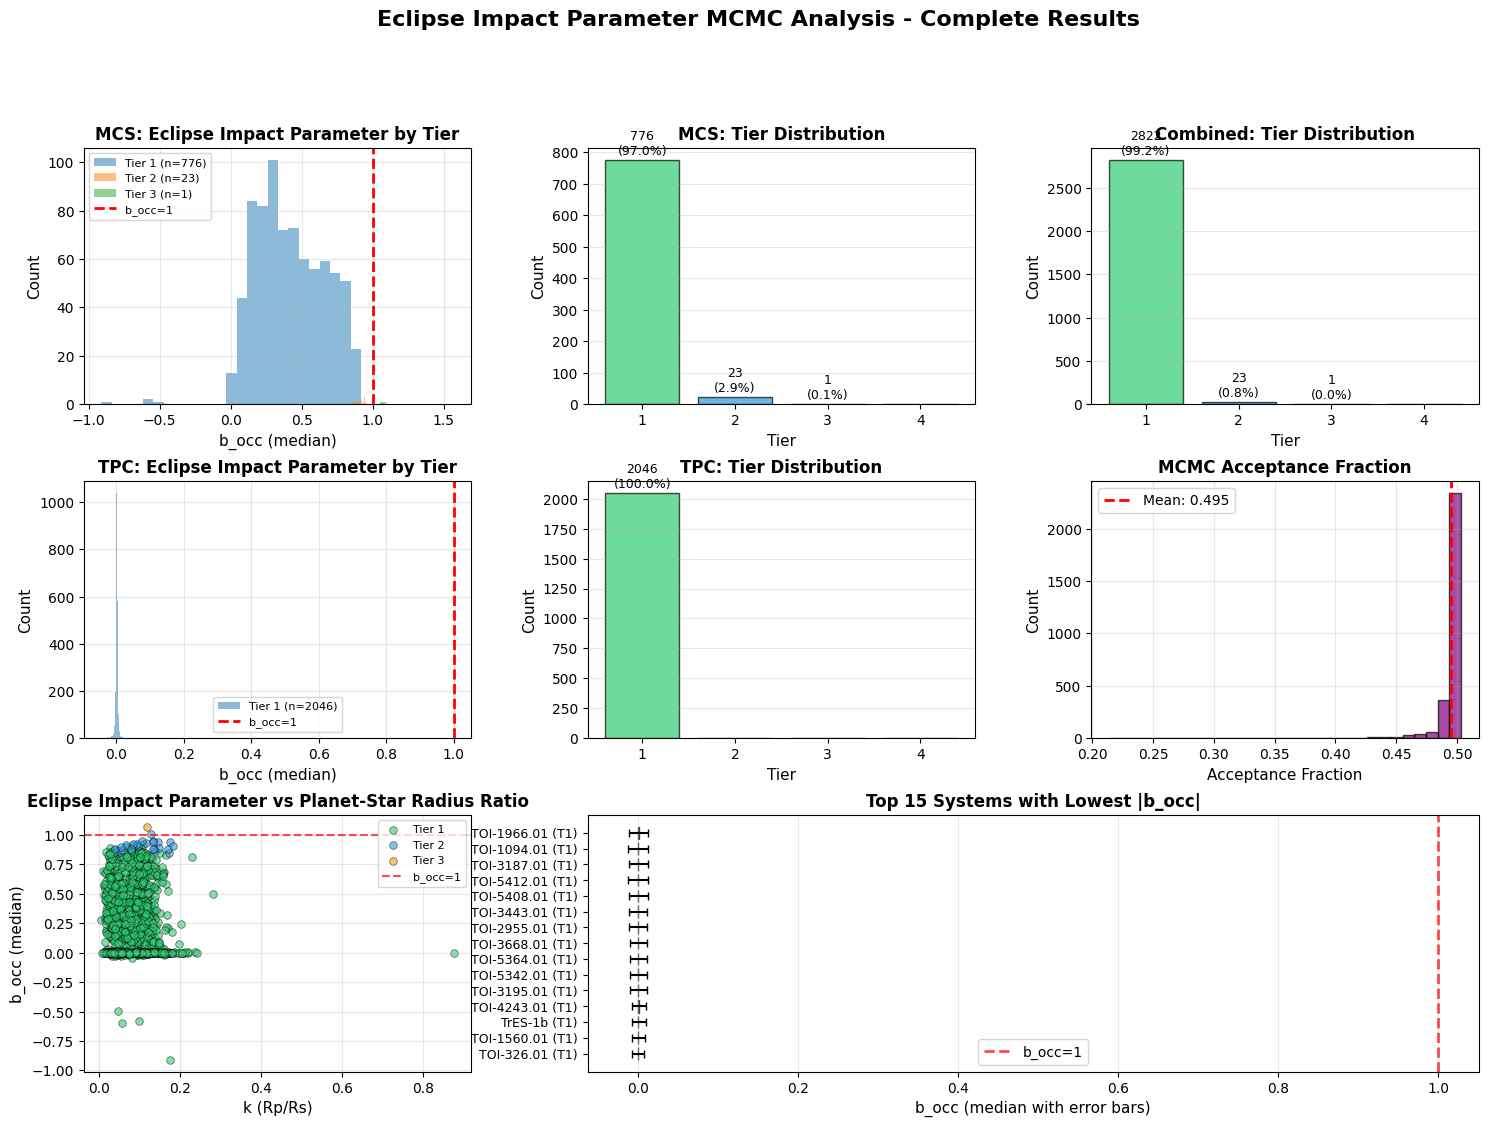


SUMMARY STATISTICS

Total Systems: 2846
  MCS (Known Planets): 800
  TPC (Candidates):    2046

Overall Tier Distribution:
  Tier 1: 2822 ( 99.2%)
  Tier 2:   23 (  0.8%)
  Tier 3:    1 (  0.0%)
  Tier 4:    0 (  0.0%)

b_occ Statistics:
  Mean:   0.1224
  Median: 0.0009
  Std:    0.2381
  Min:    -0.9096
  Max:    1.0717

Acceptance Fraction Statistics:
  Mean: 0.495
  Std:  0.009
  Min:  0.214
  Max:  0.504


In [ ]:
# Load and visualize the complete MCMC results
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the combined results
combined_file = '../results/eclipse_impact_parameter_mcmc_combined.csv'
mcs_file = '../results/mcs_eclipse_impact_parameter_mcmc.csv'
tpc_file = '../results/tpc_eclipse_impact_parameter_mcmc.csv'

if os.path.exists(combined_file):
    combined_df = pd.read_csv(combined_file)
    print("="*70)
    print(f"LOADED COMBINED RESULTS: {len(combined_df)} total systems")
    print("="*70)
    
    # Separate by dataset
    mcs_df = combined_df[combined_df['Dataset'] == 'MCS']
    tpc_df = combined_df[combined_df['Dataset'] == 'TPC']
    
    print(f"  MCS: {len(mcs_df)} systems")
    print(f"  TPC: {len(tpc_df)} systems")
    
    # Add absolute value columns for proper sorting
    combined_df['abs_b_occ_median'] = combined_df['b_occ_median'].abs()
    combined_df['abs_b_occ_84'] = combined_df['b_occ_84'].abs()
    
    # ============================================================
    # SECTION 1: TOP 3 INDIVIDUAL SYSTEMS (Best tier systems)
    # ============================================================
    print("\n" + "="*70)
    print("TOP 3 SYSTEMS (Lowest |b_occ_84| values - Best for eclipses)")
    print("="*70)
    
    # Sort by |b_occ_84| to find the best systems (lowest absolute impact parameter)
    top_systems = combined_df.nsmallest(3, 'abs_b_occ_84')
    
    for idx, row in top_systems.iterrows():
        print(f"\n{'─'*70}")
        print(f"System: {row['Planet']} ({row['Dataset']})")
        print(f"{'─'*70}")
        print(f"  Tier: {row['tier']} - {row['tier_label']}")
        print(f"  b_occ (median): {row['b_occ_median']:+.4f}  |b_occ|: {abs(row['b_occ_median']):.4f}")
        print(f"  b_occ (16th):   {row['b_occ_16']:+.4f}")
        print(f"  b_occ (84th):   {row['b_occ_84']:+.4f}  |b_occ_84|: {abs(row['b_occ_84']):.4f}")
        print(f"  Error range:    +{row['b_occ_err_upper']:.4f} / -{row['b_occ_err_lower']:.4f}")
        print(f"  k (Rp/Rs):      {row['k_rp_rs']:.4f}")
        print(f"  1-k:            {1-row['k_rp_rs']:.4f}")
        print(f"  1+k:            {row['one_plus_k']:.4f}")
        print(f"  Acceptance:     {row['acceptance_fraction']:.3f}")
        if 'eclipse_observed' in row and pd.notna(row['eclipse_observed']):
            print(f"  Eclipse Obs:    {row['eclipse_observed']}")
    
    # Display the top 3 as a table
    print("\n")
    display(top_systems[['Planet', 'Dataset', 'tier', 'tier_label', 'b_occ_median', 
                          'abs_b_occ_84', 'k_rp_rs', 'acceptance_fraction']])
    
    # ============================================================
    # SECTION 2: GRAZING ECLIPSE SYSTEMS (1-k < |b_occ| < 1+k)
    # ============================================================
    print("\n" + "="*70)
    print("GRAZING ECLIPSE SYSTEMS")
    print("="*70)
    print("Systems where (1-k) < |b_occ_84| < (1+k) - Partial/Grazing eclipses")
    
    # Find grazing systems: |b_occ_84| between (1-k) and (1+k)
    combined_df['lower_grazing'] = 1 - combined_df['k_rp_rs']
    combined_df['upper_grazing'] = 1 + combined_df['k_rp_rs']
    
    grazing_systems = combined_df[
        (combined_df['abs_b_occ_84'] > combined_df['lower_grazing']) & 
        (combined_df['abs_b_occ_84'] < combined_df['upper_grazing'])
    ].copy()
    
    print(f"\nFound {len(grazing_systems)} grazing systems:")
    print(f"  MCS: {len(grazing_systems[grazing_systems['Dataset']=='MCS'])}")
    print(f"  TPC: {len(grazing_systems[grazing_systems['Dataset']=='TPC'])}")
    
    if len(grazing_systems) > 0:
        # Sort by how close they are to the grazing boundary
        grazing_systems['grazing_depth'] = grazing_systems['abs_b_occ_84'] - grazing_systems['lower_grazing']
        grazing_systems_sorted = grazing_systems.sort_values('grazing_depth')
        
        print(f"\nTop 10 grazing systems (closest to 1-k boundary):")
        for idx, row in grazing_systems_sorted.head(10).iterrows():
            print(f"  {row['Planet']:30s} | b_occ={row['b_occ_median']:+.4f} | "
                  f"|b_occ_84|={row['abs_b_occ_84']:.4f} | "
                  f"k={row['k_rp_rs']:.4f} | (1-k)={row['lower_grazing']:.4f} | "
                  f"Tier {row['tier']}")
        
        print("\n")
        display(grazing_systems_sorted.head(10)[['Planet', 'Dataset', 'tier', 'b_occ_median', 
                                                   'abs_b_occ_84', 'k_rp_rs', 'lower_grazing', 
                                                   'upper_grazing']])
    else:
        print("  No grazing systems found (all systems are either non-grazing or no eclipse)")
    
    # Count eclipse categories
    non_grazing = combined_df[combined_df['abs_b_occ_84'] <= (1 - combined_df['k_rp_rs'])]
    no_eclipse = combined_df[combined_df['abs_b_occ_84'] >= (1 + combined_df['k_rp_rs'])]
    
    print(f"\n" + "="*70)
    print("ECLIPSE CATEGORIES")
    print("="*70)
    print(f"Non-grazing (|b_occ_84| < 1-k):     {len(non_grazing):4d} ({100*len(non_grazing)/len(combined_df):5.1f}%)")
    print(f"Grazing (1-k < |b_occ_84| < 1+k):   {len(grazing_systems):4d} ({100*len(grazing_systems)/len(combined_df):5.1f}%)")
    print(f"No eclipse (|b_occ_84| > 1+k):      {len(no_eclipse):4d} ({100*len(no_eclipse)/len(combined_df):5.1f}%)")
    print(f"Total:                               {len(combined_df):4d}")
    
    # ============================================================
    # SECTION 2: COMPREHENSIVE VISUALIZATION
    # ============================================================
    print("\n" + "="*70)
    print("GENERATING COMPREHENSIVE VISUALIZATIONS")
    print("="*70)
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: b_occ distribution by tier (MCS)
    ax1 = fig.add_subplot(gs[0, 0])
    if len(mcs_df) > 0:
        for tier in [1, 2, 3, 4]:
            tier_data = mcs_df[mcs_df['tier'] == tier]
            if len(tier_data) > 0:
                ax1.hist(tier_data['b_occ_median'], bins=25, alpha=0.5, 
                        label=f'Tier {tier} (n={len(tier_data)})')
        ax1.axvline(1.0, color='red', linestyle='--', linewidth=2, label='b_occ=1')
        ax1.set_xlabel('b_occ (median)', fontsize=11)
        ax1.set_ylabel('Count', fontsize=11)
        ax1.set_title('MCS: Eclipse Impact Parameter by Tier', fontsize=12, fontweight='bold')
        ax1.legend(fontsize=8)
        ax1.grid(alpha=0.3)
    
    # Plot 2: Tier distribution (MCS)
    ax2 = fig.add_subplot(gs[0, 1])
    if len(mcs_df) > 0:
        tier_counts = [len(mcs_df[mcs_df['tier'] == t]) for t in [1, 2, 3, 4]]
        colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
        bars = ax2.bar([1, 2, 3, 4], tier_counts, color=colors, alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Tier', fontsize=11)
        ax2.set_ylabel('Count', fontsize=11)
        ax2.set_title('MCS: Tier Distribution', fontsize=12, fontweight='bold')
        ax2.set_xticks([1, 2, 3, 4])
        ax2.grid(axis='y', alpha=0.3)
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, tier_counts)):
            if count > 0:
                pct = 100 * count / len(mcs_df)
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(tier_counts)*0.01,
                        f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)
    
    # Plot 3: b_occ distribution by tier (TPC)
    ax3 = fig.add_subplot(gs[1, 0])
    if len(tpc_df) > 0:
        for tier in [1, 2, 3, 4]:
            tier_data = tpc_df[tpc_df['tier'] == tier]
            if len(tier_data) > 0:
                ax3.hist(tier_data['b_occ_median'], bins=25, alpha=0.5,
                        label=f'Tier {tier} (n={len(tier_data)})')
        ax3.axvline(1.0, color='red', linestyle='--', linewidth=2, label='b_occ=1')
        ax3.set_xlabel('b_occ (median)', fontsize=11)
        ax3.set_ylabel('Count', fontsize=11)
        ax3.set_title('TPC: Eclipse Impact Parameter by Tier', fontsize=12, fontweight='bold')
        ax3.legend(fontsize=8)
        ax3.grid(alpha=0.3)
    
    # Plot 4: Tier distribution (TPC)
    ax4 = fig.add_subplot(gs[1, 1])
    if len(tpc_df) > 0:
        tier_counts = [len(tpc_df[tpc_df['tier'] == t]) for t in [1, 2, 3, 4]]
        colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
        bars = ax4.bar([1, 2, 3, 4], tier_counts, color=colors, alpha=0.7, edgecolor='black')
        ax4.set_xlabel('Tier', fontsize=11)
        ax4.set_ylabel('Count', fontsize=11)
        ax4.set_title('TPC: Tier Distribution', fontsize=12, fontweight='bold')
        ax4.set_xticks([1, 2, 3, 4])
        ax4.grid(axis='y', alpha=0.3)
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, tier_counts)):
            if count > 0:
                pct = 100 * count / len(tpc_df)
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(tier_counts)*0.01,
                        f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)
    
    # Plot 5: Combined tier distribution
    ax5 = fig.add_subplot(gs[0, 2])
    tier_counts = [len(combined_df[combined_df['tier'] == t]) for t in [1, 2, 3, 4]]
    colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
    bars = ax5.bar([1, 2, 3, 4], tier_counts, color=colors, alpha=0.7, edgecolor='black')
    ax5.set_xlabel('Tier', fontsize=11)
    ax5.set_ylabel('Count', fontsize=11)
    ax5.set_title('Combined: Tier Distribution', fontsize=12, fontweight='bold')
    ax5.set_xticks([1, 2, 3, 4])
    ax5.grid(axis='y', alpha=0.3)
    for i, (bar, count) in enumerate(zip(bars, tier_counts)):
        if count > 0:
            pct = 100 * count / len(combined_df)
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(tier_counts)*0.01,
                    f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)
    
    # Plot 6: Acceptance fraction distribution
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.hist(combined_df['acceptance_fraction'], bins=30, alpha=0.7, color='purple', edgecolor='black')
    ax6.axvline(combined_df['acceptance_fraction'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f"Mean: {combined_df['acceptance_fraction'].mean():.3f}")
    ax6.set_xlabel('Acceptance Fraction', fontsize=11)
    ax6.set_ylabel('Count', fontsize=11)
    ax6.set_title('MCMC Acceptance Fraction', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(alpha=0.3)
    
    # Plot 7: b_occ vs k (scatter plot)
    ax7 = fig.add_subplot(gs[2, 0])
    colors_map = {1: '#2ecc71', 2: '#3498db', 3: '#f39c12', 4: '#e74c3c'}
    for tier in [1, 2, 3, 4]:
        tier_data = combined_df[combined_df['tier'] == tier]
        if len(tier_data) > 0:
            ax7.scatter(tier_data['k_rp_rs'], tier_data['b_occ_median'], 
                       c=colors_map[tier], alpha=0.6, s=30, label=f'Tier {tier}', edgecolors='black', linewidth=0.5)
    ax7.axhline(1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='b_occ=1')
    ax7.set_xlabel('k (Rp/Rs)', fontsize=11)
    ax7.set_ylabel('b_occ (median)', fontsize=11)
    ax7.set_title('Eclipse Impact Parameter vs Planet-Star Radius Ratio', fontsize=12, fontweight='bold')
    ax7.legend(fontsize=8, loc='upper right')
    ax7.grid(alpha=0.3)
    
    # Plot 8: Error bar plot for grazing eclipse systems
    ax8 = fig.add_subplot(gs[2, 1:])
    
    # Show grazing systems if they exist, otherwise show top 15
    if len(grazing_systems) > 0:
        # Show up to 15 grazing systems, sorted by grazing_depth (closest to 1-k boundary first)
        n_show = min(15, len(grazing_systems))
        grazing_to_plot = grazing_systems_sorted.head(n_show)
        y_pos = np.arange(len(grazing_to_plot))
        colors_tier = [colors_map[t] for t in grazing_to_plot['tier'].values]
        
        # Plot with error bars
        ax8.barh(y_pos, grazing_to_plot['b_occ_median'], 
                xerr=[grazing_to_plot['b_occ_err_lower'], grazing_to_plot['b_occ_err_upper']],
                color=colors_tier, alpha=0.7, capsize=3, edgecolor='black')
        ax8.set_yticks(y_pos)
        ax8.set_yticklabels([f"{name[:20]}... (T{tier})" if len(name) > 20 else f"{name} (T{tier})" 
                             for name, tier in zip(grazing_to_plot['Planet'], grazing_to_plot['tier'])], fontsize=9)
        
        # Add reference lines for (1-k) and (1+k) boundaries
        # Use the average k for reference (since each system has different k)
        avg_k = grazing_to_plot['k_rp_rs'].mean()
        ax8.axvline(1.0 - avg_k, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label=f'1-k (avg)')
        ax8.axvline(1.0 + avg_k, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label=f'1+k (avg)')
        ax8.axvline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='b_occ=1')
        
        ax8.set_xlabel('b_occ (median with error bars)', fontsize=11)
        ax8.set_title(f'Grazing Eclipse Systems (n={len(grazing_systems)}, showing top {n_show})', 
                     fontsize=12, fontweight='bold')
        ax8.legend(fontsize=9)
    else:
        # Fallback to top 15 if no grazing systems
        top15 = combined_df.nsmallest(15, 'abs_b_occ_84')
        y_pos = np.arange(len(top15))
        colors_tier = [colors_map[t] for t in top15['tier'].values]
        ax8.barh(y_pos, top15['b_occ_median'], xerr=[top15['b_occ_err_lower'], top15['b_occ_err_upper']],
                color=colors_tier, alpha=0.7, capsize=3, edgecolor='black')
        ax8.set_yticks(y_pos)
        ax8.set_yticklabels([f"{name[:20]}... (T{tier})" if len(name) > 20 else f"{name} (T{tier})" 
                             for name, tier in zip(top15['Planet'], top15['tier'])], fontsize=9)
        ax8.axvline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='b_occ=1')
        ax8.set_xlabel('b_occ (median with error bars)', fontsize=11)
        ax8.set_title('Top 15 Systems with Lowest |b_occ|', fontsize=12, fontweight='bold')
        ax8.legend()
    
    ax8.grid(axis='x', alpha=0.3)
    
    plt.suptitle('Eclipse Impact Parameter MCMC Analysis - Complete Results', 
                fontsize=16, fontweight='bold', y=0.995)
    
    # Save the figure
    output_file = '../results/eclipse_impact_parameter_comprehensive_summary.png'
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    print(f"\n✓ Comprehensive visualization saved to: {output_file}")
    plt.show()
    
    # ============================================================
    # SECTION 3: SUMMARY STATISTICS
    # ============================================================
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)
    
    print(f"\nTotal Systems: {len(combined_df)}")
    print(f"  MCS (Known Planets): {len(mcs_df)}")
    print(f"  TPC (Candidates):    {len(tpc_df)}")
    
    print(f"\nOverall Tier Distribution:")
    for tier in [1, 2, 3, 4]:
        count = len(combined_df[combined_df['tier'] == tier])
        pct = 100 * count / len(combined_df)
        print(f"  Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    print(f"\nb_occ Statistics:")
    print(f"  Mean:   {combined_df['b_occ_median'].mean():.4f}")
    print(f"  Median: {combined_df['b_occ_median'].median():.4f}")
    print(f"  Std:    {combined_df['b_occ_median'].std():.4f}")
    print(f"  Min:    {combined_df['b_occ_median'].min():.4f}")
    print(f"  Max:    {combined_df['b_occ_median'].max():.4f}")
    
    print(f"\nAcceptance Fraction Statistics:")
    print(f"  Mean: {combined_df['acceptance_fraction'].mean():.3f}")
    print(f"  Std:  {combined_df['acceptance_fraction'].std():.3f}")
    print(f"  Min:  {combined_df['acceptance_fraction'].min():.3f}")
    print(f"  Max:  {combined_df['acceptance_fraction'].max():.3f}")
    
else:
    print(f"Combined file not found: {combined_file}")
    print("Please run cell 25 first to generate the combined results file.")

## Summary

This notebook performs MCMC analysis on the eclipse impact parameter $b_{\text{occ}}$ for exoplanet systems in the Ariel MCS and TPC catalogs. The analysis:

1. Loads the updated 2025-07-18 data files
2. Identifies the correct column names for required parameters
3. Implements the eclipse impact parameter equation from Winn (2010)
4. Uses **informative priors** based on transit observations:
   - Normal prior on $a/R_\star$ (from transit + stellar modeling)
   - **Normal prior on $\cos i$** (derived from transit inclination; more natural for geometry)
   - **Beta prior on eccentricity** (Kipping 2013: α=0.867, β=3.03 for short-period planets)
   - Uniform prior on $\omega$ (argument of periastron)
5. Implements **hard constraint**: occultation must exist ($|b_{\rm occ}| \leq 1 + k$)
6. Uses scipy.stats logpdf for numerically robust prior calculations
7. Visualizes the posterior distributions
8. Assigns tier classification based on eclipse detectability
9. Saves the results for further analysis

The key parameters sampled in the MCMC are:
- Scaled semi-major axis ($a/R_\star$)
- **Cosine of inclination ($\cos i$)** - sampled directly instead of transit impact parameter
- Eccentricity ($e$)
- Argument of periastron ($\omega$)

The inclination ($i$) and eclipse impact parameter ($b_{\rm occ}$) are derived quantities computed from the sampled parameters.